# <span style="color:'red'"> EEG Model </span>

## Heading 1
All high-level description goes here

## Heading 2
some text

## Heading 3
some text
- couple points
- couple points
- couple points
- couple points

## Heading 4
some text

In [2]:
%%capture cell
! pip install pyEDFlib mne "mne[hdf5]" h5io pymatreader

In [1]:
import os
import mne
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# MNE For loading and visualizing eeg data from edf format
from mne import io
from mne.datasets import sample
from mne.minimum_norm import compute_source_psd, read_inverse_operator
from IPython.display import display

# Tensorflow Imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

## Fetching and Loading Data

In [2]:
# Clear cached dataset
# !rm -rf

In [3]:
# Data downloader using requests module
def download_data_source(url, dir_path, dataset_path):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()  # Raise an exception for bad status codes
      with open(dataset_path, "wb") as f:
          for chunk in r.iter_content(chunk_size=8192):  # Download in chunks
              f.write(chunk)

In [4]:
url = "https://drive.usercontent.google.com/download?id=1dRyO6tD3iXx_-Dsid3PdBa5oKVWOFJwL&export=download&authuser=2&confirm=t&uuid=48b6f65b-981b-4155-be6c-198710034f61&at=APZUnTXuPSTpdXjZ2oq-YfGpAs_e%3A1720029931772"
dataset_path = "eeg-during-mental-arithmetic-tasks-1.0.0.zip"
dir_path = "./data"

dataset_path = os.path.join(dir_path, dataset_path)

In [5]:
# Download main data source

%%capture cell
! mkdir -p {dir_path}
download_data_source(url, dir_path, dataset_path)
!unzip -o $dataset_path -d $dir_path

In [6]:
# ! python -c "import sys; print(sys.executable)"

In [7]:
%env MNE_USE_CUDA=true
! python -c "import mne; mne.cuda.init_cuda(verbose=True)"
mne.utils.set_config('MNE_USE_CUDA', 'true')

env: MNE_USE_CUDA=true
Now using CUDA device 0
Enabling CUDA with 14.65 GB available memory


In [8]:
# optional test for mne
# ! pytest mne/tests/test_filter.py -k cuda

In [9]:
# print(__doc__)

In [10]:
# Loading/Reading Main data source

%%capture cell
data_files_path = "/content/data/eeg-during-mental-arithmetic-tasks-1.0.0"
records_file = os.path.join(data_files_path, "RECORDS")

with open(records_file, "r", encoding="utf-8") as fp:
  records = fp.read().splitlines()

raw_data_list = [
    mne.io.read_raw_edf(os.path.join(data_files_path, record_file), preload=True)
    for record_file in records
    if record_file.endswith(".edf")
]

In [11]:
# Example demo
type_0_data, type_1_data = raw_data_list[::2], raw_data_list[1::2]
sample_subject = type_0_data[0], type_1_data[0]
sample_raw = sample_subject[1]
sample_raw

<RawEDF | Subject00_2.edf, 21 x 31000 (62.0 s), ~5.0 MB, data loaded>

In [12]:
sample_raw.compute_psd(method="multitaper", tmin=10, tmax=20, fmin=5, fmax=30, picks="eeg")

    Using multitaper spectrum estimation with 7 DPSS windows


<Power Spectrum (from Raw, multitaper method) | 21 channels × 250 freqs, 5.1-30.0 Hz>

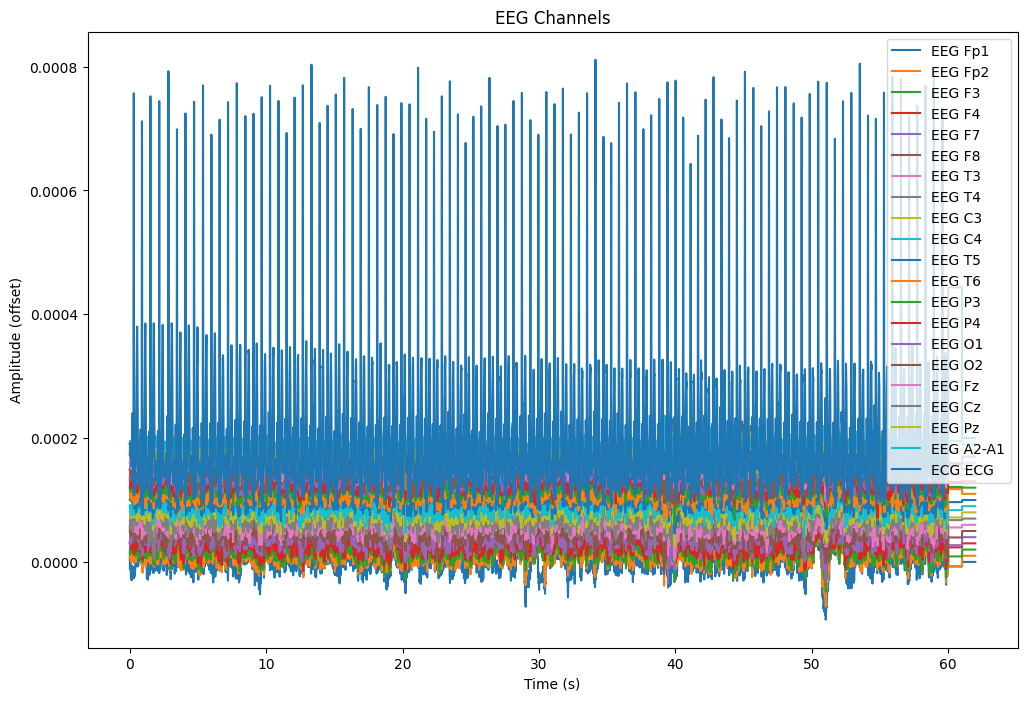

In [13]:
def plot_all_channels(raw):
    # Get data and channel names
    data, times = raw.get_data(return_times=True)
    ch_names = raw.info['ch_names']

    # Plot each channel with a different color
    plt.figure(figsize=(12, 8))
    for i, channel in enumerate(data):
        plt.plot(times, channel + i * 10e-6, label=ch_names[i])  # Offset each channel vertically for better visibility

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (offset)')
    plt.title('EEG Channels')
    plt.legend(loc='upper right')
    plt.show()

# Plot all channels
plot_all_channels(sample_raw)


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


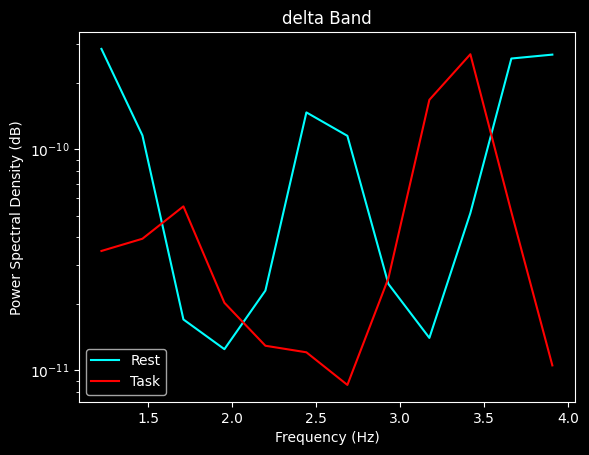

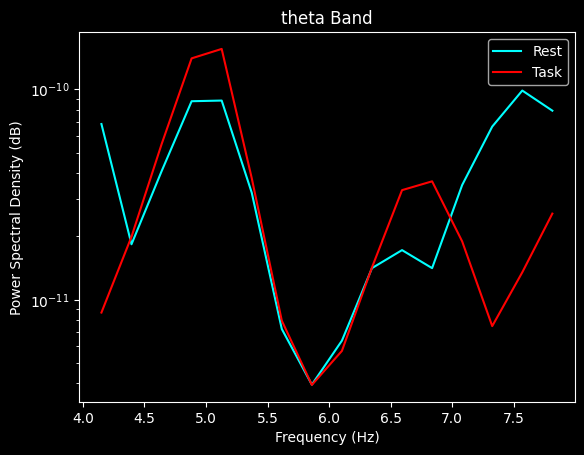

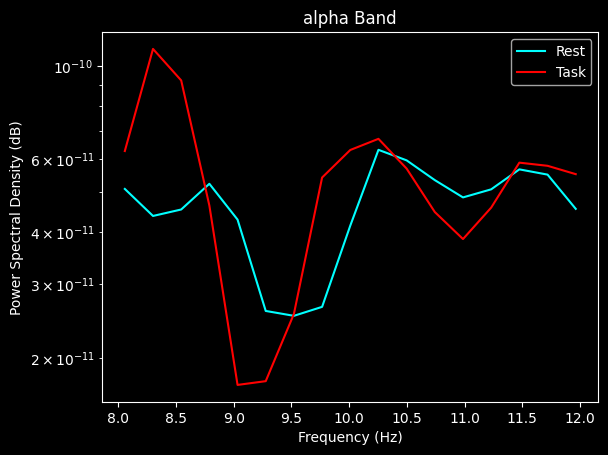

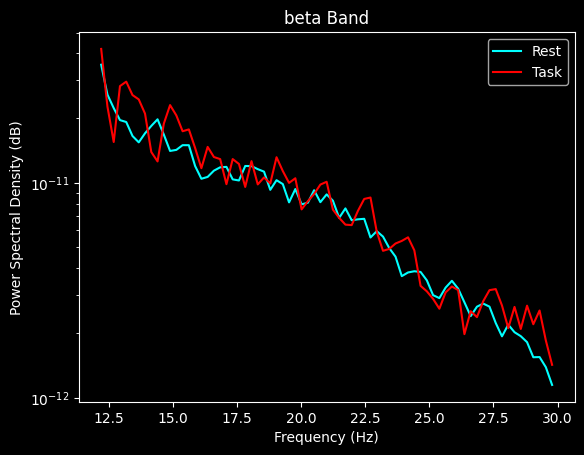

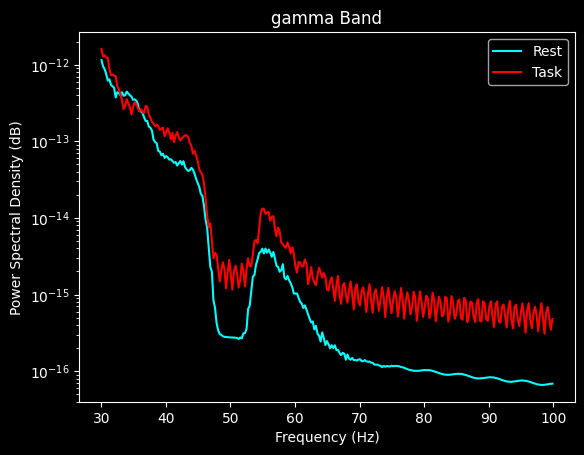

In [14]:
FREQ_BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 100)
}

def compute_band_psd(raw, band, sig_len=2048, picks='eeg'):
    fmin, fmax = band
    psd = raw.compute_psd(method='welch', fmin=fmin, fmax=fmax, n_fft=sig_len, picks=picks)
    return psd

rest_raw = sample_subject[0].copy()
task_raw = sample_subject[1].copy()
# rest_signal_len = 1501
# task_signal_len = 2048 - rest_signal_len

# Compute PSD for each band
rest_psd = {band: compute_band_psd(rest_raw, FREQ_BANDS[band]) for band in FREQ_BANDS}
task_psd = {band: compute_band_psd(task_raw, FREQ_BANDS[band]) for band in FREQ_BANDS}

# Plot PSDs for comparison
plt.style.use('dark_background')
for band in FREQ_BANDS:
    rest_psd_mean = np.mean(rest_psd[band].get_data(), axis=0)
    task_psd_mean = np.mean(task_psd[band].get_data(), axis=0)
    freqs = rest_psd[band].freqs

    plt.figure()
    plt.semilogy(freqs, rest_psd_mean, label='Rest', color="cyan")
    plt.semilogy(freqs, task_psd_mean, label='Task', color="red")
    plt.title(f'{band} Band')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.legend()
    plt.show()

In [15]:
# rest_psd["alpha"].get_data()
# task_psd['alpha'].get_data()

In [16]:
num_cols = len(sample_subject[0].ch_names)

gen_col = lambda : (
  np.random.choice(np.r_[range(226), range(300, 361)]) / 360,
  np.random.choice(range(90, 101)) / 100,
  np.random.choice(range(50, 101)) / 100,
)

plot_cols = [matplotlib.colors.hsv_to_rgb(gen_col()) for _ in range(num_cols)]

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


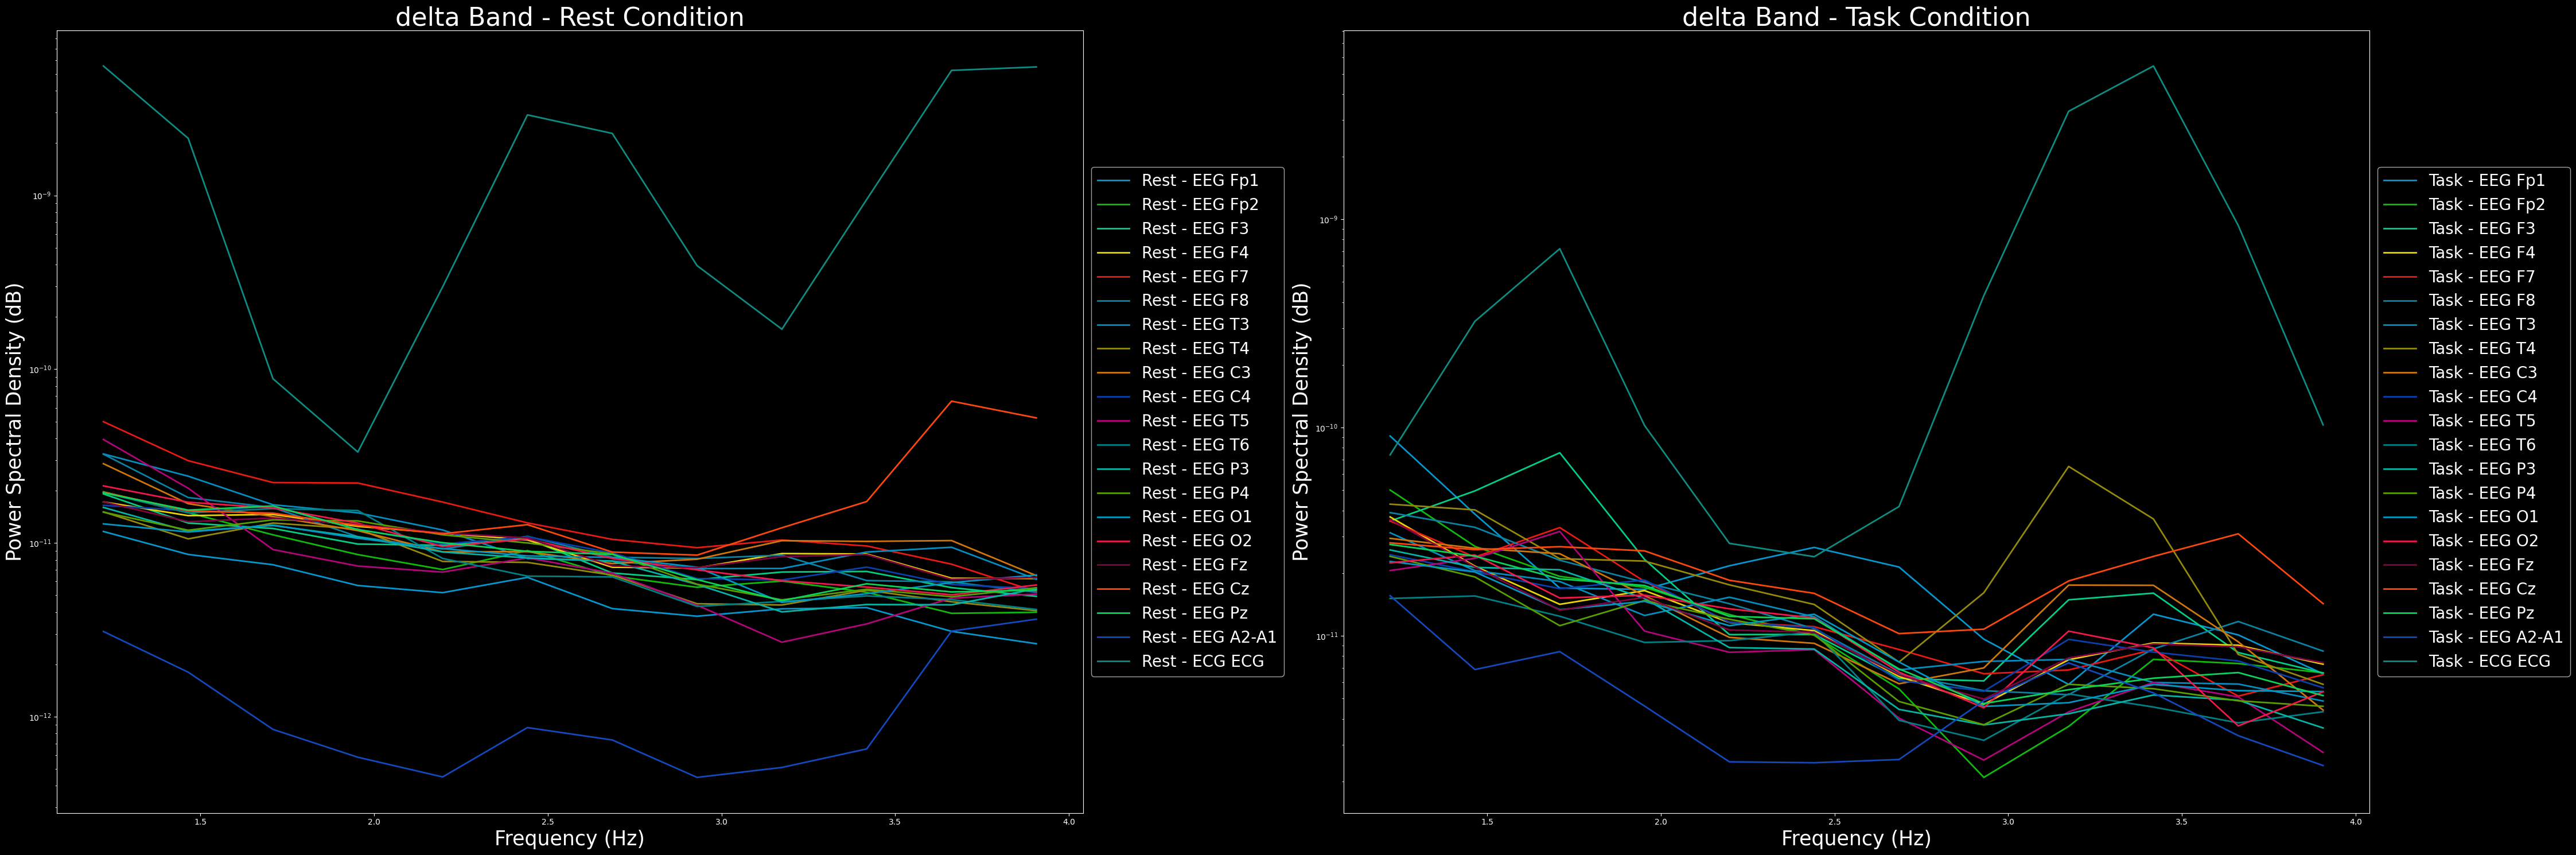

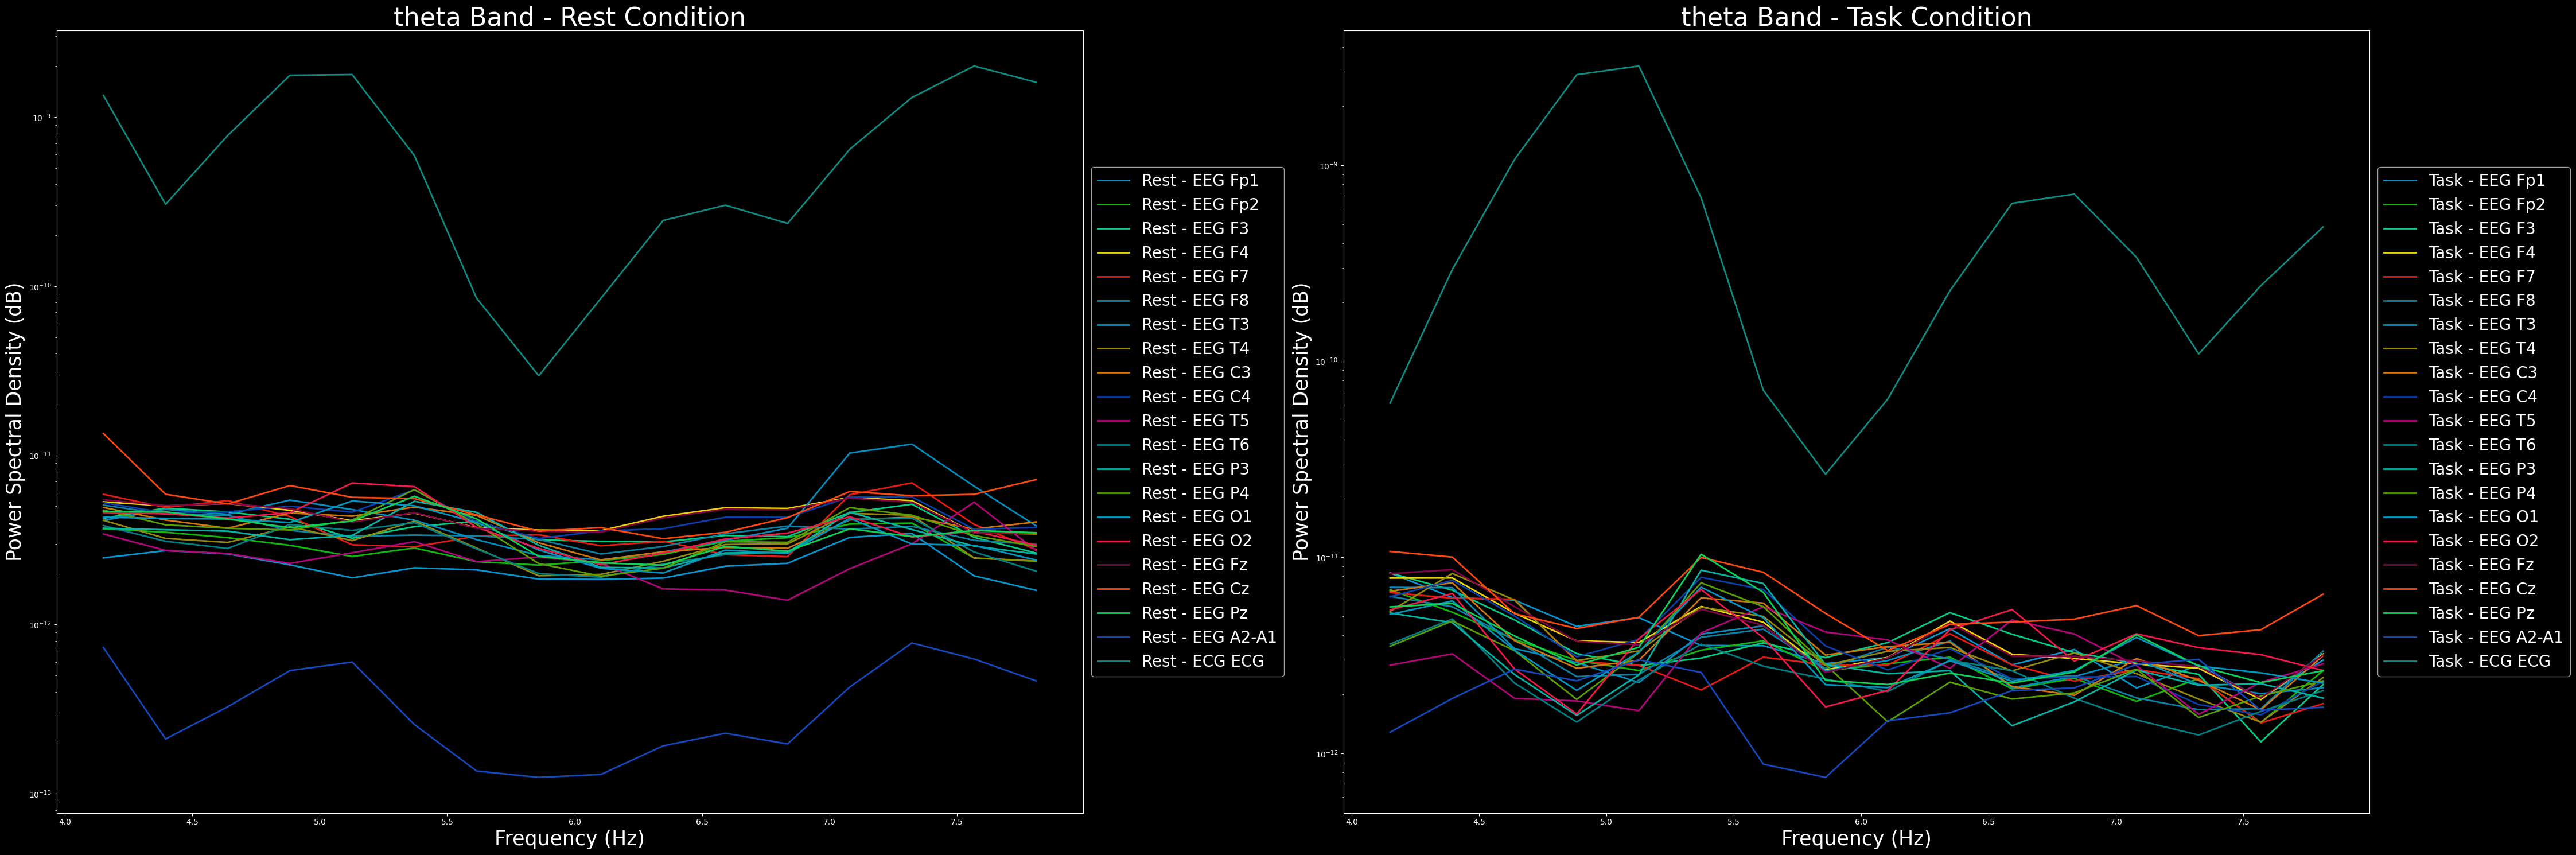

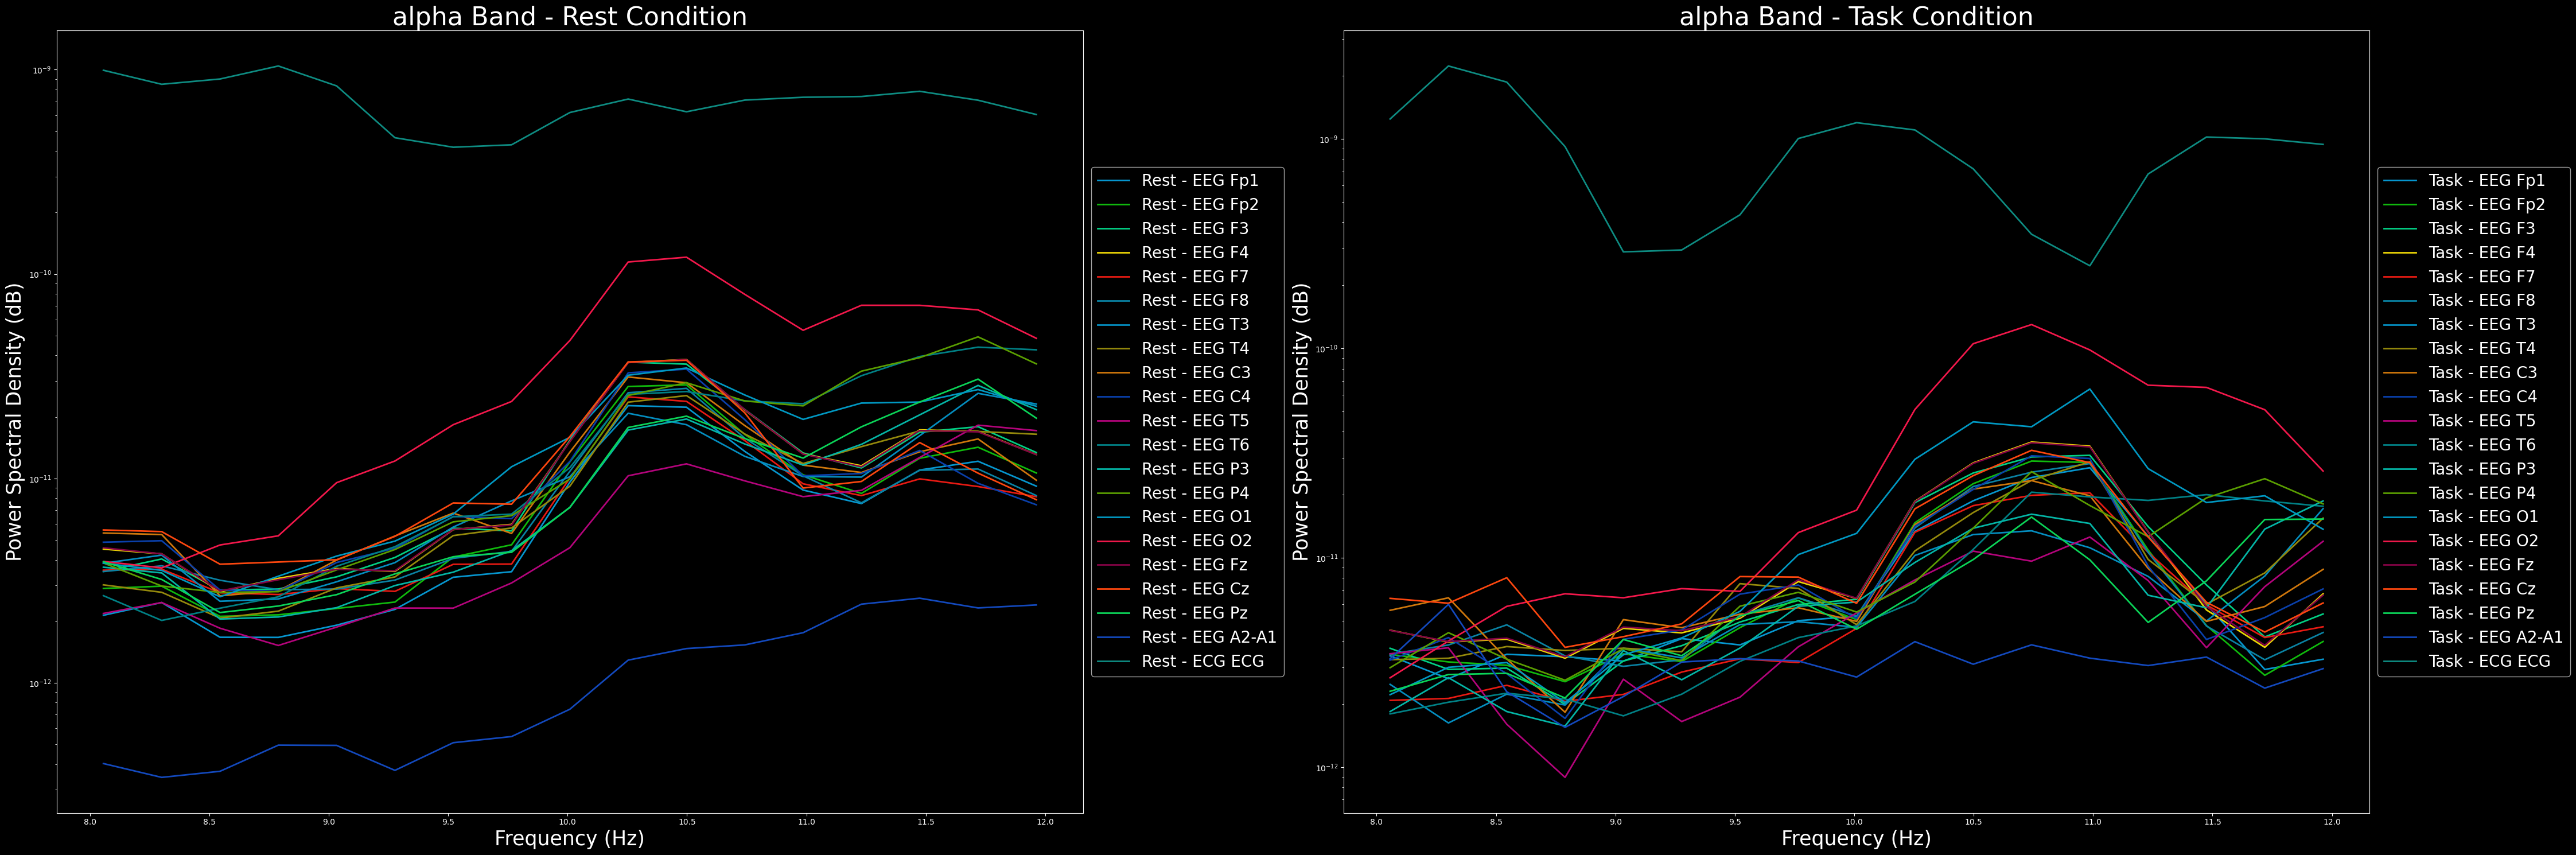

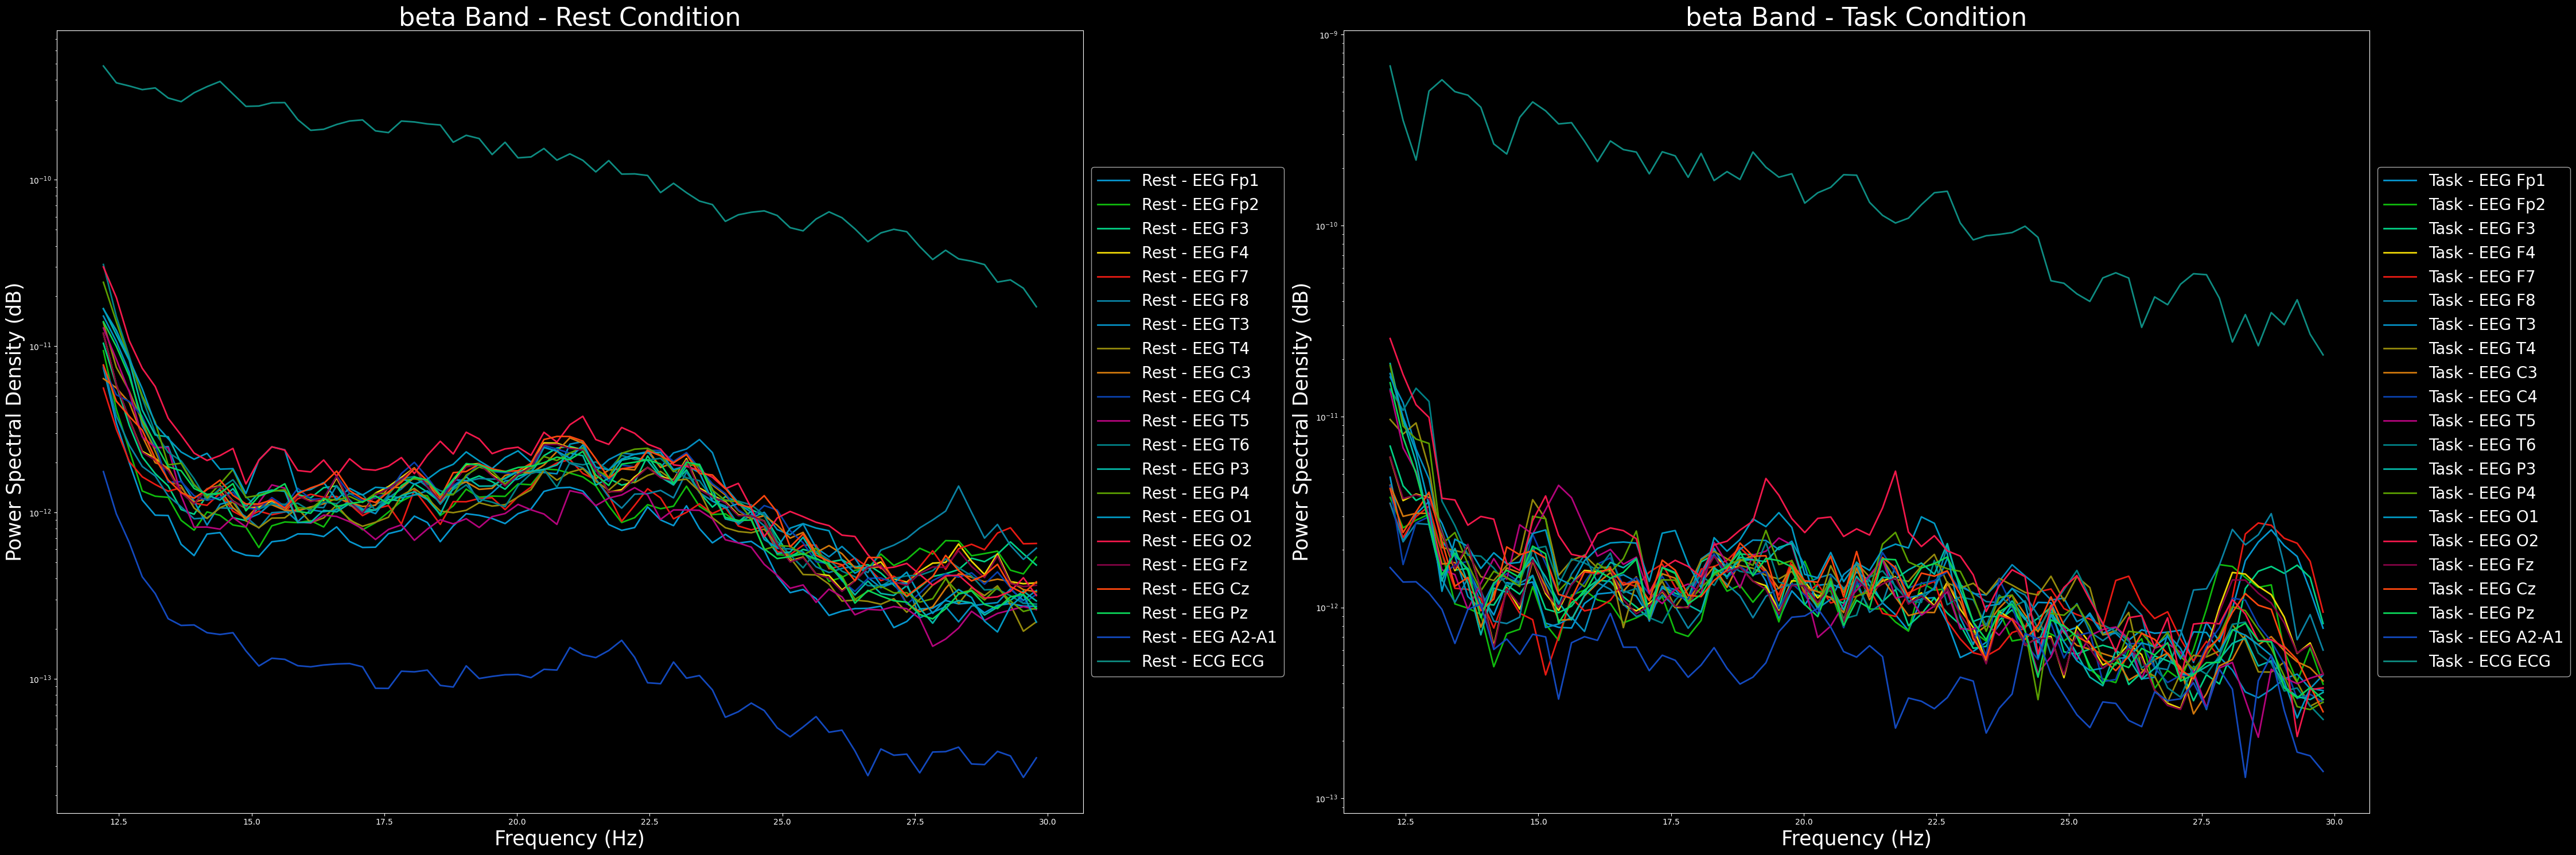

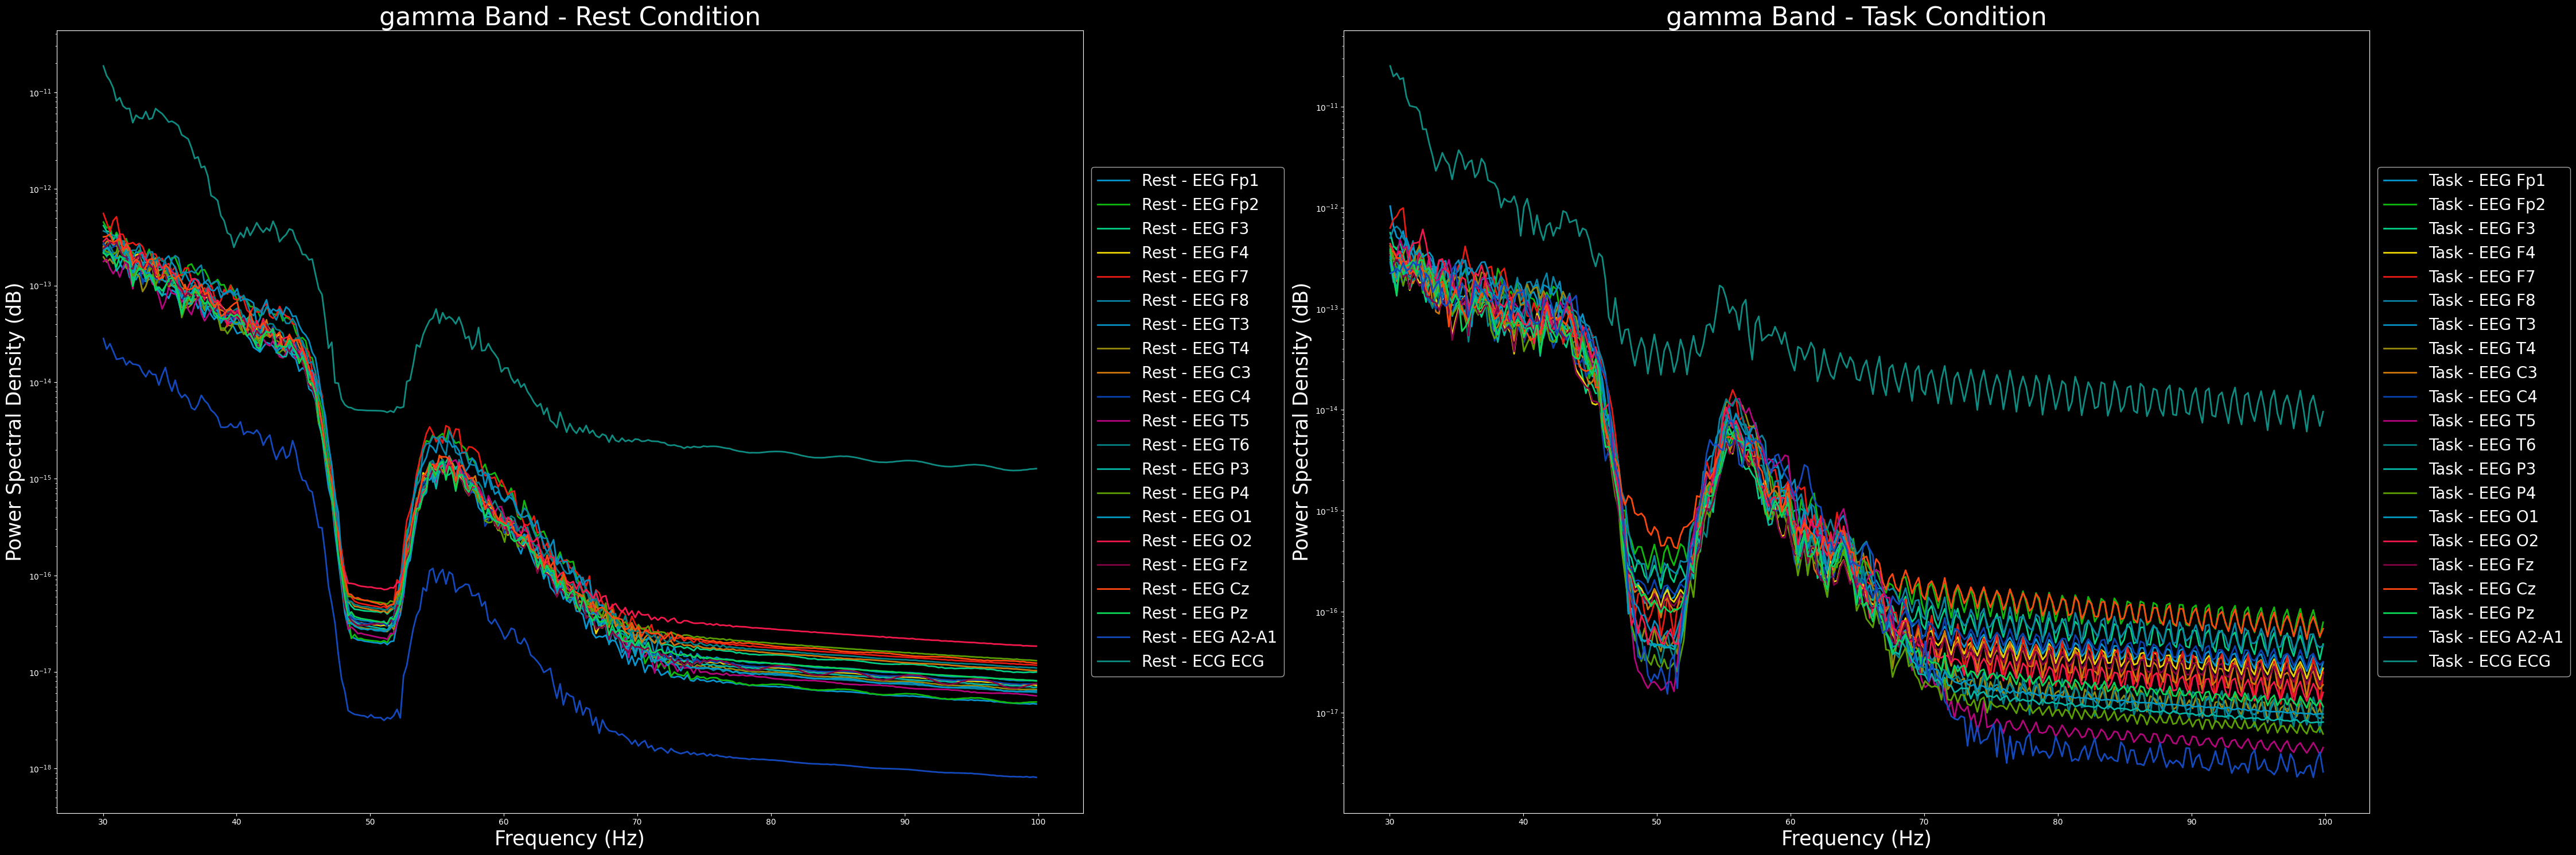

In [17]:
# Setup PSD data for plotting
rest_raw = sample_subject[0].copy()
task_raw = sample_subject[1].copy()

rest_psd = {band: compute_band_psd(rest_raw, FREQ_BANDS[band]) for band in FREQ_BANDS}
task_psd = {band: compute_band_psd(task_raw, FREQ_BANDS[band]) for band in FREQ_BANDS}

# Adjust font sizes and line widths
title_fontsize = 32
label_fontsize = 25
legend_fontsize = 20
line_width = 2

# Iterate over all major recognised frequency bands
# defined in FREQ_BANDS
for band in FREQ_BANDS:
    freqs = rest_psd[band].freqs

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(45, 15))

    # First subplot for the rest condition
    ax1.set_title(f'{band} Band - Rest Condition', fontsize=title_fontsize)
    for ch_idx in range(len(rest_psd[band].ch_names)):
        ax1.semilogy(freqs, rest_psd[band].get_data()[ch_idx], label=f'Rest - {rest_psd[band].ch_names[ch_idx]}', color=plot_cols[ch_idx], linewidth=line_width)
    ax1.set_xlabel('Frequency (Hz)', fontsize=label_fontsize)
    ax1.set_ylabel('Power Spectral Density (dB)', fontsize=label_fontsize)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legend_fontsize)

    # Second subplot for the task condition
    ax2.set_title(f'{band} Band - Task Condition', fontsize=title_fontsize)
    for ch_idx in range(len(task_psd[band].ch_names)):
        ax2.semilogy(freqs, task_psd[band].get_data()[ch_idx], label=f'Task - {task_psd[band].ch_names[ch_idx]}', color=plot_cols[ch_idx], linewidth=line_width)
    ax2.set_xlabel('Frequency (Hz)', fontsize=label_fontsize)
    ax2.set_ylabel('Power Spectral Density (dB)', fontsize=label_fontsize)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=legend_fontsize)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [18]:
# Code Source File
# https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py

def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


In [19]:
# eegnet_model = EEGNet(2)
# eegnet_model.compile()

In [20]:
print(mne.events_from_annotations(sample_raw))
sample_raw.load_data()
sample_raw.filter(8., 13., fir_design='firwin') # Alpha waves

print(sample_raw.annotations.description)

(array([], shape=(0, 3), dtype=int64), {})
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)

[]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


# Extracting relevant features

In [21]:
from sklearn.preprocessing import StandardScaler

def extract_features(raw, bands):
    features = []
    for band in bands:
        psd = compute_band_psd(raw, bands[band])
        features.append(psd.get_data().flatten())
    return np.concatenate(features)

# Extract features for rest and task states
rest_features = extract_features(rest_raw, FREQ_BANDS)
task_features = extract_features(task_raw, FREQ_BANDS)

# Combine features and create labels
X = np.vstack([rest_features, task_features])
y = np.array([0] * len(rest_features) + [1] * len(task_features))  # 0 for rest, 1 for task

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


In [22]:
rest_psd[band]

<Power Spectrum (from Raw, welch method) | 21 channels × 287 freqs, 30.0-99.9 Hz>

## Model Category 1 (EEGNet Flavors)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# # Split data into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Convert labels to categorical
# y_train_cat = to_categorical(y_train)
# y_test_cat = to_categorical(y_test)

# Define EEGNet model
def EEGNet(nb_classes,
           Chans=64,
           Samples=128,
           dropoutRate=0.5,
           kernLength=64,
           F1=8,
           D=2,
           F2=16,
           dropoutType='Dropout'):
    input1 = layers.Input(shape=(Chans, Samples, 1))

    block1 = layers.Conv2D(F1, (1, kernLength), padding='same', input_shape=(Chans, Samples, 1), use_bias=False)(input1)
    block1 = layers.BatchNormalization(axis=-1)(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=None)(block1)
    block1 = layers.BatchNormalization(axis=-1)(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.AveragePooling2D((1, 4))(block1)
    block1 = layers.Dropout(dropoutRate)(block1)

    block2 = layers.SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = layers.BatchNormalization(axis=-1)(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.AveragePooling2D((1, 8))(block2)
    block2 = layers.Dropout(dropoutRate)(block2)

    flatten = layers.Flatten(name='flatten')(block2)

    dense = layers.Dense(nb_classes, name='dense', kernel_constraint=None)(flatten)
    softmax = layers.Activation('softmax', name='softmax')(dense)

    return models.Model(inputs=input1, outputs=softmax)


In [24]:
rest_psd[band]

<Power Spectrum (from Raw, welch method) | 21 channels × 287 freqs, 30.0-99.9 Hz>

Using matplotlib as 2D backend.


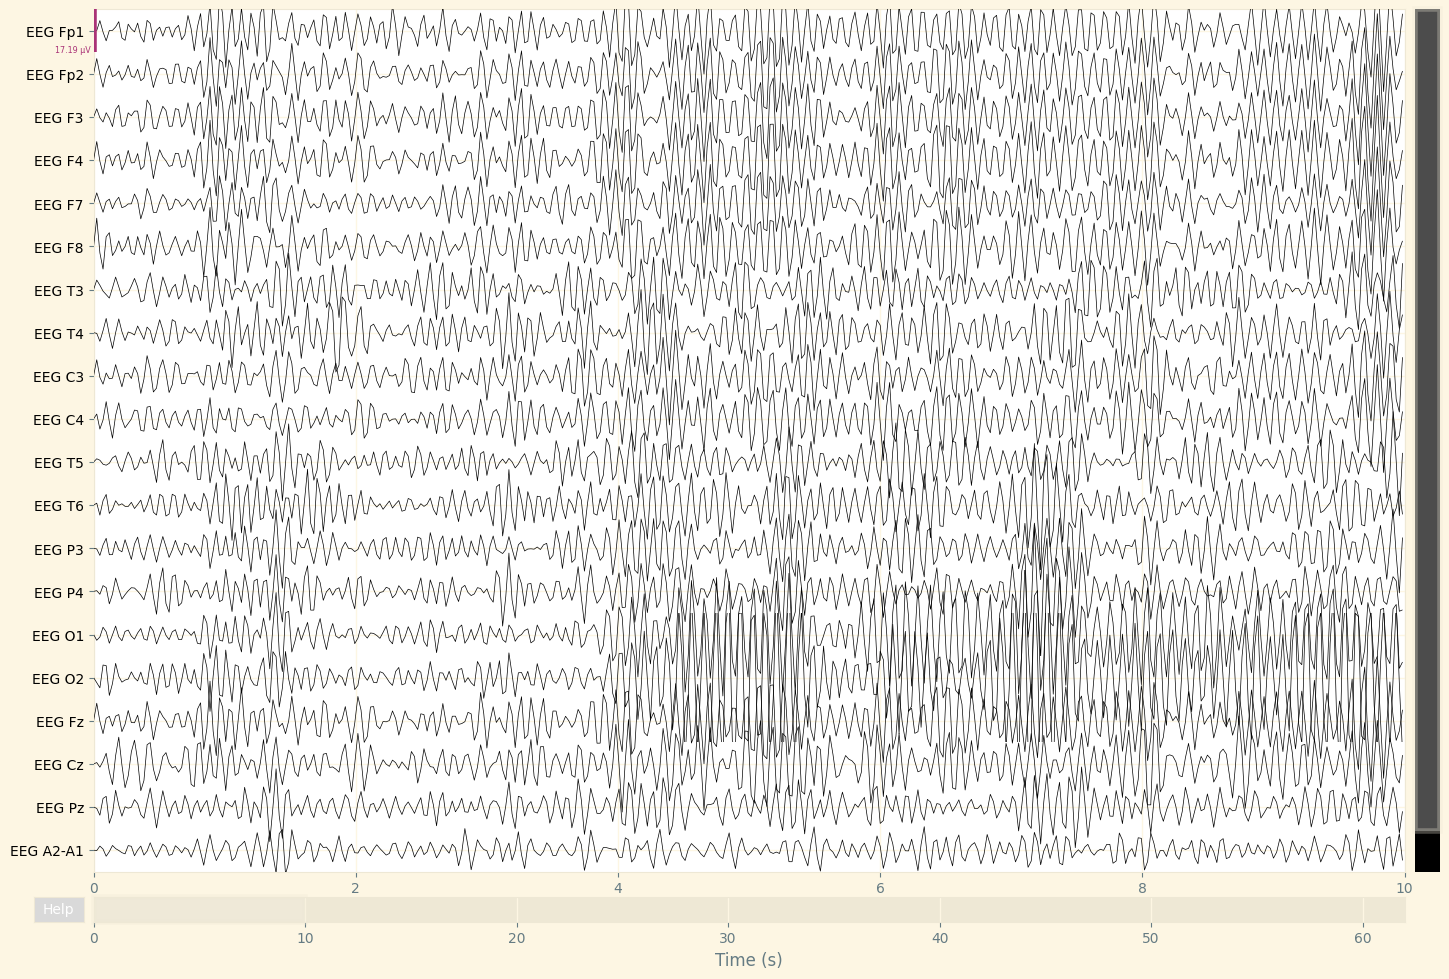

In [34]:
plt.style.use('Solarize_Light2')
fig = sample_raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

# plt.style.available

## Reference image for each channel

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAA1sAAAMACAQAAAB4fLW6AAAABGdBTUEAALGPC/xhBQAAACBjSFJNAAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAAAmJLR0QA/4ePzL8AAAAHdElNRQfhBwsQIwjYuWW1AACAAElEQVR42uxdZ5gUxRY9G1lY0pJzzlFAQAUJiokkoGBAUEQQRAURJTwVVBBEDCgKCAqCIqKggiAKkpNIVJLkKDnHZcN5P6p7pmd2uqenu2dmQ5353pOd0JXvrbp177kRkJCQcApFUQrFUQLZEY9YABeQjJM4imM4gCTZPRISTiBCdoGEhE0UQDM0Rm3URoLud25iB/7BaizFbtlhEhISEhLhQU28iS1IBQN4HcZYNEak7DwJCQkJidAhHwZgZ0DqyvN1EAORX3ajhETgkEZCCYlAURGD8RjivN69iH/wD3bjGI7hIq7jJmIRhbwojGIogxqogbJev7iBLzACx2WHSkhISEgEC+UxFUke56YrmIPnUd3Eb4vgUUzCKY9fX8VIxMtulZCQkJBwHtnxNm5oVE4ivkMHZA/wKVG4G9M8nrMf98rOlZCQkJBwFndhv0bVHMP/UNjG0wrhdZzTPG8cYmUXS0hISEg4gxiMQopLxfyHvmlutqwgAe/guuup61BSdrSEhISEhH0UxlqNYfAd5HDw2ZWxwvXso6gqO1tCQkJCwh6qaoyDq1HF8edHYBCSleefRj3Z4RISEhIS1nGr6wYqGW8iOkilNMcZl+KqJDtdQkJCQsIaarrUyQXcE9SSquGoUtJeFJIdLyEhISEROMrihKJKDqFGCEo7ppS2WFI/SUhISEgEijhsUNTIkTT8FsFBDZxXSnxFdr+EhISERGCYoqiQ4yG8bWqj0PImopocAAkJCQkJ82ilKK2buDOk5Y5zGQolJCQkJCRMIheOKOrj+RCXnB37lJJbymGQkJCQkDCH9xTVsTAMZT/kihGTkJCQkJAwgYK4orCzlwtL+asUxdVQDoWEhISEhH+MUNTG22Eqv71S/nQ5FBISEhIS/hCLs0oerQJhqkGUcr91CdnkcEhIeEOGNUpIeOI+5AMATMaZMNUgBd8CAHLhQUeY5iUkJCQkMjFmKCa6cJLa1tNk4rqGY1iL8egZAqYOCYkMgAjZBRJZGiXRDNVQGZURj9zIiWvIhUgAu1E5rOvyjHLm88R+/ISZ+EsOm4SEhETWwy34ADs0pxrP10dhrt0fujUjNqArYuQASkhISGQVRKMb1huoBYJ4NMx1HIqL2IPleA1v4VMsdbEVqq+daCUHUkJCQiLzIwIP4980SioRO/AH5mMWFmEntmE6SqW7mlfGAKxCiqbWv6O8HFAJCQmJzIxyWOahrk5jBp5CxaClfwxGC0ZpTl5X0VcOqoSEhERmxbO47BL4KViIDhn0higBHyDR1ZLvES+HVkJCQiKzIRqfaU5Zi1BX53vCZFghzXtadAVBdPH6ZXYMwFpcQDLOYjVGoLbBE4Cq+Ay7cAVX8S/Go2qANQAqYrGrNRtRTA6whISERGZCApa6hPxh3GfwTfGdnw2VxnIQxDKP9wphW5obM/0nDESyxzeT8WpANQCACPTHDeXbR2V+LgkJCYnMg7yuPMXEdOQ1/K4gVSJa6CqNiiAu4zLocSKaCuIonkIJxCIPbsNgbNV9Ql8QqZiMBsiJHKiPSUgF8aLpGrhRD8dcySyryIGWkJCQyAzIjXWKaE/FML/fJohBILZp3DQ8lcYoEJPxBYiRmnfPgrjN8KkqSiIRRDePz7uBSEQJkzXQogQ2K607hopysCUkJCQyOqLwu8vJvZ2J7xNENuwD8YJPpRGN4yBuw+0g/tMolhsg8ptSWyNAfJ/mGz+AGG6qBvpqeV/YyH8lJCQkJBzCB4pIv4kHTX1fKIj2IM666JW0SuNBENsAANtBtHW9vxbET16OFL7V1noQ96b5xn0g1pmqQVrkwZ9KK5cjVg65hISERMbFIy7zYCeTv1AVxB8gxvlQGvNAvAQA6A9iruv9O3FdOfHMxpu4G1G6ausc6INvsACoMM77q4Ev5MMepaXvy0GXkJCQyKgoqmTOook7LW8FUwPJSEZ1L6VRDMlIVIyBBZCIZBR1/bIKpuGSy/XjCB7SUVtJoI/w5hgQSSZqoIfKShByKh6QAy8hISGRMTFPUSHzAsgr51YQn4JY5PXeEBDfub47C8Rgj19HoTYex0fYDSJVY5a0ctryXQN9tEKqojDzyaGXkJCQyHh4yEXgVDiAX7kVRH6cA9FO814E9qaJzdrj8ymRGAlio0+1tR7EPWl+cS+IP/3WwBifKHWaKAdfQkJCIqMhBrsVId4xoN9pFcSLIPYi1vVec59c8c18PicviBs+n/oOiFlpvv89iBF+a2CM7NiuEFfdKieAhISERMbCi4pS+S3A33k6u28HMdD13tcg3vL49lsgpvt8zq0uo5/3U0vhZhpqqK4gElHSbw38oYliKFwrE8BKSEhIZCRkU9gjUlDHhtoSprtLynt5cR2pKOvx7TJIxTXkBbAdI3AfSiIb4lAWz+GYh0LzfOrLIFLxOeojB7LjVkxEqss/0agGZvCtoq7bykkgISEhkXHQTRHeUwP+pbeCmOviF+wDYnGa7/8O4jnAh/HwKHqgIzqiO3oqxkr11RJfKqciNx/9EBM1MIMSiiP+X3ISSGRWSFOCRGac1dtQDQBRAzsCVlueq6ICtiMWQAS2ohbewg7kRwLyIgF5kRcJKI7CoO11lIqLuITzuIALaAfgDVzAORzHSZxGblcNzOETPA8AaIlf5VSQkGpLQiIjoBFWKeeUBy0+IQ6lUBIlURolURiFURQFkS1MrUnGKZzCcZzCERzBERzCYVwx+H5J7EE2APPRWk4FCam2JCQyAibgWQDAffjd5C8iUQoVUQEVURYlURKF0nkLz+MIDuMg9mIP9uCgEqis4it0BZCCsjgiJ4OEVFsSEukd2XAcCQD+QymkGHwvH2qgKiqiIiqiXNjOUs6cx4QC241d2IYTaIyVAIChXn6PEhJSbUlIpEPcqzi9j8EraT7LjWqogeqojhoaWiYncB03cAlJuIibuIqcShKTf7ALwDWkIJfrmwkAgDhkRy5EIwExyOloTc5iG2ohAcAuj6zJEhKZBNGyCyQyGe5X/jvH9U4B1EVd1ENdlLPx3Bs4jWM4jVM4hwu4gPOu/11Nc9dUE38DAL7Bu6aenQPxipuH6uqRDwVRCEVQBDkCrGd+NFX+VQUnsR4bsQmbcFRODAmptiQk0rPaOo89eAD1UA91USrgZxAncFhxgDiOEziF47gYxDpfwzWc1vksHsVQCIVQAiVQEqVQGkW9+OX1UQitFceMU9iITdiIdTgup4iEVFsSEukHRRXDWBROBWQCv4i92IO92KOoq5s26lDQZZwrijy21d1V7PFiPoxGMZRCKZRHRVREBVPJIQvhAYUb/hDWYB3WYouXI4eERAaBvNuSyBzIjtvRFLejkWmjWjL2YRt2YQ/2YI/uWScQ3IKWuAt1ldsrFSfxJ5ZgHvYHre15UREVUAHVUA1VTCeKvI6NWIsVWIFLcvpISLUlIRE6dXUbmqE5GpjyBUzFAWzHdmzDDuxEomO1yIHu6IGaBt8g1mA8vkNykPsjGhVRA9XxIG4x+YsUbMYyLMNKqb4kpNqSkAimeL4NLdAcDU2oqxTswiZswiZsxuUg1KQPhohIrxK4C41RFRWQA7lxAVewG9uxAktxVnx3P4Zo8nUFE3XwLnbhMs6jMuqiJmJM9NImLMNirMR1Ob0kJCQknEMZPIvZuOAziYjnaxem4nncgfigqoctIBjDLlzGVPrGTf7MlowQtfpdYXoPJWJRDz0wAVuR7LfXrmEhXlKyKktISEhIWEZ2tMLH+Nev2L2MPzAcrZA/BHXqjetgBLvyIP1jM1uIGp5By7D1Yi7cjdfwC8767ccjmIxOyCsnnoSEhESgKIxn8DOu+hGzJ/AdnkNt087hdhGB90GwFJfSPL5hHoJIVuinwocIVMFTmIqDfnr1Jhajr1e6FgkJCQkJHZRDXyxCkqFgPYl5GIh6Ib6njcBEEHyAZxkY9rGWqPdL6aSPi6EjJmK/H/W1D2PRGJFySkpISEj4Rn2Mxl5DQXoJP6MPqoWpfm+D4BO8ycBxgU0JIhWd01WPl0U3fIvThn3+Hz5D85CdZyUkJCQyBKpjGHYbCs/tGIUWYSW/bYNUsB2TaQ1XeQdB3EDddNf7kaiHgViERIP+P4NpaGPCN1FCQkIik6Mh3jO8azmDaXgcBcNez1I4D97BRFrHaZYiiN0BMw6GCrnRHhNw1NA4Ox53y5OXhIRE1kQpDDT0EdyPsWiRbvb3P4L5eIj2sIbRBDEi3Z99B2IVUg3MhmPRWE5gCQmJrIMEdMUiXbGYgg0Yhnrpqsb3gOBk2kd/gkjMEF56pdAT83DDwGw7zBa7voSEhEQGQCwews+6dyjJWIrnUCQd1ns52EA3sDgQXGJhgpiQYUYsD7pgrq7ySsESdHM4d5iEhIREOkFljMJJXfG3Cn0dTuLoHBqA4Fw6g1HCMaNghhq7HGiDabiiM3rXMQstJGmchIRE5kFOPI3VugprGXoJdr90i8/ASo6ctYQrfA6CeD4DjmMePIF5uKkzktvQz1Q6FQkJCYl0jfqYhEu6tyODLaRzDDWicAZ820v5gGB5Jnn87f5X2pcWjxPEqgw7ogXxPNbpjOgNfCfPXRISEhkV2dARq3Td2idmGF+0eiC43Yfa0jppGKutCh6//Z4gkpA7Q49uaQzUjbTbg4HIJxeAhIRExhJqo3S4F27gO9yfoSJ/XgKLpDERitaUcTFmeJ+oVAwnGMfNXvFbkQSVvMMZGRG4A5/rnKUvY4JhLjIJCQmJdCPK7sFPOqkyMubtx2SwVRp1BILVCU4wVFsrGEXw8zTvlyWIlzPJiMejm+6pejk6SWYNCQmJ9ItYdMU/OvmcZqFFBm3VCrC/T7U1k2BJ3tBVW6dZnGAXH+rsAYKYmKnGXt9P9DiGSZOhhIRE+kNBDNURW5vwTIaO7NkBvudTbaWwKsFPdNRWKlsSrMarPtTW0wQxOxNuWx7GEh0K5LEyEYqEhET6QQWM9ZkZKzEDn7HcOAKO96m2yBkEi/G6T7U1mmA8d/i88eorMh5nTlTCKJzzGeowD43kYpGQkAg3GmGeT5qmI3gNhTNFC4+4b7C81VYKqxD80IfaWssYgl/rxG71I4jFmXhW5Mbz2OHz3LUabaSDvISERLhwL5b5FE0r8BCiM00rd4JjdNQW+TXBwrzqpbbOsTTBZ3VDjrsTxJxMPjsicDd+QoqP+bEVj0oWeQkJiVCLpDY+Q05TMA+3Z7K2rgIH6KqtZFYiONpLbbUjWEdx1vCFVgQxKUvMlPIY65MUaj/6Ik4uJAkJiVAgGk9gmw9BdAFjMgDnReCYArbRVVvkNIIFPNTWRwTzcK8BwVN5gngly8yY/PgfjvuYMYfxIrLLBSUhIRFMRKKzzxxZB/BSBmd90McrYHEDtZXMCh4EThsYS3COgdI6J8KNW2epmZMN3XwGR/yHF+WpS0JCIjiIQBts8SF49qJnpg4pbQiC/+qqLXKqh9oq75eTcI5I0pKQBedQC6zxmTN5oFRdEhISzqusjT4v17tm+sv1aJwH3zVQW0mKqjJLpfskQfyZZedSY8zzaTDsi2xyoUlISDiD1tjkQ9CswgNZxJV5ElidTuEKcxFE/yw9o27DXB9hE/vwJCLlcpOQkLArYJb7UFlL0DRLnQ8I/uaQ2vqQIG6myxzOoUUtfO9Ddf2DVnLRSUhIWEUlzPIhWFZnAuaLQLEObOyI0rrK4gQxRU4uAEANnzNsDe6UXSMhIREoCmAUEtMIlLVokyV7ow0MOC8Cwf9Erq1KcoK5UNOn6lqEGrJrJCQkzCIn3vIRIroeLbNwn/wKFuJxm0prI7MRxAdyinmhIX5LM99uYjwKya6RkJDwh0g8iWNpRMgudMjiTHLlcRm8i0k2lNYFEeF1ELnkNPOBJljrI4R9AGJl10hISOijAVanER2n0DcTMQxax6Mg2CVNnmOzSOQ9wkAoWdD10QJ/p5l/e9BRdoyEhIQvlMC0NHcMlzFKng1c+AgEn2eKJVeMVqJHn5XdaIho9MR/PjxXa8uukZCQ0CIH3sK1NNmyxqKg7BoNIjEDBDvycoBK6xhvF306THaiCcTjNVz0mo3JGI/8smskJCQE2uCAD0+uarJj0iAKk0CwCjcGoLTmsxBBpGKg7EDTyI+xSPaak+fQVyY8kZCQKIdf0qisnXhAdowOIjAISWAUn+dJEyprLx9S09I/IjsvQFTFwjRzcwMayI6RkMi6iEHfNI7uZ6UDhl/ciT0gmIPPc4uuwkrlcj7OaDXeTUZqWbUE7E2T022aNBdKSGRN3C+Er8dt1hjkkR1jAnF4Xb19qcoXOYv/8Lqiri5xI6exO0u5U3P0kEx7tvp6EC55zdQT6JLFAzIkJLIcCmFaGvPLUlSXHRMAEvA6Dmp7MJoJjPBm2HtOpuRwAEV9eLkuR2XZMRISWQUdcTpNsr6ucvdqAZFoitH4G0le/XkNyzEUt8gOchBN0+TUvoZhMhhZQiLzo2waGp0kjM20mYmDi1oYgkW46oMhPwVb8RFaZer0maFHDPqmMRdulS4aEhKZ+2zQE5e9lv1K1JQdEzBy4kWfmZ69X6fxsXTGcBTF05i3kzAWOWXHSEhkRtTAhjRxME9L02DAiMcbOKP2YRTrsQff43dcxNVcxJ84kS/zPpEKUj15zURV2W0OohUOpUkw2Ux2i4RE5kIUBuKG11Kfh+KyYwLGQzgs+i+Gbfk9z+u4vydxNfuKMGPBZj4K8bLzHEMOjPIKRk7FRHnmkpDIPCiPFWlcMDrIbgkYufCt6L9cfMVUEpObnMrKap/vRh3ZhQ6iLjZ5zer98swlIZEZEIGeXiHFqZgoXTAsoCp2g2AEn+apAKidUjieCaLnr+MZ2Y0OIiaNDSEVE+WpVkIiY6MCVqYhbrpDdosF3Cbus0pwuQX+95Mq/zsxVHalw5sJ71Q7O9BQdouEREZFVy+/QbkXtYpG4sR6D09bzLaVylGMFKMwWnano4hET68ghCSMkqEHEhIZD3nVexhp+beN6jgLgo/zJu1gDuPESAyQXeowqmG912z/ExVkt2QmSJfnzI+78ZWHnyAxCS/jSgaoeU7cibqojArIj3hkxwVcwXHswk6swvaw1CgfNqE00AVTbVMLzsVDSAaItvgljOu/Ou5EVVRGUcQjAddwBWexF/9iA1bjagad8dF4GW8im+adyxiAz6UokJDICMiGUUjx2HkexN0ZoN4J6I0VaWiSPAlUJ6NJiLddEZgLgi1tnrRUfKny7JcKQw9Hohmm4KRBDydiGXoib4Y9FXtHJv6AfFIgSEik/6W71WvpTs0AfoMV8YWnT1gelmc91mMNllKTf6ivPegRQia6Z0CwHC/QKfQRrVgc8s1Mb+zzJP4tzRqsx3osx9yePXwdE1EuQ87+GLzjFc91GE2lUJCQSM/o6uXsfgGd032dC+FLVdRE8U4O5WKvmKhEbuc0dmNxrTB6NCR1y48zYDT/onO4wVtEGx4L4YmxK46pfVeK3TmdO5noUav/uIiv8w7VbYRIwsQMmtXqdk/1jGQMkzmRJSTSJ7KLhPGa1xKUTPe17o5zoral+S6P+omAWuxOvEgsRpmg1+4TEOxPZ/GnUA5HQ5TSpAKWq7weXbiUKYZ1O8x3WNLNqNglQ66E3JieZiUUlQJCQiK9oSr+8XICTv97zNyqt2MpTjF9d7SP3dUzwTm0C2r9iuA6WISX6DSeEfXvHYI+7iTSWUbxWR40WbtEfu4+2X6VQUMmOqrbIeV1EvdKISEhkZ7wDK55BRXXTfd1LiHyJ0VzEK8EfF6po0aivR7EGo4CwffoPA4whiAOBHljEYHhYj404KYAa3iJ/Rkl+nhLBj2plMUqaSyUkEifyImvvUwi0zLADrmKYPEuwZWWBH8i+6qZhMcFybcwGsfBBF5mMNBV1P2eIPZwJD4XZFSvMslSHZewqBrxlzFjoKIx0isn8h8oLAWGhES4URF/e3mB9c0AtS6FIyBYPyB2P298w1jR5veDUseWINhbKcuXu7g/GGXiWq6a4IKHcSCYjT/Y6OH/1FPtARTLoOvjbhz36PljktxMQiK8aI3zXsbBWhmg1gnYCYJ32z7J/MYcot0vB6GWE0FwTVDUVixTWUbczgXLbPU/EMzJJTZ7+CKbqlmEc2XQNVIYi7xufQdKwSEhER5EYKBXWPG0DHF9HoE54r7FCfPbL8KzMCUIAdW7wfwuvzszasoMFjGa4Fcke4sxuzUofdwcyWAMf3WgxpdYT9T0uwy7UqIwzGulfI0cUoBISIQa+fGbx0K8iiczSM1fBMGyPOPQLdFE1fhTwFJtqqAHxmMZHvF6vygIdvA4OdnHTuYlOJgk+b2od3+vcnvgCo7hT0zHANyBaIvni5MgONWhHj7BEqKuPTPwerkHpzzWy2aUlUJEQiKUqIsDHotwL2pnkJqXxGUwxmV8cwJdRB9MNlmDHGiFMfgDB3FVc2E/y+tbd4PgKBNqCwRT+TnrMZ55eD/X6dbzDMsT7MBUkuQhUe4XXuVOSEO3dBzrMBlPBuBM8DUIdnewh9cKz8eLGfaGS8y8Pz169izul4JEQiJU6OiVqGEBEjJM3X8Awbcd9cq7JE4DqX4v2+/FEa+0gu7XJq/vPgeCP5pUW709SJN+1PF9bEKwHq+6UpnkJIiVXuX+buDIMcxUDzdDKljGVY4zGKIa1zIysmGsl0u8vOWSkAgBvG+0UjHKNjF56FAHqWBFXnfYnXyWyoVgjNsMaXo9MRIEt5pUW2AH7mAid7ADwTxe5FQCTxEsxmOad2oQxCGvcucakAm3NNXHq0BwrsM9fI3lxGyrmcHXTxevCMcZyC6FioREMBEvTiuu10W0z1D1nwOCc4IQB9VI9EcjP+V7RvHcxBlsw894Bw+mYT0fB0LDK6HvRygc+VNcBFT1CQ5NU7+RBHNwY9o6n/NRy1g0wUDMwF/4D9c1ZeqTQeVDHeVfzUGweRB6eIaow7cZfg3VwX6PkVyDIlKwSEgEC6Ww2WPB/Y3yGar+ZZACVlfudpzFAtEj/2IL+hjU4DRu4hhWYxwe85PSYioIjduIsdrSKuLZBG9LkyAyghGc7fXu/cId2x9icTdG4jesNfjOmyCScADTsQ4EFwehh5NZURjWimX4dVQAf3iM5SHcIoWLhEQwcLtX4OT8DJCQxBOvg+CkoLBOpLKq2i/rDGpg3pw6GQRPmDQSHvQgbgITPL6xifEE30nzy7tFeLgTWKmdGbUYHIwTz38lE6ylKEHc5XpdwUNSwEhIOI2HvWzyYzPQjZaKnWB2JXOVlfBdktzPyXyMhX18/x31OZcdqetHILjXpNq6ofn7OsFozd/HWJxgVx+/bCAoXp3AWW0/vm8jRJrcydFszTLMxjiW5RNc7frktGAl2ZxJVlQPJHrcEQ+TQkZCwkn09XDDuIGuGbANpUDwIVsilQbf36e+n4KcDtR2KAiutX3ausp6BBt7ZbcSKCfMmk5gIvbgpmh/hCv9i7U+TvubAa7PHhACPrPw+jX2yvT8BWKkqJGQcALRGO+xuP5DgwzZjidB8DOb4bul+SSn8IDP35cVTirOiJ4noLBZmFFbczzuscCGLtNlB4LleNpnusgoYep1DrVwHaxqM0S6El/iHO7mVV7j33yOkRrD7hgxAx/JNGurnFe6n0XIIwWOhIRd5PaK5FmfYa/Ex4HgNodYJ3z9vpvoIWfSydcHwUEm1VZDl5tJChtoPAkHEczD7T5/t1XU9kMHe7gyCPZymNljNMHayr83BpO6ODzIhXke62sLSkihIyFhB8W9fAd/zMBcaovBGFcySCORaoZ3wtfv3xd95Az3QQ4kgo1Mx209zJ1M5E4+TDA3/yNJTiUYxYXGDg5OmnsfBMFxjjJ7kOcJxrnu7aII4pdMtcaivIKQ/8sAueokJNItauOYx4L6MAO6YbhxCKxi6iRghnfC1+9/Ed9/0aH6rgRjXHS/5lkyolypQmINOODJ9uJfJR3s4QEg+LuDzB4keYpgQU9D7O5Mt9L6edwdXwpqHjQJiUyMprjgQUTzQgZvzxVtGKw/teWPd8LX7xUT1psO1XcYCH5j8uTyGeswB3PxPo3nnVG+rUuMJ4hdjvbwSBD8x0FmD/UM+5jrr9sFm1/mQzsPwrREPCYFkIREoGjr4fB+BW0zeHsikQq2MRG+a453wpdI3i2e9IFDNa4EgvdbumXzj6mBsAyahcPMHiS5jfGMcd1IkvcKdpHMiPo44eEQP0AKIQmJQPCkBzPd8SBlZQolsosbILNqyx/vhC9lcUQ8abxjdV4PRuo4VNhVW/VFXSs52seTQGhOTfaYPYQzf3GCH2jeeVA8KSpTrrqy2OEVGxkhRZGEhDm85sGdtwtlMkGbIpAMtjRtJDTmnfD9+52iv95zcPNA8MkgqK2FoqYLHe7jsSC4zxFmD5L8l6UI9gsWs0d6RIIgIna9JlvMeCYhkaUQiY+9HN4LZpKWXQDvNK22jHgn9H7/p+ixNxyrcQz2g9H822G1lcy6oqZ3OtzDw0FwswPMHiS5mYUIPueL2eNUJl5/2THXY/39JBniJSSMEYUpHovmjwzHO6iPXWCpoJ62Zjmfg7cbCDY2JP8NXG19Iur5u+M93AcEf3bktLWMuQn2TtPywgSxNZOvwc891uDyTLQGJSQcRyy+91gwsw1SVWQ8zAUjXMkL/aktPd4JI5H8tui1Jo6efddoWf6cwB7mFr5qVR3v4XtAcLRNZg/xdxzBvj5juHxkgs5siBBepK7XX8gvhZOEhC9kw08ei2Vcho7SSot3Qbjcw/2pLT3eCSOR3EH0m7OMebcgEYzRsBPaTbdYW9TyrSD0cEkQfNQmswc5iVEEB/v43ZLg1T294QWPSK7NmcZULyHhIHJiiYfSei3TtfBBEBxhOm7LF++EkdpKYQHnqGm16AuCBbnLkZxVimpdGyTS1oNgYZc6ssLsQb5LEBzp83eviV/emyVWZGeVnBgEsT0T5BmTkHAUebHaI2bkpUzZxmSwiQWWDDfvhBGrueKQMSEIJqNZIFiOh2wrradV+qDiQerjqSC4xQazh16Q9HG3234y4rPIqmztkVv6QAZLyiohEVQUwCYPPozuma6FD2Mf/sIKMFJxBfDPSeiLd8JIbb0o/gpGWHasoDMu6lIIVnCDnUQNL6JO0Pq5Iwi+YoPZw0ht/av+dRUTEZslVua9HtwZh1FRCisJCQBIwAYPpdU1k7XvJZxW2vY/EHwzKLwTN1iQIE4HyfiWRyS7z6M5lQSG/WqA8SVHXUa8EYfzYFEXYbGzIdKD6ZHz7QtH8pqldzTGRY/A/6pSYElIeCqtRHTIVK0bisua1q3CFbAgrwRBqI5XeQ2ChXgsEK14lucDrFsqv2JeVewFm118PAh+EYQevsgE7zNYMr5H3ky/Quu5tl1ScUlIAEjAX5olcTUTXXZH4k1c8RBySfgCH5hxJw9cqN5gGcGVVyaILYrBGMFeUpiT/Z5n3FjPO9UeWIfSQe/3ikgGK/qpnxW1NUK0YbXH6YNIxhzky+SrtJpHJgapuCSyNPJ7ZNO6ElTzUWhV1nCPOwHiOsYjDkAx3DBiG7cqVJWIrSlBb1kbHBctKs2xPOvXBWMB73OL9/dClPL9G8/oLWd6+Ahzio1VIQDPeZDOEin4MZOrrsr4T9Peo/KOSyKrIq/XSat5JmnX616nrEsYpolAG+4ZW+SEUN3N7ARx2dHcVfqj9gmSRcti+SA/404fNTrD2XyORdx9sCaIbhjeKItrYE4ecFRttRPteN1VSjsc8BjlGpl8tVaSJy4JiQQP78EraJZpWnZe066LGOz1aXbsB8EvHWOduKEy/L0SQhE2RRvTk5N12YHd2Js92YnNtOpKmAbbhJhJ/HWRmCTRsT7+VLRkjxdry73Yp7RxQxZYsd4nrnJSiElkLeTASo+T1l2ZqG3dXCrrbZ+f34VkMAc3OCRSu6vnmZiQtrI4XsHfMEwFiTP4FLeFYQSyiXN8b4d6eA3jxN1kIx9lNcEOpIbwLJl+TlyHQnBTKSGRbpDdgxEjcyktADiOS3jZ4PNhIFjAEd6J10UfngtTcpdSeAqTsQZnPFzD/8YPGIj6YcxKVRpnQfBtB3p4NwuJdr1qUFpWgafi2o0iUphJZA3E4tcw3WnF4k4MwXSsx1GcB3ENp7ETv2AMHnN0ARb183kUZoNgSb8pGP1hqKoomqeDUc2PciiabmKZ7sdNMMJFpmUVf7OY6ONvZMpEAEAVD1Ph1kzvRSkhASAK33nEaT0QIqHaHj96efd5v/7B4JA4NQBAHJaCYD4utyxQE9lD9WPrKKeVD3QW7vp9AnDW98YiNd7styzCimEGlT38KDdlgcg1iSyOSHztEfPycAjKzI3BOKlVUHl5C5vwHrZgfZZlpKcr8+ygB8QK5MRCEIzmO0yxwzpxA53ktNLBE8Jx5A4etsSgOIxRoo/nIoflOvSxnXwnL8qgOqqhFHKlk36tLUywUCPZ4uVUk8jMmOChtB4JwdnuBZxTS6zJAfyFJ7zE03Vu5EdsI67dxWsOSvl9cmPb5rAYQfwK3s5NAQnUm3xPRBER5zLdvaCzuF8EB+fmR0wKqI/X81Z1Nky0kZi+DYjr6GfhlyXRFV9iPS54ObmswWd4BIXC3K+3e7C//BpidyAJiRDibQ+W9x5BL6+W6mQfzxf80sCe50TWcDvk9ze4y8iHBUjFAgdq2BPXBAN5V+4wJU6T+BUrh5J1IqOjPDaK3qrGr5lsqo+38XH1DH4FT9oqXaVFOoE7TP8mH57Hn358NFOwFE+F9R7xLg92+BmZLDeehISCXh4L7+Wgl9dDqIRsHMhTptnz5rCKWsNfUMDnc0chSVG89RyoZXWsEOVF8n5+48p+7As7+RpLqbW7hv/JPa4pZMObqogtwzf4r0EPX+Y03us2G/+ByrZK7uIx438zkdy+GN7XBqvnZQN2YW8O5EA+y0dZVz1lq2evN5AQtn69Fzc0dflUTjSJzIdOHtlSBwW5tEh8LEq6y1BM+XZ1eEc1GO5DBa/n3uFxHb3NkbpGoKsrbJWxbMLXOZObeJQXeJPnuIeL+RmfFqyD6l77W5SVUyoAVMQP7vlXjs9wPP/gXp7jTV7gUW7kDP6PjRmjde5+1IFyu3kwpiQamgtjMUR1GoriA/zU5/k7hZv4Pu9khPrMs3g2bCedjipfSkjWtIREiNHcY2c2OsilReNb4e4wwpK7A7mJFUVNT2oCSeMwz2P3vN6vo3sgNe6C9X4MQypV1GSbZ4CsiuqY6kW7pfdag8ccizmLxlSPDdseVPL5vTrYKb5RkMPT5LL25ZLzKnOpz1wbtk1MDw+zf3c5ySQyD2p5EB59HeQImAhMEfdZC23E61xgM1VxCdrQZ4TJ0WWeaRmEmlfBm1itmCDTvk7gWzxuw6ct2IhBGZRBGROmsPAhJ7riO5zS6eGbWIk3gkATWxpbPO6lJqc5H/UWZsx4jvSb1saNs3xFPR+eR/sw9ejrHk5WHaSwk8gcKOdhWJsf9BuZd8StwDqbgabX+aBqKqyBfzwW5wdBFq2N0R3vYCK+xSxMxScYiPaonO7DXWsq/TMw3c/ICFRFBwzCOEzFLHyLiRiBp3FHUB25H/HwvTuvUe4RIp0N2NKCo/42NlTPOv3D1Jufatp1LQDXEwmJdIt82KWZ1n8GPcajFVLB7FzhAK1PIu9RRYK7BX+HLCQ5oyHjqK3wIBrfuWbSv653I0UYRDRHM9XSLL3J/upN14iwtCvSg0DgjI4RVEIiwyAWf3hwmAU73qSECISc5RCJ6kVW8sya9YwcUqm2bKAW9oFI0dxFfQiCOfiLrXk6ldGi7weEaZX/plkle1FQDrRExkWESNmnvI6E4JzyPQg+T+fwt8hlRRDzbPMdZEbkRxu8isn4VY2PwhYMxxOoIrtGB0M1in2AuNFaaXuezhaKKzVMRF+5XaNPECuQTQ6zREbFcA8PuNpBL+9eEKzI63QSo9XQXglPVMJwbPbwkvN8/YevcF8YWeDTPxriJhjDBY7M0+nCVHg5TBuGojioGfvvJPGwRMbE0x4+WveGoMT1IDifziKJtUQbGjle31LoitH4CVuxD2dxBvuwGXMwCo+jWDo/RbfFKk8lFcEElmA+ZvNWXscwJF37FoYPuXAYBD9zbKYOFD2+0QYZlR1U8/AXHi4HWCLjoYU2/21I7oTuBcF76TzmqUZCJ5f4KOwxjB3aibeC4IrtBO5xp4eM5/18l7/zkMad4DzX8Qt2ZQmt39zgDMGgngP3YChmYhP+wyUlsc0O/ITReFiHMcUOPgDBTo5usBqJ/u6bLta8jOKSyHAGpHMh33n9AsJGIhAjyqdbxL1BeUdOKi09MjszgsVZgw3ZgNXV3E7u1x+4O12NayHMVOt2N782pKJK5So+y3i1JbvQNF0rrM5YiESDbUQqNuIlB7OyVUcSWIBnHJ2pu8Vp9yIKh6kfu3lYWJpLQSiRcZAb20Ju5y6MJLAOg4MvRUuG2q7lbSJdPAjmYUd+yk1eov8yN3As22m551bilnQyrs3VFIFt+JfJnjvN/6mqKxnD0uVNV0GM8ORZL8C6bM772IL1WcpNo0QQSZiGao6U+i0ITnZ8pirZrt8NW28O93CGLy+FoUTGQJRH9uJQeRU9D4IfecSzFCSYP02SQF97af1PxGeXmMMz2sYKcmKi6sDQnDP9OI5c4TTV5EMk48N04MX4vGCgq8BfAxSlh9lBbcmCdJP9WCAbXncnD23A17g4zfnnKtfzPd7v5itMwVe2TzOVkAxWMslIHwguMZ9wgApX1mFP7+G/09l4S0jo4APNtD0QshiOn8AIDy63n5U6/GhLbd2mfPaQ+LuU5frVUsOuW3CNaSG01K26toQ5jFNJOtM1APIhLaaoZ64/g3BLZBWNsFtlWh/sl3L5FMeyvPu27mlbJY8BwS+DYhkYJmr4Qth6NQ5rNSvoJ5nSRCL9o6tmyl5GzZCd8M6B1TyW70MEKxFs70NtmUM1gjOUf38qWvSUxfq1Fnv6ovwu4Hu1qSwgyr4YxruCYYKX/FMb4vQflhTt2JAusvRGYJBgf8zJEbxo2ulhOkurs/sby+2Iwn9gHl4Lito6ISK41oexb4sIH0npUyiRMXC7huk9BW1DVm4lEHxWs3jPMRujuJlRjOVZS2prMcGiLhPjdtGmcRZVeRII3mc675cnjvJOUfoNPBSWUe0lUqp8b1OgHmZV0Y5FYc8UFivulsAOPBJgK65ysMpJsdViDoDm3rM1cIO22NLMZFuWZDZmYwm25UzFn/N+8c1yYezfOhqu/VQ8LgWjRPpFMRzXLLDBISy5LQh+olnS4wk+oCzhTy2prQcJDtMIlhghcAPHw+JOqL/FJCpil99D9c66P+Sj2gCJYCRnOnASOKZmDXsvrPM0B34HwThOsNiO5SyuGsErWDW4/m7LoE1eZvM0nzXnZZKfhy7oRB+dNEye19KNU5GEhBdi1Dy9IIjvQxon3x8Ef9Ms+NsJfktyBsGGFtTWAUYylic071QhiIMB16ypOH+OtC3yh6hp4uuFdFQTcAgEP3TIhLWLecQOvHUY5+l84S9oJ0fAcdYR47HfwolrJRjr4UFqxaD9AsFcfJPbeYmXuJ3DmJPgCyT3qkbM8OItjTQ4mI5uNCUyIeJRH53xJt7HREzCWIxATzQz5VjxmWaabgxxXqjhILjFtaT3EMzN6ySvMTfhcd1uTm29QrCzxztNhIdWYCgkXMZfd0TkvyT69hDyh7BnJ4LgQw7evXwvWnEcecI0w6eAYDHutE2z3ER1lgksq0EELnlupawZtAsRXj6dCwgWJkkWJYjtYZYkER7M8IskzZdEMFANb2KlR5y79rUd43C3gVfQkx4JDYuHuO5jQXCfR/RKd+XfTxP8n6HhJS2uMR/BPz3eayXu6yIDWriLhPedM0hRM4DNDqGBMAUsyvOOOg08LVrxflhmeU8RM7fFkfwAdUVLZgRUg+Ig+JRtg3ZOgje8MsSBOUlSmA8Tw0TypN0Ca/PUveXzG43wNEZhIr7DLHyDiRiGx1A37DWXyBDmvafdYbCGr8N40+dxv7Y7+gVJYeBDGA/CdbmeyjIavoxlBEtryIfMqK3JBBt4vae4wAcShdYNBCvxkmMC/zzLilqEKpftEijGVidxVvhG3kTpkM+T6rgGRnOZQy05Ls41xJMB1OFOEBxh26DdhPDK3/0rwSYkyV6iVmXCLlkqaHgKUz1yH5fH61ipy0tyCb+gT0itChIZCpHoKW4vhLdYYw7iVK7mXv7H09zHjfyew9lG3EiotyvveRl48mGfZsqFgxFtDAju0iiqsi5FJZTYsoCMhLUJTvd6714has0jASfBKG5yVOQvF6wNh4KebhMAbgfB24PgpD1WzJRPQm62WuqtMuxiGaMI4mwA8YltQHCibYP2KsYxD0dwJy/zMnfwbeZmHFeRJP8n+rd2OpAvrTU5Ai6hCoBIdMBKj9Sreq9E/IDbpIiW8Mat6ikrii0504BjLpnL2Z251Ql1HJ01im+hZqrNCEs7hoLgeo0RSnub9BrBpwNQWysIFmai17u3C/FkHm+CYF/HRX5X0c+hSMH+AwibCQx94xoLCw+z0N5vdRUB5CmOtqW/GI9JpmvxGAh+44BB+y9huHa9Wrkot0aJdxqnCxnztgdrxmPYrv4Vw0Ycwm+5icd5ieQ5HuFqfsEXWVNLqbUYdaWglnDvPV8V8USx7M49ppboBQ5Xg1+JmUpCitc8pmV8WNrSw53T+JpbuWpeuV3Bnf7VVkeCb6R5t7Bon1nkxjkwN885LvKPMU5kswo23VM+3ACrWUwV7w9vhd5JOwp7nD/9kpeEM3yyab7+J7SGVzsG7UWs4fFZDS5SPnlPvJM+yIsjheemJ310c041NJ4f43us7iY3+0Qmv5EAgHjMFZPiLu4I8H7lOWEYIfagEpoI1adQ3lQIU2uagODbpHJD4Os1w6TaOspoxnjQRAmFrbj1m8XzIDgoKCK/t6hL1yD36bMgOMpGUKyRAeiA2E8vC/VZ68kgjMck0abJJuvRTkuia92gvYaxjGQvbuQFXuBG9mIkYxXisDdEjdLLKSUBe7Uq62FuNskQ8wsbqr/bI89cEvkFb1icxSR1q1SinjM4pblyDV8sTkEQbOfiCPBu1WcE7zeptl4j+Fiad/8QbXzbdI3Wg1E8FhS1tVuI/MVB7tMfQfCwjaBYfaUVSwq2xZshJHraAEbadnv3hUSxGm6YpK+9CwTH2DZo30/wfY933nfN8hdFP1dIN/Kmnrq5rcWVAZKbTRN2DuIGukjBnZWRB5tBsIQNg8kZ3uUtjEaFtU3/gnmZzOOMYmwa09w5xjKKx02orUQWInyQ3SqX3GZzNFeCRlFap+/ZyJdYi9kZx6ocpHFDv1044xcNYn9G4gxYxWGWR3IRowl+RXKoaG3LEM2P6iDYksHBSNGWXqZqUgEEe9s2aOcjvAITzhPMT5JsKeZHXDqRN9H4UpyzXkxzY2xO1rRSN8bDpPDOqojDMhCswkO2luoNdtIutnVh5pkbD4JrOIZgBx+17eDa4RoL2WkEb/Xxfj3h2WQ2iLoPCE61Sd/j/Wk5RfGSH4l3nghif1Z1nuWR3Mm8BAe7zGM60TzBwAgQHgRV1jYSHv6crr8PM5IglpuqSRRugM1tG7SzE7zgtTkDc5CkYKrfn07kTSRmiUzYcy3LmlS+rTppvCIFeNbE50IE/udA+GtH961W6TC3qhUIPsdaBH/yUdefCNYyIWTrK2cBb3ELgvjVdG1+AOGxLbB2UqnPcdzFRJ7kTBbXBKn+I+rzRRD7sx28jK32WR7PsDzBDspNznk1iWho8CcY58G5bm0jIc5IFRTHJDcUk6e57FJbwdxMsmnQrkPwA493RhOsS/KkEPHz0om8+RQE83GtTWnzpSAwTg36na5EOsTjIFiQex0xjtxQCW4Whb1d0TgB5jNME28dr4pWmmeyPgSWd/iksphgQdfusyBBbAtif74KgottB8Vqza9NCNbTjFBhQY0UCuRCEniXQybP/gS/9vqe4gRhjuj4ExD806ZBexyhccnYwJ6MJDie5ExRl5fThbzpCYI5Asgxp4/pQh3fCDErp0TYURjnwEiv6Ho7OKHyBLQJe9vGeOc3do6bIo84UZo1EcYjFXzQ0ZMKedllAiLJpmIBB4/n7T0QGgcG+yyPTxEs5uGkUlc48ocCTeDB529nI7GWkXwgzfcUl53XTNWmPQi+ZtOgnaJG8Gle3ZhCskv68SOsJVhJfndoJY4QLdsXNj5LibDgKxAc4KhQ/01lws4e5raVwA2wRBCS7w0N9BamNgi+4uBJhSRXehBOPSvqVDZovTkBBI86EBTrdlrIwY0e7zUVqURDtuf/3oGNxA1WZU4eSvO9E6Ll001uay6DpW0btMlf+BBLMpaxLMmHOJ8keYU5Bed6RNilTST+dJaVJJXtRD9/JkV51kFdpIKlHTekPS6m0sCwt28ivASqE9jP7IKYxjxD2l3wuHewf1I5y7ksx0jNpbaiSoNnLvkKhOscYpflcQ4jGMHZXu8+IPzdQoHRILjVgY3EIIIf+/xeXuGYFEDv/hYUg/akQEM1gofnQLCZo6wkZ1lEzJr6UpxnFfzg5pJwEv8xB0GcDHGykrQoggtgNm5zsG2pQrgSrwZQj7Yg+LlDJxX1/Wr8WfPuGPFu89CctuyxPG5iPMF30rzf1EoqGGuYDEKTPc3qRmIDo3m7Ioa9v1eJIHabrM+dQqA7j2RWELwS5cMubXLiNBgbIJmBf4hbxZAGqqcLRGZRpVUR7YFqQcjrXlRw9BTCU2Fu4Qm8ASSiE6469sj3hfvgDnwYwI+yuf4PUCxHqvtTVwBfgxZqchDf4JDrL8UiG7zInMuu/wMwDcATLqtTBJ5Q3jOD/9AGV9HVR7JrjyKCi1yu/3O1pyPiAGTHwz7aEuHxUpGEbojEZB0B4lWEMVZiFbAMSxxv6HTsBYDvsC/s8uZZFACeR1WHH/s47gCApumEcVEiyBgOglOCYpg4LOie1oe9jVEi1cajDhkmljBGuD7cGlAtWkHx6bJ/UhE4xTXsxggmuM4F74o9551B68lXQCgcd3aCYq+yHsHGPsNMCxLE5pDMix9BuCK0rJo8h3q4dXi3uhFBnDNdo3vFCfqmo+vwHAuJs1b1sK/EaBwD4xwIs0mLX8W4/CxFeuZHBA6COXnFxzQwjlTZxqdZhrHMy9v5MZN0ptJ94ndVwt7OwrghIrjs429xX0E8H2AdmoDgu7bpe7zxHt3+ia+Jmt0StH58EATH2QyKTWUHguV42ucthULIHAp8DU1wrrWNxFbGsLpG/Xp/r5bIR2ceP3t7N9pHN9GnH6cDefMACPYIEitJLRElV0iK9cyOmvp5do3U1lTGerzf0CsyX8sukS5iRVapNe1r88S1TuW6n2jBHOtSnPb56N24QLCA8u8nxJMKB60fq7jFjvWg2EEE83C7z8+Wiha8GZJZMV7Lr2htI1GPkR4hs97fKytygJtHGVwFo7jEMWE+TU0qlB7cw2eA4Gq/m+L9nMzHFNZBX7jJMazLnMzJunzfdTb9QDznRSnWMzte9MzyY853agOjGcHnuINXuYO9GEGwo89vKpH5v4S5lX9qF8ejPs+W5jCH8eIpP1qIjYpGItjC5knFF8sEmEvD5oELQezJSJwGK5I2gmKnEozSjRF8PZAAXbt4HQRX2NpI6NECq+I1hiB+D6hW3UGwkMmkQf63WfHCx+6edCBtInEWLM9UBkJf5itWsaHHN25XVvRxQaa1UIr1zI5ZIHQYyfVFZyeCfTR/i2TfW3x+t6YQpOGMFrnbNcH/wxVxd2DFqzCRL6kMaDMQa6km28ECTKF9PnrvYMs7lRrmIIi1Qe3N2SLBiPWg2FgDDnjytkDokOyiEwhOsrWRMFZbu6zla57mFNHaTtU28Fa6kDZ13HTBxjO8NJ/kFB7Q+dYTBEvwB17kRf7AEhp6s9oEcdXi6pTIMPgHLKIzdfQnVmHCw4F1O+GiQvWGErNfNKytfBkE8S+icRuOg2A2vhZgAPIfrKLyTb9n2et0kogTskff05DjuIUXmcKLXM0ejCA4x3U7A+K9oPZlDxEqaj0o1ijf1j6xMfgjlCbyXjZNnkar5hvRrj4B1isWv4NgWe62pbT+Eq4YxLfpxE/6eRD8LoD+9PWtHYxgHHe5/t7FOEYqTkkvifbK6K1MjUhc148T0Z9Y0YRHcPJVguDdRsQrzcLc0sHYoizdIlgsRGQJfmQyxHqNSPkgqJza26jFYyA42iZ9j7eoj+JI5ZMhoUj6kYDrYOUgZTdWwqW7hWz+nwEr2zJ5Gq+a7qI9NQOuWR5sAsHCGqeQQPGD4MUgfks3p49PQSiq2LraGkqwp8c7PQi+SZL8SrRYZuDK1ChglNlVf2IV8nnaKuHzu4rxpXM6anUUXsAFIfLzsQ/XGDhpHOfHbOBWEXNQ0mZ/3wRr2aTv2cxBvI15GcXcrM0X+I+H7xsuIz7I/fcdCI8gZ6dwVTi/XwlhqvUfQXC/7cQ2vldNikgUecqSiTyPSCQUzbd1/XSNevJ5dc7OcoUKhh+LwBilNdbV1j0E53m8M5fgfSTJP0Wbh0vRnplRBgRfMLmrd0+gdj7vtnL5fMo88dtn01nLi2ACEtV25WN7Duf3XM+9PMH9/JuL+SmfY3Vt6zfgAQfK/QkENwTlpLJE1HNa0PuuAQg2CMJ5S/EE+zCE86A7CL7lAA+gL0GreEVOsVi3OEwXc6+m4jZiFj+xtGrQHp2uaBT+AUsHZHT19a2SBPd7vLOfYCmSLg7IyVK0Z2ZUB8GBAautlYxgBPsonoS9GcEoglE+n6LctwxIh60vgTE4Afp9JWOBIyoLUPJVdQqK2lJi5O4KQc/9DoLTHK7/GeYXQdzFQzgHcuMaWJ7JQRmRrvZH5BlcE7PwHlMu8Smc6/ayO5MO8i944iBY06908ae24r2uKMgrrk3z1dBma5MICyqC4EsBGwnJTwT/hfKK5DsEE3x+c6G10NxQIRot8Rl26Sisi5iLF1DE0duUnWCkTsySPUdnEMRfIem1ukgGC3ul9rALJbHGqBDPgOne+Y2dwkHh/H7A5nmnHOar87ES3+IWHZN2EtdykDBKinPWV0GM3rOKU26CYutqK5Lw6oNkzaY5kiDmS9GemVHEKGbd+Bi/kV1YmrHMx1ZcwTUEa/j83vdiUj6ZznuiEJqhJ97EB5iITzEKL6MdqiI6CCV11XdfsY4U9QbuwRD11zgQbOWgofA7Uf/DIXJ9d6MWUsGaQThvKUlknnOgjq2wzi3eC7AlX+Y4fsf5nMdv+TFf4L2eUWcLBUFfusMRsLZtI6HRaeuGaP8PUrRnZsQhBWxtSW2l9RfsrnMuSyfpItMLorARBKc7KiLHqfzXoYqPy4P9IDjKofpvYy4RFHt/GEbkJxD8xGGltUHYI445RmvcAt+qBkOD1wVMNuX+3TIsd1473Nm9rautEgZ3W6dFL3wpxUzmxkGwkm21dZPlCP7q8zPFo6my7GoXbkUKmFMTeWIX/4gw4yTUCmkrboAR/NKB+h9lKTFLRoRlPCojEczDIw4qrZuCr8RpV+zceASfYzdS0qirJPyDsWhrUkm+GTKyYk+sAOOVE7p1tdXCpyfhvSTJv0MRuSgRdvwGRutEL5lXW/0I1tExGDUXrAcxIWrPc/g2A/T6aBCszYsOuTJUEot1SIhb0R2pYIwONZh5HFDrPz8oRlkzGAGCtznIuz5AtGhlkE6/caiFtuiMnuiJx9AaVQKKzBqvqLoFIe/nL9wckMGJ25olWtZDCvbMjRHuRBSBqK26nMD9vMkL/IOtCeZ0RQ954obIAWw1dUk0GuJVTMOfOIWrEOkDj2MFJuFF1PAhEtohFcTidN/r0YLatxmv2xaQ10RqDOIPCyyJdjFEOOS8b6P+m1hU1H9d0OPNjNTAZqNQkMDv6SKEwa5Cupx9m11ntC98fFoRPTEeS3BEiW28jjPYiG/xOprYjgB7FQTn21Rb232wZEQof78h2tVUCvbMjbtBcFDAasvTRFHEgwPbkxIJBPFuwPWKxD2YjouGdvwT+AQNNL+pj2Tlk3npvt+L4QAI3m+D1pckz4tcwMQO5A9LO14XPf6IxZPjBMaJ+q9CQljHo4KYa+84oLSWMpto0+PpdO5FYp9rDb2ueb8a3sUhwxV3DXPwoA3OjWYg+KpNtUU+TrAEZ/MiL3I2S2hyWNwpDKa5pWDP3MiOK2A5nwY+o4m1hk+zLGOYwIZ8h5d0v9dTTPcWAdUpG54VF/7qKw9vYQs+yNa8izXF+U0bBtwBkQBK47rLzl8vA/R8JZwSKV+sE6YeFETFxBGUCls7eiAJBMv4DNc1wj62UsfwJzUtcxjREjfBCA63qbR+VSmV3kzHcy/OFa+Yqty+tcBS7aqKZTU2Y0u2ZwveKuLp3K/jGGDR3zMbroH1TKgtY374i7zV45MGvEySvCxomtdIsZ75Md2dvMFpXGeC4F0PxHzVEUfU6ViOL/LHNGI9lQc4nd1VmlCC2IIWOOtaiC0zSM9Xw2HBO7fIUu/+JHqX2IPyYW1HI9EO8D6uMln34xygbj+SMCis+QHc6IJUkREt0fKMnyRitaxkYwst8uGSsl5S0BMr1JWUl535Bf9NEw5whgv4ipY15gx6WvJFXAiC/9pUW2Qi3+MtjGc86/A9152kwkg4VAr1zI97ocPHZh8TxDQaY7ouxcW0BmPYlSv9RAUlcR5bqqlE3K/nMlDfl8TfIBjB7j4z/erjPz6mtvfPdBBWmh/ThMgHG/MLQ4NhCpfwKfeJ+W/cno7GozNuihPwAQuz/bLKikGMTVeUSr5R0U1upo7cd37vWjexj3vs1lnwD+4Cgv9jcNBC1KuiFOqZH5HYBkZaykBFP2qlrNhNlzVZk/uF2SySTwcgNjbxfu3iG53Bej+H8K4CEzjMJOvEKQ4WUU5EKsamG3bvJtigjkIcm/Mtzudeza79FJfzMz6qZKwFQZxG/7D5DurhPpwHwXi+G6Bf4RzViT8Zr2SQudfU7Uh/O5ebbukJvqSeKS8FTJEdj8tgAZs3ur6xRWxh10qRnjXQGa64ByehEKNONVmLPmIR1dR179DHbBZTDU73Z8D+76CaRXOyG5ca8DUk8Td2ETFaBLHXMaZEp/AAlqqnLvUVz3yqMVP7OoiXw+g5aISyWC/qWJ6TTJoLfxOuAMIg3izDzLv6wlCYl5MDZjvZpvqvEsMDNPG+D8KW76keOon6dJICPWsgCltB8AdHJ9FRcSK4bvLeZZhYBD0DTN6o4iTvFZP2Zrr13zJCToxw3TUwLx/ku/yRO/gfL/Eij3EbZ/MdtlLPWARxDq85xr/gtNh/DWuFm4bP135MRNN0bUSLxRAl3IJF2J8bDYT6Qb7rvvFJxZcomGHm3N24LNwZ9lu0pQwR/H/EpIBGswiugfl4ymGltUqctXZmAPOshENohFSwII86yJF3j5jSw0yVP0AYBz+zVeKL6okrYxJJ5cMbqmuDn9deDESudN6a3LgP/TAeP7nY9DbhdXQybTAON8pgulv1FmInjuRs/sW9/I/7uJkL+RGfYQXtqCxDoww02xriishFcMPGmvtBdfUfG1DZo0Gwm6NK6yZriZo8JIV5VsIEEGziGE+AEva33ZRj8+NIBaOVZN128JYo9apHNFdGQiSaYxx26KirVPyND9EonfjdmUVNpfYDM9xolMenLv9Uo9cN/IDGGaplFXBa2DZSbMeoxYs+COQ+LwcOOm3deUXN4yyRpaDwBDxqeyKT5HRxYL+O2iZKroRLYAQnO0mqczhMwbdOoQhaoA/ew0TMxExMxLvojbsykAEqc6gtAMiG9pikCc/1fJ3G9+gR5kBpK23a6NxaXyxOXCm4O4AatEEqmJe7HVJaPwt5cxHlpCDPaqgsdpa9bE/m7xgtzgaPm1pC20DwDYcmcCo7CIHyoxxQqbYcRDHchd54Cx9gIj7GO+iHVqiQQe9RPgbBRjai0zzxuRjfYwFtFT8AwbI2Qu3d+FM98XWWiy0r4nZxEW3P3v2xelFrLp/x6yDY1MFsR+dZTpTfTg6oVFsSaXArUsAEHnTQRNcl8BDrWCwTfsN2Fdd6lcNjjBzarIp7hHfRrdxnaQpd5VOq+cRcpHoZXANzKpzQTmG5MBkcQg45oFJtZRJkQ108ijfwIT7HN5iId9EfLS0YxSJFdN03jq64iyIAJSWgO+U82CKYcOyYCl1UWt9ID8KsjPoi5DcPJwRsLFzGqmrA5bMmS5sEgqMdj+BQ2Ar6Btj2ONyGbhiJSZiFXzALk/EuuqORVH9SbYURpTAIi3UTRB7DdDwaAKNjB+F6lerwipshavNrQC0rLO7T81h0zkjhmyIVJ/Fdugm6lwgTSmOtWBL1+bvpKfQvO6s0S8dxl8mSSiARLOGYjd2NI+Ka+IjpRAvF8SqWuKh4vV+JWI4hKC2nhlRbIUUE2mGJj5SQvnIaTzRJafQXCP4VhGBfJS1m/YBamAdLRAueCjiOa5s7xHusPGlJADF4R3CzgQ34lcKurIdk/s5H1F0PMRdFTJczHAQ/Dgo7mcI8/6iJWtyL30yJhhQsQesM5nwu1VbGRTv8o869KN7K/vyCq7mPJ3mOR7iLv/JDdmEJ9/xMxgy/UXGNQfCBoKy4OaIWXwUsa8YIXpV8fM+PpNFSGbyo0ksl4Sk5VSRUVMMfbnqe9vyEm71oNpO5l1+zu0qrRBD70DaAEiJxEMwZFHYycru5/K3NVSIfMJoN+SpncANP8SrJazzNTZzJwbxDeEaqXPP3y8kh1VaQUQ7z1Rl3JyfxvOGpY5BbeV3D/wzNZRNB8NegrLhUliGIyxYou1qqYfb5OYg7/JSygt3VIGexmawjp4uEFk3xu/a8EcnSrMe72IL1WUVktnG/duJJxAT09MYg+GSAaQvgN6WBinpiL6bvlFsYX6u/v43jec5gsVzgZLdJgvgBxeXkkGoraHhUpKyMYHtuMMkRMYWV3BkByug8NxrnwGI+vXaNVlUqZ7ItSzIbs7EE23Kmzs3Ya+YtHN6Ixyi3ib42+3Mu93vcrSdyB79md5ZOW88FcsJIeKKsd3IDH6+TmIjGFoxnw9wJuu2prdt8PmOU+PRhndLvwnE1R5TZXGPr2MYdZtpSTg6ptoKASIwV/VWLKwOkNxqtetWdxz0+n90QBF8IcMVdZvM0nzT3ac7bKj79wmLLi+A9z2zmcSzHWqzHaiyltXcIL+GfNX+1kNNGQouZGreEifgFO/EfLuM6TmMvlmA8nkcNy7c9y8FonbzI5hJ2k2Q1gjN04jlAEJ/6LPtlJAvn23kBmkIWsbJKtPSGzb6NQWO8gslYgd04hnP4D3uwCl9iIJqadiWRaitciENzDMIUrMYe/IdzOIZ/sRyTMAB32EjGkg2zxDlrEJMsGOr2s4G6Wh/z8fRBIPhjgCvuBYK5+Ca38xIvcTuHMaeO8ksVSWkO2ujV7HgM8wRbou4meSpaIBJxgiAKBLFZumRIuFFPk4TibYefHYHLYAOdpWJWbS0mWFSHRzGZuYXJJG3JCtt8F0v3ajdUyl7iS4sCKg4dMddwcV7DAjyeDhLVO4EoFERBFMwkrQHi0QW/6XqdivudH9HBwtYjWpwhcurYIMwgkc+qdz5pFdf3IHgmwBVXKM1t2AKChX1+92FRtl1itRg0xsv4HMvwNw7gDPZhMxZiLHqjpmaT3FXT449KYS2hYoFrWpxCboefXcKIBdqs2nqQ4DBjl9wLaUp+XzhgfG7j+vlr9Wbv84DPmvnxpic9aw5WYD02Zj1WVI086usiRqGQnIbpCEUxxp1gBgRzsaIyeuXdWX9VQ/IbAbEVRoiEoQW53qZzxJvqicvbVPgPWCTgFZeT8GLNuU4wpxGBdmjyVUcKZkUQxO50l25UIkxopFmCzzv+9GYgONKW2jrASMbyhO7nT4i6exLQvgqC2TnXNoGokvvqrYBMQK8JFhJxd9Gf83jI63r7MBfwVdbVnruGZ5pzSkY/Zb3rPmPV5yD+6pXoJ5UHOJf93Pm3iIsYaNpRqR8I5uYmB7z63lTvuDwd4q+BTQJecU0ILvRiptB7zjei3K4hGpH7NBLqKTlBJQCogYAgDgYhBr0DCH5pS229QrCzwecvi9pX0pR6F5LBKM5xQDQsZZx4fgeTLb4T/4r+zMOX+Y+fp+/kYOZzJ1Z06tI5CuVwFzqiG55BR9yPapJdwCRcTtoF+JpfOqIt7OdO6bkdt5l4fn0kgrFc7pA7+rOqV6F7fLODYMeAV9wqxjEPR3AnL/Myd/Bt5mYcV+nc/Fpip7GOpUGVURIZDi00O5luQXh+VxCcZbCI/Lm4X2M+gn8aLN1h4re3usosJoirvnRINMwSvCDnTTDDReJ/IulgTr5lGIWjxSWOYh71pmK4LTNILB7Ae/gLN9L0bDJ2YgIecdwInJkQg/fUkNj3Td+HnuUbzKFm3B7gx5gcjb9B8EPHoqhu8nZR9v9cZRQEwactrLi/2Mrjk1a6LBt/im+8HrKRaayp17NyokqsCbLd+BkQ/MmG2ppMfZcOgZHit+6cs3NAsIeDIZYviRIW+WlrHGaLVjzEIwGWcJyd3fEp8ZZ6ugY+wRm/YQzXMMM0KVd6RV40QBe8hNcwCoPxIh5BHQf4JHNhsVUCooPukIkZhqeBV0GwpaNMgftFOo9rLkNhcRB81sKKW8QaHp/U4CKdp2wOjvuWEX7TsDNKY3oWR2vNNH0sKCU8ZsRDbcZIWJvgdMNvDBH1r+Uy8xCszGsOioZE3iLKeMRQ7C0V92mTLDuAKK4a65AvwF6uh5/c3qA52JTP8gNO4Sz+wGn8hH15n9sUKUponQFnaza0x3js0qHk2ogxuNuyi3RBwZieh99bHL1xKqfDIt1tRz5cAnNwv8O8Fe+qClNV6gSfCHjFrWEsI9mLG3mBF7iRvRjJWK7x+d2VoQ91uFXj7dxXCu6sjAhsck2Ff4IUE9EaBMdbVlsrCBb2Q8L7vGhBWcVMtw0EFzssGtaK7GIHdC/eswmSrMLcaKOUbSp9z9oATg/5MEHlWizMflyh01sp3My33BwLxAKUd2AG1URvfIzfsBX7cBaHsROr8SUGoYXDe+Iq+AznTDBKHsEIFLVw0voLBMtwl605UkDlR/c9S4Y5mShVayisKMzAgmQ3CgTbBrzi7if4vsc77xO83+d354t2PhdSaTXXNcbHLdojJDIF2mmWe4cglVEHBAdaVlsdTSz0lmK3HQdAcQFpHwQutq5GnkwR+A4ES3OPzVIOqYrlF5PbiBY4oXoszjQVurqU97oNhtbvCSJxF6aKO0Sd1w38gacduUurilluEuR8fJD/43Qu4l/cwHX8nZP5Cu9RM98SxHV8GgDRMxCNRSBYjcdsjt5Oddvhi2g2O86CuQ3JxaziC1HqBKWkE2CtgFdcPsLrNvY8wfw+v/uJKK9tSKVVTQ0Rdn8pvLMuXPSy2Bg0xvN4pIIPWlRbRxnNGL95UcsLLzyBtSBsnXj0sEuw32/z2cqXhe/ZTgfKOcJSYkz8s3NEYJhYysU4I6D7kpWspY78txZORXHog/1aFRXN0qzOeqzDcm7POlU1fmorFUw8RqlZCoryZW7QzQ6XyCXsrrq2EBfwAqJMljESBEvwkAOjt101xvZOU8ojIPgyg4Gbguj6grJ1Ww7G6eQR119x2Qle8HjnHMEcRvaNyiGWV99rzlvyfiuLQhsN0SaI5RwES1hUW68RfMyvJ1ckQcxXTEkEWzA4aO/tsaiiPm6C2Qy9HQPBVuGZloymfs4IX4rRe5oXAy4jie+o/G+rArpJi8BTKssjWJrP8Gvu9DJLHuFvHMLb1LxsxE18GlBArhvVhMkXLM+Jps6SV/iRmyd9uSkq5HuRAuZyZMshzNox4sRX26uc+SC4zZSbhOequMiRbMh8jGFZdte5bXpF/K4TAGA8CP4d4IqrQ/ADj3dGE6zr87u3i9N0TIglVnXNees5KcCzJlZoknQEM7vU1yB0ImCM1VYiCxE6y9SN2aINgwAomb2+Dlg0mOOa/1lNVueJKHFD6GQ+sS9U38443V6NEl6L2TnNcikrWVSU87dpxVUJK0X/xLIrl/k54R3gW+50NyctEPN0FWG/CfwsoAzc1/ia6h5xyo/qB7JjH/w6/QQGhdz5Lw8zbxyug3VMevfBI56qsIm5uVVrnOwMgmMDXHHjCI1Lxgb2ZKTOrfQloZiXhUFmzXb1wmEZv5UV0VSzEB4OakndrSwikpxG8Fa/QqKHaEMDAMAmMJ5Xg6S2bgoD0B6v9r0Igvc4nP68vXc0jveZZxII5rUZtnpAJQxeZ+qS+3FBeBTN3qYNajf4GYuovTopINPOQOE7dj9PWrplqqXesD1kWMpbMHGiDwypbCLK7qkppzkIDg54FWxhDoIPcDHPM5F7OU5H9VFsEA4DAIrpJ4nULytFvb3VvLr53C4oiSKHhkFq3aLxJ3xaCvGsB3eGrR1B5lUuimSwvgW1VZ/gV35ExHUmiFiOKAD5kALeZ6Eks9yIHUSPae9qcuAkGGvLA80XDgtn+Is6xrVXBUGQ/Tu8k6oLyEy/xsFRavqYLQGWcYEvCkMu8Zdp7sU3BEP625a3A9f4lBporX/Oy4/LYG7brhhpPUJjCOI/zWn5NRD8LcDZl8pauilIvPG4dm5uAKN5POCZ/gsfYknGMpYl+ZAu0a+yCuqGRW794pJbeyU/YVZDA82e6omgl/arvq3dLr4VbRgDQInYGhlEtTUuLQ91XxDsG4SWvabPRNAISWAclzpSzgHVkNfbYASjxD1aJIdYSrRB/sZCopQ9fhPKA0AvkaJ+ks22jVLv1u7TKWc4CA4PwugppEu9XCXNAMHTAc6++QTL+Qn/UDFGlHife1a+G5QVd1IYYLeFSXI11EiuzlKQZy38HNI9SycQfDwISyhVhAGnogYAoL9+KnJn1NYqb/NIBPaB2QLmxDCDM+K8dSLN+OQQGYjGO1bSKuGccd2D1dETE0U6vx9tlHJU5WDYi8J+5ktzJIOR/NaBtg1T/Qp9EXNlw1kwj5f/nDPYL/p0p6usDWC+gGdfN4IjTJY4T7T0RQBAQVwHi/J6EFo2SJQzIGyya5FLdm0L6p28RDpDZY1HzjMhKC8Ke8Aoxw1p5I+iDfO0wnV/ENXWGdVpXMWdRowEdtFblOadX/kdI6pUa1DosX7TGb9hInWHXfrXc7xDDbcwukkrLDwVP3Gobb1EmRt85MXqAIIvBWn0lJxU9ZWyjkH3Vkp/9lUjuJar2Yb5mY1l+JSBgfYfUd4opbxPnXYTEjglstudCyO3ZTPNeau1FOZZB5ND7o/zdDAc06+xnGhFQ6WUn0DoGLH8q63bGM/srMze/Nfgm/EEscTVrgkg+HvALiAb+RJrMTvjWJWDdCl314rffe3Rk+WQCOY1SONiBUkqedWDPsbuAaSAsTr3MoHholrODIO5MgcEuzrWtpu8TY9BbzYIbg549FQsV1z8fWOu+N1HSlmXwKYGs893WXkJjlLvBWmcP+6Q+MY4pbzSSAQTLLmzGKFb+Nwx3Fjp6o9lUphnFRTWZGwNVbS54iQ+3dElNFC04RtXKX/ohUf68xX0/CSbQT2LCMcCFfvAgj69rQLxXCzn8/KcJEsL1/EIb3PdJ47volerZxJvFMNpEJzhUDnHVL/CJ3VmSksQrGQpH7UeDooTwg0vI2gUzoNVTM4W+Ng0VVDInPTUZR6RzkQgWc+3z2huRhGMYgSf4w5e5Q72YgQjuc7IEuDm5xjlvGl+qVDUh5EzrBKsjaavbpMCPWvgHU1yuzwhK7U+UsCcjgV1kn8I1opLKOYqYy1YwJLaaswpPMBEHuUvvINgNDfoPKeC9saiFAh2suQjOY67mMiTnMniBJ/S+d7Toq41NErkBljCKwutM7hfe6XvxiwQ7OWo6IsSZqZCPrc3u0DoMo9bxVjRtp89yroVBPtYNhr3J/i14TfbiHtXQTN1Dbw7YCOhoFbu42XyfEhnQwCCmKi5Az3gZPoe8hSLizIeCrMEi8B21zqeJQV6VkC8JrnFqJCWPAoEa5rOQmWMvSyY1g9yqV4ScfO3V2QqO+oqIyU6ZpNS3sMgOM5meYsJFtT5bJp3hMpApOEycAorfImBe0CwgqNs+uQAUdKXPubIoyD4sONtS2ZNoUK0zBW9QfA7i6O3lpF8wM8339cy0JzUT7+j/wxB87VD8852goV9fnenKO09TQvvQjKYwyH2lhts7m3dCB+e0eSRqyCFeuZHP7gpd0qEtORoYZO+3Wc4cKD7vkpqAKsW88AIHT4F82pECIAiOp/l0lrU/wdCx1HBfHmXqW/a3Oi9vfgHjOWZAM1a+zmZjylcC0aoIvwJ82p6dD0I3fgdq7gqjJ8pPjjttoARQQmV+C7tndpH3irB/OjdYFXm5CE/31woynwZALADLBWw2rqPIDzWy1WCMTqnWBDE4LTONE5wZaawk8rckh4SjWbDf655/okU6pkdUYLKBgQxJeSlFxTp6pvZdDk+KAQsscyL/GgKCJ3Q0UDUVqKuaLgkbPuzlfKmgtC5lzJf3kqDNJhXRHlzlPIqQ9dEZKS2/LF/qBghvvO4qz/vA/XCt+1hqihpqtf8qAuCrYNylkwWyT20Snk+GKVjbvXXU4NcXnpG3zyoNdvNBSN0Nmz6zxju87Tle0s1wZcBL1JkJiji0/GEAayIx8TTT4ecPlcP/3PN6asoIAV75kZH12Cnam5MQofywrm5Dg9aXkLr1fDYLWlu5gaD4JIgnrb+EiW/4z7dRdo63Z3lXJZjJOfqfiOXoIQV6AWCUwIurzSf5BQe8FunLaJ1n7v681cQXBEEJXKTZcR53/N+6yMQPmPDjJTyTo5ma5ZhNsaxLJ/gakMVgB6u0tbpG2eNe2oDo3m7Mu5G37whSvwBADAaBNcHWNpeRvq42/JtwH5BlFYzzblksUh/ad0T9DTvEs++5HLnDz/y4YprLgyRgj1zw+06Oj9MNagoUl7k488WFlAqxzJW1H+ND/rXDlbZDz3LeJjgIz4/m+KZc2sZmMuSC4j2G9UMe6K49i7tWxA6Ct9M+/x9J1XcF6qci0WRbIYT0hre1wbHqtgP5vfJCWH2LCleA3TOPhHaGD9gO1jOwujdZE3GcrupPo11R8N1AsExAY9LL4IR7KN4EvZmBKN1KL1qCsWSlpU9u0iwGMnXLDGcrFAZ9U8pvJ/pBWNdo3Ms5Fz0EiHELZqFeE/YalFKDXbuxKMBLaCtbKzWfrbP7L/FQLBDwKKhHj/gBl5gEg/zJ95GMFrHqKKQjVZVyrPsuaj9Rg52Mjh7lheskQJ/69+5OaG2yNbizkkQ3r5k7GoPkwTEvnFcsEj86TEvdLcLRs+uxJc4h7t5ldf4N59jJKFDClVdCHaVdWQvWNXC6A0lOMxkn+YmiBUAgEJIDZzelrzOuz3qEcOpOv0Zob8ZjRapTMBaXBnQijur8MCnSyqlchrShI5SuGdefKGhzw0fLcp37kUYz5dM0pju4BNqfqhE9NOt/W4wn889pZFo8BZR8ZylcxopIQhS1dIXg9lteS6e4hp2YwQTdEOcC7vjxCJxHWwWVLXVX2toWgBGGoSr2lNbFOI4RXNm7gKCE2ybeEcTrG1kRqunlLfVipPEVsawuuZEaFSzVOHqv0ApbzMY65OV0Lh1KZzIRszDWJbmU/xH51sfi7b11V11nXFZkBO31Yn7SquyhgqaaveZJr1hrqtuK6Rwz6xIwFXXMPcOWy3KulIPnFQzN7XjHIPw0rP8ks3de77VadLvaTFOz/PNSDRs5iDexryMYl7eysE8bOwi7nYk+NEqK4cn3qN+/uccblaOoiDYPahqa7zbZTsaF/XEf+At9IV3RFntXb05EoROvFwgZZ0nGOfzk688QyZWgQkBt60eI7nWZM2uiPK+U8obEBy6JYH6whm8qOG98nx1/TfgJ7oh7uQNLuQTgg9GsGKqK3ZAOpNo92iUaj0p4DMnBrqG+FIYnVg3uCh84zAQp9Q6xbIxX+FkruBm7uM+buBifsYXWEdLbbMHT/o5Jd6ub2iyj2e8zavjQXCvbUF7gXrGxlPaSJlKRkndzZx8/NdphtuXsCb8pMywq7bWiLJGunpzDhihk6c5kLJO6cbBrfMkefoBadLQ+y8POi9f2O5J71QMyWBFJgdhZq4UJf3qd/W1w1ZoblWf5Vgu5Abu4T5u5WpO5WC2YHZqCAlGIJdqYsS1dJcq5B9XTb+QAj4zIkq4QoAgPgxbLdzJKYVPUjz6aqae/isVK9AZUSZK+BeM4YEgiIYTYjkf1dSin35UUyCC9gz1XDtWaJOX1APBN4Kqtn5xp9voCEKX/87oaWaF+iVP537gT6uefWmdPR4z2gSop+URVnz7AlFbs30mL5kRhLmpMJzcb2J9RKAtFiLZxJrbi/8p2d4iRXrQdKgcnnPV9obpTG4ZFJFZUm21deU5SsVnYauFGmG/TLmvuYqxqIk6eBurkeTzF9fwOwaiPJrgG6SYKOFDIAmjg1D1D3AdAD7W1GIXAJebn3VMBHCLz082q6pYjBsAGjzHU+pYQYr7PxXFAS94yCVYudxF5IahESDC46WH7XgDMTpJofOoBdsYPfroZb3e9hg9ABiOVGAwrjrck4uwUBT3m6kGzMX9KIkXMRcXdSbBBoxGI1TECJxXZt7LymdPpjPlMM3Vhmwy23FmxO9hd30HergIWXxN/hyog0fwCt7Bx/gQb6M/2qNawK6t2XAUjA44A68/7GUcQZx1CT0hB5P1mOaMzgcNOY5beJEpvMjV7MEIgnN8fvNB0V/FAQAVQLBfUO+2vnanwXwfhCEXvpkSD7AAwSG690Qgjrt687D+XZpZ548DLG5IfpWNIH5XyisHgo/aPN0ZffMO4UCkTdLyNQi+5ujMvC4CqYl7LVhgKqI1XsKbeB/jMAoD0Rn1PWa4G0fSKef6B645cciUNUYiA0HrLNoybKfcy9Bno3NYOd6pEwZsFQ/4Zsz/C8zOSzY9F6N0MjLfEBziKnFvQRDsElS1pVDOPgDgcxD8z8/TjFXJVdYm2FJ3JJoRxBVXX+4Hq9kyEv7LUgaK3eXZ94urxANgwYD9Ts1+8yxj0vq4FcF5MDpAN3RjPBcaStnmyu3Wy+lMslXQSLb7pKDPXHgnHexJRrsudoOb4ysSa0HoqAJr+ETNpup99humx1thznMxN2vzBV2n5h9EqWNcpV0Ebwuq2uojSqwE4CsQPGtLbXUiWMmAyOsBcfJWYckhXdurhQg+Z/CNy95JPj8FwV+CpLYUr8yBXjOmFwiWdCwP1reilDPKiTyY+A1fpjuXDFEvdQb+IAV9ZkI0jqUDIpTG2OtzITuP2rgORnOZQ6LhT2Fcuukjt095pIJNguS52FqM2C3as11epgZRbd0t2hkDxUvyiI2nvUMwlw5VrcCdwldNxTIwh+XWLWNugr11fi+wT/Sn+2b3Nn2OR/toKOLSSqaZM9+A4K0+z+iBYrkwXaf6TO+ZVfCwS7YlaZIYSciBdQwPhsg23hsEc9skEFVvtQobRa0sB+ERyeMU/hGedps1ZU0GocOP7oTauinyO212n423W37afEYygj8ZlneL8Mz0aN0hSzWfwziCff20f0FaQ+8OMMrwBs8qFD72333MmDzYBoLNbSuutcwrSnkri2/K3Wzwg6Wwzzxwu2PMzjJtngKCRXUNcGaxh2XVuwPf7mutQbBlEATfI6LcxzRldbbGuWjWYVuJ/vkAgELt9KtFtbWLeQgO9dPCBM9M0a/ol2istiYxiuBgU67xIFppevQpEHwyCKOnkM+28DlnSuAQCNazZSqcJ0LRiS/CyHiTPjDSNa/3Z1E/8UyIslny0jIav4Bggq3r779YSPTbEmTTKScCm/VuSOxgmThr/etxE1kMqXr0Tk6orf5asd4KBD+ypLYusjLBBw0NduRJUdrXrtbdDV3lY9S6d2n2JlPxy9TaG2JwAF68F05AuZVcqzs7K+EgCBa3yK+fzDfUMPyv0+V9U2ihdTi7Rwr8zIF3suheJIcgs4nhB34EKHUv1eNEvy01DCi6CwTL8rKjTs3VRMltvcpaAUZwf1DuYpJZhCDOKQq6vL9ziJ4qSWErglX9msCUJIqvudqWHTf0XE4CVcq+sqAlCZPaDq8e7QSCt/jknbeK84K7MhWNDGZNcfwNgtEcZEBs5hvbxK0gQbyf5U9aAotcI/+97IzMgEgczrJ5aWKEPxx4L/cEKBoOsq17IWTzU84MpymlntUj63kGBAcGRW19L8qc4CrrGFjSgtoaQjCPifuiV0V5zTWtWwJG+mTDd0Jt/So++ThNny6Aodt84HjIHKNELjFvwFKcypsmn/0f+wnHeuIKukrxpt18KETbMmlkJsC9GneMolmw/S/gBgjG8RWeMCkazvA19d4gCa+a2M8WEp6aTtGkTlEzyZbwIerOgbl5znGllSocJFI1foszQBikc7dL7lRbBENo81P3AMHhQfLse1zU5Q4fRvTzYIRjpEujRTkHfeSDS4vuOCd6qAzHGEbJCReMZ9XzP7HOlT5HAohViblB9JHdkfHxjWs4f8miPVAPW0QPZGdP3dy3KtbzBeFPRxDbfQg532iCJDCS3zkg9haJ5IKpaQyEAsNA8BXHhfpM0eJ5mpKeAMH/BUltbfM1J/PgGljCUYOd+5QSJ3j2fG1CWiMVjOFCB8qZIe6cbpqeOYUwRb2ZiWJzvs0VXtFyKdzPH9hHZF5TEzb2lK4HXvjI1Tt/ys7I6MitSVaSdVOpRaMvzqr9UJY9OIPbPYTjTe7iTPZmBbdouIBXAyKW6iN47L+1Kfbmque8V3XKyYezYAy3OSrUL7GYiDLSJl2Px2WwlKWMuP4xQLTyEa/WTYJukkd76CfK66fTq8NEnrVfbZYyTRjwUgPkx6uMqbipVfMFWZN3sAXrsbL7fCVeR/GSB12UhEAdTR/Jc2gGQHYUQAElI21aI4RbDGfP0r2UC69q4jsIRrMYK7EeK7O4moCSrkxgr6m8qwHgLZH6/H0bYm+8WhMjjv5nQbC+o2eSp0Wpn3uV9CUITg+CEjkn8v6eSzMnyyEJLOGoe4uIvYsTZtecur36mXDf+dKGmXWE8P60dodcAM9jtSEz+3l8gwck754u3ClZxiKf3/toiTAgB+7BCMzFbiRp7q52Yx5G4F7NbmyF69MJstMQhQfwNU4biIazmIk2AdP3qnhDPKUDz1sQe5fZWa3FaMP7NIW8qq9jQn2aqqzze5VUDSlgtSBkiBoqSnzTR+smB8MI2lKU95Jhr44Vvf80r1oo4YzKaZKKQbasI23wFr7DZuzHOVzCSezDMnyO/qif7hRWTnyNLumkLnnQBsu81nIidmAOhqGJVGHhRyza4UfhZqD7SsRPaI9YlHHlJSVul12nIAK10RsfYSE2YC+OYh824Dd8gj6oa/vGoKcw9hQL+IJ/Dkupm49+fkspJUyeYx0R6WuFWTLFJ4P4D86V48YBUeIln04L+XEajOIfDpY3UY9R0hsDxS1TOc4L8Jz1lcqkcgNPZok1FIdvkeTB3x++DXxn/OYnf9hVfIP75Dk1fEPUz5VAgGAEy/BudmR3dmdHtmAZbSZg4hgWuv79b1jiO+KwHA2z2Bg1FIGk4B2cbzJe7A/BhS5uLpqYKqUdUsAo2zdp5GbBVUEM81lOJdwAcxtyEwZuTGtNQ27Kp0UgrlNks1tEes9kwygqFS1wQoxECy412Zq5bODOvl03i8zyaCQqbQ4nG2IC3sAZbSaF8ryPHdmD3diRzUT0nDY3evcgk3hL+DgjdHbfzdTk6/zDhzHjKpfwddZKu9/4X1jq/JmSJbVplhqpvJig+oZV52hDkf8fP2QddwbnKQHEnPQWC/UzWyJ9qUiNQkzX3da8DYK3mY4r8o+P1I2UvulmunNks0fVU6zZFVAYX6s2inoca6g8D3Ekq9KVQ+5jw6D0zIYvXTmQw2Xwfx7nVfl2G9/mKt7wwdeygK9oHa32hi1tU5ZECfwhOj4bnzVBELuFvbUeSKkoHZZaX1PKfzzLjVcDLHFvGqqxDydyGffxDC/xLPdxBSfxRdZUr/AJYiUaB1iGcpP2omXnjHGC2Z6YY0AQFCfCB5wKx10p3PtvGp7Ccwmy2bsD5o9Iuy2oqjr2B2L+bY51botGbfblZK7iPp7lJZ7mXi7lBPZmFe228DfUyXKWH9Uwd0cYSq+KjaL0XBxgIrR9NTu73a5+MBVRJ2EbDwg3gkj24rEAluxzIi0ekeRBHxoqDIMaNps1cQfmuEwpRq+bmItmlkp4Xpzq6lsgDD6ucjkQn/ux+lfARRAc7YDS2sZ8/p0jAKC4MLXW5ylb/oPKPnu9gQehvrlwgZ8bE/U2axYaZMn5PU/pgU0hL7krrogt/GDDjHDes+Exd85BedMfdPQWwqk2/wp44W4Q3AdECp4Peb3VI/zLWXjs8qEXfnYbM7xel/ALnkdBG89vK1gWYvhyAAv4Bj9SjYM3TY1OGySBEXzP9j1aEVHqVBM3rVXELW5ZrrdY2o/qrd1Gy3Q/RdAXC1w5ub1f5/AjeiAhy87toi6Hr4ohLDVCmK3BphYSzvyhBm3fwMNSsQQTr4lB6sXrlhbvdTVpt2934+DhCajMaRJRqImO+B/G4kvMwhR8jNfRCbc4wt1dGqtFT+fkKyZIds/wfRZXZ8Q+07vObkJEvWQj+HihiNUi5psMMCiFHSKEe0TAZtDz7K0aYBcjl80ejkEdPII38AmmYBa+wFgMwcOoIT3TsMplIg2d0pog7E5vWAzLuMCH1Y18TymYgoXnhH39fVu73C9Vu67T555IVEMHDMbH+AKzMA2f4U10QQPEAdgHbfYmieAhEj1Uf6oI3skPuIUpPmbBPk7ig+JmSew33w4oAP1pESHYhEctzMBkvq56uf7owUJojAT8KGpbhT+bZvG/yUmqO3oqPpS+Y0FEDZc7Sg7kxp3ojuGYiK8xC5/jQ7yM1ijncInviY2MPRK1UerskFTEQcFDws3ZPsnnLHHLleoYwVNuPI3ZWudTj9d1/OUKgY6TwxgCeLkC52F9duaLHMI32J9PsQkLeo7PpxacdNrgEgjm5bgAd7rrWFct+dMAzygReFHcY4C1OMUve8YpfsjSalkn0E5OjCBjj6uv9e4Bj2AaHnIo4PdFwSy62Clv1kST4SYSAaACLjjHKz5NGE0uo4rtetXGdJePoL/XBpkPKGTIiW5YqkmY5/u1FS+jiMUSKqsEOjU50+eJLi3+5qPqOesynrBUainMUWsfz0f4OXenOXklcSs/4gNqSg8iGZ8gr5wSQUasEuLi/3UOH9v2Zm6ARDCKsx2Rh8NUdVtEDqOTiMYGZ2luBoqB2myZuggAqmGem3mjEntyPJdwL8/wEs/xAP/kNL7KhlqOv3/CGpCY9VAYj2Ii/vRyA7mGLfgGPVDe5tOzY4TqHVmOb3KfIT3vV7zH7eK/yNbFfQP8rGF8YXbewvvZkU+zI+9lFbe6EnvoyaggJ0KQEYlebuqD7LyLb3AmN/Mwz/EST/JfLuRYPiEomlX3ny89MksHhlzCt/Rjx+ThE3o57SRs4CUQbOAgYWqSmhN1gMUa5cC7Kk91Bb5leP1/gV+wiXvCzkMZOaAhRz6UQx3UQwUUdvTMW0WrQiqyJydwKffzHJN5kce4kTP4PzbSqpJd6OSI9WGYyyilf7rvh8Jy6IOOeuo1QDTb8gdDd7EtfFn1ICUuop9FV5YPQLCNxTzlvnBFjel7VA6nUyiCi2AcdzvMg51dGGus7HmqiRBQsDa/N2kg2sD26m77gnQ4zVSoZdpQvBqPOJobqhyewSSswHGX6kzCYSzGODwmDT4hQQQGiO1rLHsanre1IRfj3XeOf1gYp+pIAvPzjKPycK0wXx+zENUn4RNjQHCo48zbb4qJ81HA9ekg8nbl4wSTKkvFctZQp+v7QU5tF4f8KG4h4YiENeTGU/hB1y3nJlbi9SAb6+KRkMXT8fhCDBJQEglBulXOrnp33sUdAYbiDFWZe44HHKD9XXDysPWwZ38K8W4hvaMADiBnARx0PB/cNZTFKdd/TONZ4QF2F76xsFFKwhC8DwLAt3gKNx1tUDQaoDnqoDIqaryVjmI3dmAFlmVZho7QIRJVURWVUBy5EIdUXMRZ7MUubMVV2TkhHIWaaI4GqIxKmrPDGezCLqzGUhxyqJwEzEMjIBveRx8LP9+BTtgOAFfxMBaa/lll7EBkFWx3fN97HOVwAziBsrghJ5FdDADB4QwG3jHOnetbaREEB9nIu/QT41U+MKeCNCPQFF8K2iHdVypW41npUSaRqVEbH+C4H1PtNgxEcdsl5RI3WsW4wbIkuMpOquPMPabL/QgEvwqKPOyTVVlTg4CtYIwtNjZ9nBX0qdtN1+UhJIORtnMurWV+MUHGO9A/UXgMf2uXZVE2Y0c+zZ58lG1Z1R1UK+7yxqConFQSmRAttJTNYD7ezo58kj3Zme1YR+Q1c6eR/cpW+EssFgknnP22JEEKX1CpzW41aVE5Aebzwe/uBP6V/oQOoRoIPqh0KwJ8qZSlT7MMY5mXt/NjL0Ke9uKbNUzVpbq40/rAgQmylXlFyc/a7J8m+EdtbSm+xLk858NrciPH8C53/rFreF3mOJXIVKiiZoUA87EHZ/A/H9nAdnI826tM/0QKJljmPx8LgiV4yAFZ0FcNRTbDFnkfCD7PYKG+iPMrICeUPbwAgtNtqK2pnqcNNuQFzTB9I97tZ6Im8dgOgoMdmiCLRDzXddxiuW9y4gvhQRbJ9lzi1z3kCN9iAbUfdgc5ZWVu3IoO6IKe6IlOeADlJWtdlkA21MSDeBw90ROP40HUDMEGKQpD1fi5xpztN0zmHD9lOXUdnMJDFkrsgFQwH3c5IglS2EHlp/TvafAuCC4Lmtp6V9REejrbxGwQLuY39wnKN9J+voHRjOBz3MGr3MFejCDY0SOhSQRB/GyiJu+BYDMbd1o6N2t/WySRrYGdYum15rYA4jPeZS7Vu61/EBxyiqEHZmizTmsCX9fjXdzrCGWuRHpDLnTCeOzywUuSjJ0Yj062SXz1UFQ1Dd4agDhP4lR38O8nAarWBJwEI/ijY5LgMiuLmjztt+z1YPYgmQhJ8i+VdkzCFg6A5QzUkj+11YlgH83fvQiCWzTvVBIHdP9K4iaYj8cdnCIpvEtMkhct9MvdghOvGH8KuNyjbKcu2MkOKpEodMKvJrIyncAHIU3uIBFs3InpKleiwesKpuPOIBgHDwmiq08DDEYhL/IFNZJySUC5mMfDS6rYxwZhezmN/H7W2A2wqQ+7k9YU+gPbsghjGM8a7MW1rk92ciQbMiKNjJzDxszJnGzMH5ksNrVr5aS2g+xIAVvbUFuFCY+Iiu30NvQ9KLzs/AXZ/QKCEx3e2+wSdvZzAScwb48bIHiPYZp0I3ysWvh/doQVPApPY7d7EZXiQxzMzzmLv/InfsMP2YtNRXi3ugP/FtXk9M4EuAcrtU4QD7A/x/E7zuM8fsdx7M/71WSY4rUCLRwsva5IGVsjwKgpN+aqtdts+j6nClLAorzosCzoJ+oxxrDsCiDY20BtXeL9up/5UnLkBx7f/ZD1hESSsIFqINjfhtqKJnjVw+VUJDh341UxYLUM61EHqWCdgPdz/vGKKH1QQL3SXCitp2zkeyKXqckRv7UdANJATQoONuQ4Xa6AG1zKPqoPJXET78mI/AwNDa1veQ7jZp31kcJNHOq+TSJmo6Qj5VfACRBsbkuF7As06/NXIDjFcUlwUdw7XzFUn/cJ1aIvCdsSTOAY7mEir3IHP+cdrs+qcSi3ef1yH2MJDuc5nuNwgrFsK3ojv5ze1tEIBEfaUFuFfJ62SmjeGS2GyZi0fwYI/hAEW/JJ4ZZ7IgBK35rCPDjQdtlbVBXyro0RisYIcZ8Rxc7820SpiZyiWvKJ/Zk2hXtpLMACLMjEl9tPqJmOm/F3E+x4qfydTd2ZrO3HBhXAARBsb5up9D+Vj2+eiQ1cCSSBZW1tGPXwtqjFGwalPwqCX+tKwl8J5uHOAGTk/wh2dv3VmWADUYtyUvlYx30g+ImPY66v466vwWzn824rl+adCeJJrQ1qkQfXwIpBOGuRVPMttzXZI/Eiy+2zjpT9J3MKE2l7i+NTCCvEOLTws1i8998TVeNMIp4PwrwpjocxBFOxAMuxAcsxH19iENqHkKevpjJDB4asxHJ4FG9gOhZiJTZgKX7BJAxA66Dsm2MxSU1ZGVi+p9/dW5aJtrIvROBncdK67sA6OKpyBA72W+5AT4nkJM6LLexeA0epZ0DwJ1219SjBd/yU4vnLOwj+5vrrN4IlRU/cIpWPdbQGwfE21NZKRjCCfRRPwt6MYBTBKM03vhBPMhLcz2h5OgJ3wTeKKSPXi79nmeyRL0HwXsf8GX8Ql9LnLLEGlBX3Wbk4zULJp9WYOWK0gx6NDfAx/jUYke34AHWCaDZ7HG/jO6wQmwsQO/EReqN+EN3/I9EMk0QiC5+vFGzGcFR2sMScWCjCLv5n4aSTyMFqBOGvNvja+otgX6dumLaIm9ck3O6n3O1gNp7VWdWeWM8XeQvzM4YFeRc/5CXNyXMm27IkszEbS7AtZyqn1c7iOY10S+8Fgr/oqq3ShN/to+cvCxA84frrOKEy+NSXysc6moHgGBtGQvITkctYeUXyHYIJms+V3J5GF8VzQPCAo2rrNm9fxoumfPoaIxUs7Kg/oxKlP9PC7v4YCFa3HL2Syg/VsZngyAngGZeycL0SWFAN7PZMD9nVYUf8ehiLvQYz4QLm4GHHY5ji0d9bYUUygQXVe0tP9vl2jmwP4rEaBPPzd8tzbqF61l5tUXGVxGUwGzc6uA4mqBnxjM6AZYRZkn7V1gU+xLRzcYbi7t48zWfNeZnkAvHXCN3yu4Dgd2lKVxFH+D19etYzhuBN1183CXVFVpHKxzrqguDrttQWuZFdWJqxzMdWXME1BGtoPlV44Bsa7GbPgJVN1sFfDcXVKJQJ7KE4/If/Rol0KT/RSVxneVH+3QGNTEFxpmloM33CXNW/8E1b8yQCT+GwuojzswM/5lIPnoSj/IMfsa1Whe13KLdQNJ5Q8xyrrzwsyfIsx3weWyYQ5/AOCjm0NqLxkvCjA8EifIzjuZKnNZuCg/yNo3ifun8WQvk+m6XGYIEgEPvb1rjvYCk1YaYVT9bvg8FTep+oUV+DcruB4AS/K/0CqxHMxzf4J8/xJk9wIfswXvnFCwRz8U1u5yVe4nYOY06CL5C8Kvx71+iW/yAIfh5UtaWchItL5WMdheBxZWhNbXliBMHumr+7imHS5+mrDoK9HFNbiwkW1UwV8kdRg5f99sZjIrjYaSxQd76BCK+1IHinh5emNSxWXfE7W54l1VQn7Gh25C+G1+WJ/JHt3DRXi21nOG7vPmPlZ0d+ynUe9FqJ3M5Z7KNe+hPEVbyDHLZXxm0qD2Ucn+JSw3vXq/yaLdzlf2/rhu8z4dJ00Pa4H2RxNdg3UNRCKljZ8aDb3SKVyHGD9C+TQSjWBaOV3oFgfY3xTTWLP+JyE/s1zQosTJLCaSUJcbpneoKDgmokjBU3zpIUwBbOgbc6qLZuspzXpLlNeDbpm08e9ozYsqu2HiQ4zGsBgyAm+T1R/ANG8J8gXAY3EzVobnpU3gfBWjzvSOmzhBq5bNEw0U0wRUazh8k0feQudlVV10U8YnlulsR81TDXjj97bEXS4m++zARVdRxES1tny1eRJFTWyz649/QCWh90B3xbjZ3qJKKztjky7v+o/RGot+VM1VTmNJ4X9dF3EloNxiv3UPorfT2NiQlyEl4q9zrBnNroreo65edCqjBS6rtkjLTpkpGNIHZIxWMPq8BsvOaY2upHsI7GXfeGMFKtM6jBEBBc6pDaOsBIxnrtw1KEB9EKPz3R3G1XdxqL1H24OTRHKpjXtJLwj9fUJPKBOi5Eid0/eIcH84k5L8q6qhh/z9KdT2uRFDKCj5sOdr3EkaqoTsX7Fj3p4tRoqZbcG2Cbfxf3qEQK+lsouSgugBGc79i4zxUOQecDOv8VRhJYwUGSNTcOi7PGv7plnwbr+F3pLxD8n0EpTQguTOO43oQkOV6MTwfdGhwS4Tv6DvB5+a8tB3glpZKELYwEwT9sqK26nMD9vMkL/IOtCeb0OK8s8R+59DEITXoCe2rrFY9poqIyQezx0xNfanvCaVQXtL4JplwfdoDgLAdLT+ad/va5vpANP4iIsTctBSck8VWV3Gd6wCpksCAxrsmVAZZ6kk+qwmG5hexnebBcnLM+s9TTV9nNurL+BgRfdnTevaT2v3m8DMJ26iA9PGzkRxcNgu38rvTahIZSKS1WMY55OII7eZmXuYNvMzfjuEprsNfPOvk1CO42DDfOxw+4jzd5jTs9wo191VuEG49whRtHW6ebk9DgXu1SsaK2PC8vi3hNKIWl4n6DGkwBoXE8MHZ7Na7hNeYj+Gea928Vphvj26SLYCmm2HS91fulQuvbzcSIvKRNJeMUdop97vkABHmUoFnOZcOjjfxJzcI0PQAhHiFS9YF9LN6v/KB6+v2NYgGthuziFq+IjdSE5OeqcBoVUNl3gGBZl+XDGVxlGXH2vN10Pdar+ffsrAOSvMiRbMh8jGFZduca5fwHgnjfZ8kJINjFrxzIR/hIH6TFX2zl8ctW/Mul0vyw5jwNQvF+9n2eN0PupH3fk9ypbiCJnCQMTCLnwMLKNbsVtbWGT7MsY5jAhnzHa+KmsIS438huUINZIDSL1Y7amkywgd7d0mXDfrgdBPvZdL3Vr72SIO5rE+PxHxjnwJW8NwaKGrxuemZMAMGCtgS4EBQJ6unDLN4DwRhL0Woq9qiUQttMnXBVRT0XBMsFbBz0xs/C+cDYa84bC0DwZ8fH/Uc1aYc55EUy2ML2OiBXsbCP3yaKAPwtPssurg301y87mvDDorGINTx+WYOLlE+2iHeGGzipJUHwBuo8O5Xfsw2LMJrxrMHemm26Xn3nsBHjGc9G/MZ/wLNEIOLJ+eVCkvPNOENMB6FxPrBjJKytyR1Gb7eQ04a1GOLuBeuut0a/LUkQx/yOxrMg+FwQxuKMEBhnTHrZ9RAnrQ0OlLxOdRE358v4Mghm5wKbpZ5gHVHqKtPRXG8Kzv/9DrR5rjhxJeMuk2XXAcF6QRj3VLHDTzXJy9AWBEfYXgdbmIPgA1zM80zkXo5z3VndL+7+fDEDFgDBbn5Xkr/T1hrGMpK9uJEXeIEb2YuRjFVOe2vFnHjNoAfmg+CmoMjDiaL0oVLp2EcDELw9KMPUWAzTHYblfwaCRxxQWysIFvbJK1BNxBEZ4XsQPOu3DGPXW6PfPi76wt/l+F9glCv02lm8bF551MA1MCpAYiEjU2GEOHVX8FtyUySDUZztQKmnWUW0eJypdXAXUsB4bnWozZ+Jso+hoKnSxwWLlZP8XtTkY1P1GAqCK2yug1TWUiKl0uIdffqBOBB82Pbd1v0E3/d4532C9ytOM37vlh4CwU5BGIdkYQFIRlmpdJzAYqTxvXHQf26Zn9Lfhsd9lHW11ZHgG7r7M/xlWIt/wCJ+y/Dnemv027fNUApXBcEHTJhojO8VNvIl1mJ2xrEqB7lOsv+qlD/+EIk1ToebvqrOBWPzSEH852QCm/0qmXFHE7da+0BwqoNt7mGqYHMAAIAASURBVCLKnmrKDec0WIg3HbhRIsnliiuM6hpTWJyzzQQef+u+aba+DuYTLKdDTKUYLZ/zWfoVsJFtT8J8HtYbkjxPMD9Jcpr/rVskdoKRQQiEmWL2okDCFJqBzocXJqohoP7YIbrCw7RnVW0dZTRjfEbZnBL1+MawFtdUF1k7C8bot7PM5FcdAhfDh5H48nev4PlJOZeAqS+CLf1lH+sh0q87SW2cpF5GP2ZY8lcg+KijZuoIgjjp94brLRCuM7MzuCSYKlL9bFUA4G5nblZVx6QKIkmHx7w1GTe4XhXwdtZBN5ehMS12iLp84LP0zWABv6X/6UdpZid4weOdcwRzkCSHmGEE7AKCTUyw7geC82LzkCzz4DmH2Z4kT05gmJggP/ktuyEIvmpbbb1G8DGfnyzxn7AgGwg+ZNs8QYUPMZ7ZWZm9PSI8lpjh6lgMRik7Rf1a+LtXIOtzHHcxkSc5k8UJPuU5Jq38OIUcA6MDjtPyh/UiAHm/AT/AnUgFS/Gyo+U+ZyYNeiFcBXPzmMNtni3KXud3DYwAoZhk7dwoCfQn+LXHcxaKerxlQhLsdhOtWV8H1Qiu5Wq2YX5mYxk+pZlNyibyS/2z3nG//dCOYIM0JsozyrajDsEPPD4ZTbAuSarZrvL4sTasU0menMMzgRisJUyhFK6AUQ5GLS0TbHFXUcaE79x1LfWtNbWVyEKEcu3qjTf8O+Hnh0a423G99fxdNs0pcoN4b5hBLaJx1c1Zot8P/u7XPLGYYEHN7R+I0Ybj0SdYTiGK0ayrbskrQXCOw6VeZFGxyzW6VxsJE/wHVtDcnMVhpTvo387NqnA6iOQDXs+5IsIfVpiQBMc9Z6C1dZCX4Cg3xRfBaJcSuGEUcNsfBGf67YfzrEIwP9/gel5gEk/yNz7vUt/jCI1Lxgb2ZKSS5yJZeLXu9NsLdZEM5nDQUPityp+SVyobJ9ENBAvbdv1V7xSKiGF6xlTZS8Fo17HemtqaRi1JlScaiVy/RrlVi0DDpGjH9bYxp/AAE3mUv/AOgtEuX7yt/tingUrQZC/Ta6n/+zVPXHYZSMjrYjNh5Awdgb1gTBAc8MmdQpBt1XXGINgsCOVOUPNP6SEHLoAJjqeBJ8k/zLmfnzOzXTEz8jdYlTl5KM1z6hHEWRNr8bR7C2l9HYjkRRF8Tklo1IsRjOQ6xTEBBPGzvj9lDxNy4Bzbpaldfn5LkkxReVA1r25MoSuJ0Wcm+uENEKzEU47Mgo3MJfwnW0pF4zS+Esm/7SftOKVS3JiNzR8CgpNtqa36BL/y+ckhISyNHUNyau9UrLveeiKVHTU+SX4DHYE2IPixn1r4v1/zxEqPWLayIm4EBoY6go8zOGhrlCLvZxCu+BoncUOQyt5APp02P+5MNmvfqCvuE4sYmig13C52blbJQa4Z5Pmcx0TPF/C7Fg+48zdYXwc5CR/pYx9SDJ0GsiESJ8H8TKQZIrk/+TxrMZ/imvKRh3H5Fz7EkoxlLEvyIRdd1sv+c/+5a7IYBOs7YLLeq0awjZRKxnlkF7Q25bjH1iAdY00xSGtN5/opi1TwziCJjRGiNj0NaxCBFNWDz97dlvf5wu2fON8frYxinpvvpxaB1OEs57IcIznX9c494uSpj4kgFF4M676M+zmZjymL1cddzxifPoQ3wVpBmgMjRbm9ddq8AAqzt3Uvvp0czdYsw2yMY1k+wdWuX4wVz+ln0Oe3QuMDa2f2bWA0b1dcaTyf87qoxa1+1+LfYEnbNRFJU7RMkttdHOyHjE88HwXDUKy6BRUVyW3MxfHlEely6ts8cW0TlAvEz5L1PTjIiy0i4HKt5UFax2Jq5qGEAEpeBsJFwBKEnbZ/NsDDZq6iAz3pJBKMUf79seiXNgZ1GAzCJfD0BKjZE5/6q2oeoeQdxbv6rCUHwSIKjap1X0Y9sX+DuQVzRVo8D1e0jTV1aZRM9Ig4ca/Scce5pl7YW/fiS/u7AcqvToiyFxqM+13QOBFYv1G6yZqM5Xafs/h9s76EC8BIJaeU9XUgMmtpk+5cda0ExTVpsO6tEoO1hZ0eaMrUEjgkfKx3WC5zgZqBbqlushQJ28iHVYJYZ4wF9+cUvi+ufok1yB9Que2Cxb4+wexU/R2MUVJjWHe9NTpt9RE1MUrePhyEy+dKT3z5v1/z/H0OdtLcVD0t3i2sU4PyWhOhdV/G0nySU3jAxxNaC5fwtCazuWCE4slnTV3qK61YKnmWkn16kDVzmwite/FV4kucw928ymv8m88xkuAk5Ze3COck/aipttpYNes3SkM9UvZ4tuVz8ay2ftfBByAUVwTr62C4z9OWWAl+OdiXg+ByxyVBiiAdSAnIAb0ktoNgTkvxfIkcpFJJz3UgA5yEoalwllgs9QMk9tnIhm5a/kAHKQJ/gxFc4rgXWTFhFPMfl/6RO+jZuuut993Ww5pYoPri1GfEhP6WllZGrxaB3K+d4hp2YwQTXK74Cju63qais7cAtefLmPYJyq7/Qa9yo3AerG5bXXpjEaOVO8+39M+6g0AoVFJ2vfjcGE2wtvJvhYW9nu64t4Li6WbnRmkrY1hdE+Lr+ZzxZkIfAOAZEPzC5jrYy0gfd1vilrebv6T09wqaK6cTp4wPLHmQeyO/REi1e/wkLPHGEnfq0k+leTAUeB43RHK+9iZV1yY+pLq73sALlspsC8Jj2TmB583E7Ag8BILv+l2uxq639fgBN/ACk3iYP/E2gtHcrAjcKJHt1wivuol1nLnbEnhPwyjfQfSI3s7/bRCKx5cTvoxpn6Awp7zqVW51rdO9U67/O5mX4GCXY4qOH+dUEJpzHm22WZ0nYJzyb4Ud4XHdcW8Kgu/ZvFGqx0iPTz2f864ZjhYAqOxmYbe+DoSaimAfxZOwNyMYzY0kKRjpTxqypSwFYTFxjP4GLp/YwAYe7BuFt5AibFBPKpmX/WE571VV1iU8KhVKqFBNTB0QvJVjDdyhD/FjNnAbNJbp5g31j3kg2N/BqbpAqNIzpgyW+ZGi8mRYd731fj/elTVrpnjnf4Z16Km9jnbKk1D4bqncA00J4ppuDb6DZkdvvwZpn3BY9MMXXuV2MHPeCEx1nGF5gh0UroML+nvtNWAuvxl1A+31U5pouTWi7Dd1e7221pPRah30TKQCCrlWLRMr4aiaEcL6OiCv826PT2IUM9s28fe3fqTPTTDedUtnH6mqD+toi7LpNmwS7YhgE042mIP/cpTIrSdeh1BaKpNQIgKPYJt72pXnExzB77iI67mei/gd32EXNTmEmiLiEVuE/GVEblenvIgOKQQ3ppPCrwAjuM+W6+1mDuJtzMso5uWtHMzDrl8o+X9qGtaghfvEp1+LQO/XyDMEcyn/LiLcZfSwBIw3UDqBnvfSPiFFWPvn+TLULXFQYSeyCcF6GreAoiL/VlrsAas47kP6voaz5YgY+/G6vZ4LqWAHv3UwHnljtdVO3CnmNLEOPgPBX2jXBT2FE9mIeRjL0nzKFbirpM/xdwJ5U6QbcYovRaHv3WOq/Xpnrp44AI2j09N8l7O5iBu4jov4Dd/ko6rPoPu1XSqS0CMS7bEASaCfVzIWoD0ibZf3sEhZscKBiXpGtSyb9xt6xnmCK7oEVwxBbPLruUTwSb/iK5D7NVKEANyp7JD9pAT/y+1CYt+X0Xcbcgq/Kk+MAeG6O3DCPPoUwWIeZE11CeI/H20+Ada37cXn7fQczxhu05x2/UQxHgOr+h33wEbe8zmVCeKoyZNFkNyjyETh12ucf09InsUgeJcjPKnfCqvLDdS1KZ9i0AXLRdZtw1ei61+pkhUjXCiCXpiFUz4H6DS+Ry+/yTjM4z3hGfanbaXVUGWDM+92mgcXwQQffNr20VfU5nm/J9zTYHm/4svfvUJDjuMWXmQKL3I1ezDCZXqc6y/b0DawrF+1ZdaX0XcbChPEeq9yJ7rvl5xQlyMJ5lDuUlTopgq96EmibJUfxY0DLO7BindTPGuOwcjPByOU+CA7N0p6fX9SnHF/MbkStoGRDpro3JhkfitZDIdBsINtxTVHeDenmsosbs4q1BdzccGnPDyG6XgKCdjveuduqUDCi6Joho81VtvmASY8N2eanC7uhH61MVEPqietnSZYAbQYBYJvO75Yj4qcpidN+Ff+AIKH/Iov43sF70+iXGx7/cQ7jcyftuz5Mpo+bX3lznZmX13OYQQj0mTsekC4P/s9bdFmm/9lKRebu+nT1isg+L3Nm1X9vp9phsbZjSecZ8MnyRssJxhDypuqRVWcEScuO6Rb44UrlL9bZSuSqhRaoDv64w0MwYt4Co01mdVmukbnVak4wo83XMMxOUglxIghj+JbFhNnzFfvtHaiZIBlF8IVMIfjfHydzE/g3iD4oQnxZXSv4L5hy83afMF1r5AqvLguGTjhh+tuazwIHnVEXW5iPMF30rzfRLQ9yHdbm1koDRGx37stJcj2UVPjbnyj5LvvOxmRaqVFNPYEIxxFCUKYZno93ipsPBUVb9xAcY3dVWk1IsRycoBLTs6QSiP8+NE1HM8HrYxI9UzXNGBDxXk+pwb4rQ0w4FnjGvCAo5l25qnXwXGmFOdNlbHBeSzzn7YwXJ6Eo7XhqXbU5TEWJ9jVxyd1hBEnLVY750m4jLkJ9vaaP349CQFgFxjnldzQKVxkdoLYHcA6aC3YIa44WIsdohaXUSKAelQS5rY4Dg/YWLhchBcTKRZDcuzgHumUkZ7g9qVpFNRynsZV4Tbbz2fiR1+4znEqZSXxmUUqlVjs0MbQ2MdhNb/u/SZr8At0E7A4dOprYVC6qbitP52P2xoAgr/ZVpdXWY9gY5/Rf/kJYqOPNpuK2zLT5jmMI9g3zft+47YA4HX3OdtpfODvRtMXfta6B9nHVdYQtRgQ4IosgPliTVfiTNP2l118XN2+njCc78FCfo27muTHCDPyurxoUv1myLWL6lgvyopjD672c/7Zz7eEgzNBHMfDNsqthxtgjEuE2sMVwY1hLlWCQCsQbBUE4aWkDdll6PFpkiXDrEebaZYMU9z3/lRHKjsQLMfTPj47rW+yMcmS4a/NkxjlCm72hF+WDAAojhtgcYczjIsbpWLCjy6wm+giOA6CYx2pQwofUZn5oizcIr2EK2JtV+ZHPGlYUjIX8GF3pq+5KBomWXnUpbgaSMURXjRzDcXuEJQWiV447U4s34vfcY/Xlfwx/sYhbKjurIhEjPWTudQ/nhcsZH/aXqw3eb+o1aYAzn4R2ARGOBIE4AmFy+9Jw9LLQxNvZN2XUV9ttfLNSVgRBJ+2qS4HEcyjY1heLFo/VG9Wv2rTi0+wUIzUNW4achIKTADBMY6P++hAN04q7kYyGOnT3cOiJ+0Jy0qkJL5Xt8wxvJvDuYJnvFzrt3EKu7jtLcReEwyMwcN8Vz16SMURXvRzDcWsEJUYj/6afQvBWJZlHTZiPVYUbOLu11V8glKOlPqRUFy/2zxpPSDqdTTAWrUFwZqm3a3N4VdRl11+2dEOgYU1DPDO+DKqT1IY4P/xoaxPgOVsqcupBKO4UOeXQ/QNpNlwDaxj04vPdwTPcboY4H/1O+5lcB3M5XJMcQZHhOfmNUtsDc8K5yh7yemT+Zy6Pu+wtSprYaZnDGl+VuGtbMTaLKX6C7pvlLqEmQdwhKsu46TiCC+muIbifyEsNUrkvTF43cAidHPQbBkpvBnjON3yYj3EW0XdzlhgQZvvdODzWSUDEu7xW/ZE9y2TdV9GPbX1g/j3ez7KnQVCyfRmTV3GGswQitG4oXPPsEB1CLHuxaevtj4S/+5rYtyHguD9Fj1ofRvnFG681y2uhKGC0GiY5TpdUMcr0fTtrrHpsh/WIdmPPLiSDmRlJ1dtVknFEV5scg1F65CWq4Y6D8Rn+AM7cBjncBx7sBpfYQha+I25DxzRmCzKfMaSN9VPgriTOISqFkovjytgpM3TnvbOp415Z9xwZTfuBlfaDWvq0kiQ/Sv++5tOm8Od3VhFHHaB4AjHyn5bDQXJZnklvCKMc/dYynr+F8urhLJOOkbkRVsMw7dYh304iXM4gH/wKz5CD1cQcM6wy8pKcJPpRkjVET5E4pprKEqGtNyUMOyhIjBUlFsyTeCqP9/BDmov/YXiFkt/DATzWIxX8cbLqq0/j6l27wVjHI9d0ziFbPVZbm5cBcs7eNLwYSLsotPmHLgAJtgKa9XDH6Lk+SbHvSaugZH8zpGyfxSms+um47V8o7Pw6s3DjwNKJnKBL6imu0O2aZXMYjWMRzqUUuuKS1pKOt0wopxrGC6GdP+gxkBsDXmL78FJUXZD/mwqlusg+zBO7aWPbexxgUkgWFwxm9nBKPVmoZ7Jkp8Dwd5BEOFdRE266pT7tZspwllcEmffS4jXbfNI+AxRto/mos13mR73Z0Awm+4dnXn8xmyibPukRjVEWAhYgZNNpRY6y2GqvYGYi3whW7HDQ3z3boSNLnl5v1Qe4UMr1zD8GdJyJ8A/y0CwUBBfqh5MZfg6t+gqr9OczvvcF8O7bHORRYnQ7sJezHqBmgeHqtEj7U2XnA3HwGhXlmWnsF6ctfbpXpXfglTwliCct0aKPnjXoM0FcNl5dwhythr6HgjeFq5H9jz4flC3T8McWQfZ8bbIwQcW4AtcpeswdJk/8xERWCx8B7uGdItbTSl3fzqQl9Nd8vIlqTzCh1dcwzAlpOVugVl3guDgdvzuviUpyPYcwq+4kKv4FxdxNt/jM6ztdsEnjuElv87OZpADy0AwF2dYFF3n2V7UKEn3hGOw42/sqAK5KVgqjNPI/ALCpt9aWhxnHmEqM3a+fhOu/LvOnfJKCXf/xgGO/CciSevrFjP8JvF/auTSx47e1nzjdobIyfs5gJM4n8u5gX/wZ37M53gHo6mxybwTBv7zmxDpIMOPIa6e+Fwqj/DhyzDRQ15UApwjw9j2hvgKl/0mLCDWoqct06An4jBbPLd7AEkzVCxhWVGnawHHr0RiDQi+5aAIf0XUZZEfY9RNML+fgNJA0dHcqSM79oHgFAdLfsL6Jm+oSm8WuJF4t2BfJFIt+w/qowLG6uSC8HztxGAkhGWlbsEJrMCodCAv20tfwvSAta5haBPCUqMVI925sLc/Ho9gEvb6XKaXsQADUMnxMqMwQjiGFOJk3jQtug6ys3r+O4D6FsqtgWtglGO+jD+K2lxEBT/lvg+CzS2eMnxhkuqO4j/g+y6kgDkccoMhx6lRewUsjfwTYpsUx9cDcBW5wNfUG61LeCxI6yAGD+BDbPWZdyoRKzDU0ozLfKjs6pVzsjPCh3OuYagQwlLz4Q8cQxI2pJt+yIMGeALPYSBew0t4BveiTFBPgvfhP/V2bZwJstVN7CaSUook9Fb3vM8IA+UGBwT4OsaL2nT2W2pO4QLuVMzaBnHLkoxmpto8TJiBdztQ8lxhLkvCnZbHvYoacJKX/1OS2RhHCr7GvOq4b0TloK+DHLgFnfAsBuI1DEBPtEGlMIf4pi9Eq7eBIArL7ggPirqG4LoFXjEnJkHWRR6MVW8V4vgwv+QBH2IrkSs4VCUsFc4P9qLrxgsh/pdNAb6KCf5dIrTnvKtOceHtY5HASGSjMFcQie21WfLPqkPECzbnfF/FRM5INuOH3OrDJSiVW/ghm7l5+C7ghbCsUAlv/ONai81kZ4QHbj7CrbIzwmJymKpcNyv+XI35FJ/nQL7KnuzA6p4sEQfQy/YdW5S4Wctlyxn7R9WrbJppj7JHkWKfUojcxdKi5B8COAtnx0rhv2lHWU9UHRNGOjDuBTFCm0k3F+vxcfbiQA5kLz7OesylHfcLeNuiUVLCecxyjUsv2RnhwTNwG54kwoOSGKJG0BgQXc1GO4NEkIEgm8i2HMWhlm6bkviKesP2VUA1elG0ZZiNvGer1GShSwNMYZNH+G9m46eWyr3Kp9SReNcx1+886IEVPu+S3K9ULMczQc/LIBEIhrtGZ7TsjPBgpGsIRsnOCCsq4ll8g83CmKZxu1+CMWjpMK1NFD4Vz789YFeFdYLWSMyYQAV4P+GI0sqL59tstNp76u3eIuQKuM1xQlmDDwRsLPyNFdU4uX6Oj3sRPIaJWKu5YyaIs1iLCXhU3p6kQ3RzjdJs2RnhPvBKIv70gQjkQznURhUUD2oquicFTU0UnzEtxnexq3rXcgEdLZX6OK6DYBFOD/DMtY1N1Zn6tcX4uQi8IgyycexvOk3pBj7ozvh2V1BHPjdKozqqo7Q8XaVrNHXJzC2yM8IDN1XJXbIzshiqYoUY+2g+zLmGjvg3OIcPut0DFqG85VLrYLd4yh381aTq2M9n1XPWDfSx1eaGat6BOD7JPwxDr69wOltQk9SniJwyEgBKaAJkJMKCC5IYMkuf7J7EYXUGJLA9P+ZSj3PIUf7BD9lGMFKonoyP2D5VjFM9KGv7yWubyJ/5kNvxfx1q225zNPq505QW5qMcz5WazMmpPMjfOIr3Moe7zX/jXjlZJFyrxk0+Xkh2R+hRQBNQKJ1rsyZi8Qx2ejoCRDCBxVQHd+1rq2Np+uoJFwlhpryVr3AmN/GMYji8zL1cwHfZSutPdwQ9HIuji0d/HPRsWxQTWMwdIeV+rUY7maJCwgNuB6rbZWeEHg1d3f+v7Iwsjfr4SIQE67y2YYzNRBlp0RhzPfPaglBDmL2z2vZ0hA9Si0g0xec4oNviFGzEW0FgSJHI+JjnmiVPZKyKO7HnLIhmqINKqIBcSABwFVdwGLuxDSuxIyStcN9Q7JNzMUvjL/wFoDhuRyVUQmHkRHZcwxWcwG78i7U4EYQyV2EVCuNRtEYjd0rQq9pvENvwO2ZgUxBKT8VyLAdQDg1QCRVRCDmRDVdwBcexGzuxRpL3SOhgrw8J6hSqoAmqozJKIx45AZzHFezFbmzGcpwMr9oqiSfwCGp5GR8SAFRRrOgn8DOmYU2Qu999n7VfzkUJHMMPIS7xJMZiLLKhHqqiEoojN/IjGVdxFDuxCxtxKug12C/nfgZCLBrgDHaFuRYHfEhQ+7gNXdA+TUaDBAC1XJu4WZiOQ+FocgP8pOT1VV5FWJMNeSfrsrQ2QYAwjnQNKv3RZ66SBsoVIZEOUFPORwkd3I1EEMSCsNeknUtu/u7I86LQGX9rJX80S7MuG/M21mRRb+P1vFDfqFUQuYeEA24rjuE6Lx7om9zJr/iUtqp7A05QYR5zXaU8HsJekFEpElJtSQSK0q5kreHGrZpULvbRUg0JAQuzK6dyh1eu6Utczw/Y2p2mk/g1VLeuUXhNhFqCtTjRD+d3MheyoztOZm6QYkY2ubqhSQgHfSGI6ziGOnIlSki1JWEa6SXZUWGX3Lxi80mFMEclVW7P+brZpdUENpPVtKzEDQwLPhF5MSxVVdZc0/wAu/i4yv52Ai2CUCtX/ArKhnDQ/1XKLCnXoYRUWxKmcUXJ6h1uRGiSl9hJm9kMx8RTHuF20xRnv7hV1wqUCGYza4nq5eSHfvRpWixjVdWm+ZzDtYpz0XimOpi71z/OK+2RkJBqS8I81HCFfGGvyX6X2qpp+RnPiKD7SvwjQJ2QzI/ViMYTqBusJjYWgromd1pkn+6mdtGbjtargqvrT4R0yJMlMYqEVFsSAWN5GPKwG9eEaGnxCYPFoaELL1vSCv+ytij/IpoHo4F1REq4NrxqKxV4pPPL2Z1r668QDnhOV+4oCQmptiTMY7IyO4aGvSbfuGTns5Z+30+w0XxgQydcY3uVGbG+2WLN0syUwa/IDXTBHFt03n0wU6Q2GokujnV9cde/joVwwOsp/z0hV6GEhEQAUP32Koa9Jkd8SFHzeBTvA1GYhpdsVCE7vscz4iAw32zYszm1FYMZKAy0xZe2nT46YgoigQh87hjJjjuXz38hHHCVDPWQXIUSEhIB4G/XYSDcOO76V+A+3pXwOSIjMN42M1QUJgpe64KY4+aZsa+23sXtQEN854inYmcMA4A4zHQoD5NbbZ0M4YBXVf67R65CCQmJAKBeZhQNe03c7C0FA/xlHGYjFzDEkQSHkZiGOwCgFt5zqmn1kAzm5X46hRTeK6yZwx2p3xSXfbZ3CAf8N6XMR+QqlEgDebclYQTBL3Q+7PW4W5MhIDC8AYJNmeyYVjjCAsIz2xHujEisB8FpdBLHReajRFR2oIYLXF3/UAgHfJtSZkW5BiWk2pIICFdBEDfTzTxlgFajcrgG5uQRR7XCTFGTzU4kn+oAgncGmHrcPz4WVfzGga7f4Or6xiEc8BNKmZEhn2qRKIFb0AgtUA9VJMWUVFsSGQ7HwiI90koON0/GxYCeNAUEx9BpPCDq8qi/4v0njtuAesBGx6PBUlAVe1z/sYWjLi+YbtiJ4zgCBnn4CyA3tiE7gCTH8yfpoxjuRnPURWXEebx/HDuxEkuxNky7t5woh7yIRzSu4gIO44yUSiikGKwXB2x8ybzIhkTZCQqmoQFO4ww641pYJccuNHPpgBy4bvJ5pbEHMWWwW3iFO4h/UBt0/ce62roTK4AHgkJW/CW6A8DH6GvxAdXQAs1RF6XSHMB3YSWWYoltpi3vwWqOZqiJSsipefcSduNvLMOSILrf50AnPIkmfvZmZ/EtpgQlp5Nv1MVdaIZb0rjOnsN2LMdSrEwH9DWhRylUQlHEIw+u4yrOYC/2hHQ7UQwVkIB4ZMclXMJ/2B1GZZEXTdAIlVEFhZAXEQAu4Tx241+sD+p6Sa+IQC00Ry1URnnkRnYAN3EJh7Ab/2AF1gdhvZiTHAJlTHtFv4tXgU8dpzsCgHb4GQBa4A87amsSngF+U5JnOYubKI4zwGkUD3i48uFJPOlyQdfDVczBFCx1oKr58Di6+g2GW4Pp+DbAw7Z/5EYf9EMh9c/8qI7KKIA8AG7iIg7iX+xCsvv7izACy4MuGruji99bvTP4Fl9gaxYRSdXRCs3RCLl8GBb+xlIswmLtMDlu/rld2cR5l5+K/ViJpfg1pKfgPOiELrjD8JZiB77B1zgcoholoBJKIgHxSMZVnMcB7DZ9unACt6ELOhr6613FPEzD747RxeVCH7wUgOT4EwNNSY4oHEaxvPjPnK96gFiOZuI0+qR1tRWD08hTHId0Zl8SiuM08uN4msPiASzBH1iCk4DBae8FjAOAlvg1IPPLAPRyL84KqI7KyIcEADdwGQewC1u1x6w/MQLzbIno/njWfb7Kh8qohDyIB3EVF7Ab/+KC9uz1KT5yLClgBB7HGBFREYHG6ITmqO7ja1ewCgsx0+3//yP6BU0clMVAPKVyP0agEqqhMvIiLyJwCVewG7vxj/t4QSzAcKwLwT62JCqhNPIqA3MRB7AbR0MikOLRDU+5ws/1cQoz8Kkmo6xTKIme6OI30V8SfsWXmIfUoPdHcQxAD8Rrh6Y04pEL13ANx3BAu0tNxWy8gy1BrE0RtEFzNEWxNJ8Q/2IplmBBkA11keiAIdo8ETlRAQWQE9G4gEvY60kFfwjv4QvcsF1qZ7wnHOwdlxx3YzHQA5/rTjTfWmEX5mEFtuE4IlAUjdBbuLynGZRyOAhcQUHrfdAIBPvpXqD9rFzn/ZjmE21CMH2sFN/40HR9ovACLoinxvBBfs1jPp+bxNV8neXcdVhk0WMxFoMVnx9GsSXH67AxbuMnbOFOz3IR/RwJcCusOtnHs5+J8IMk/sTb3IkIegRhAcZhmJq0Jjsf5/c8pcM++TtfZEG6CI6na2LrnBfaL+InhdbY+3UGs9HHh8By0ggzBKfU8iJZm0/zXc7kr/yDi/gDx7MfWzDeXaNkfOOI96yKcpisJB0kGM1b+STf4UR+x1n8iuPYny1Z2DNha+egugHEY6TKKh7JphzB1WnI4G7yH37Cdoxzz4+Zljga/KuL9piPJJ8zQ/u6hCloELQeudOdOLEIe3IGD6VZL6c4ly+xkrtGx/w7JZiTHDnYj/uclhwjQRjQ5upphbQ9P8Dn718Rn9pgKHwNBOfpVvAhgpUItk/zSWk+ySk84EdtJQn+X7N7rbL4UzQ3P9/iaRPU+EvU+DAiEf1NuJ94oja2i18X4HAeNxF38AYT1PI2o4rN6d4Mx4W6fE5HOfjGQlZR6/CNe8frCOqoqVpK8COvtKC+cJM/sK5al/N42HGBEIVOWOyZYdvnKxm/on1QhHU7HFQVRmvO5BndnljB50VUipiLIxwJtI/DUHUTkYtPcT4v6ZS/jWNUwlKCWBu0DHEt1P4oxLd8iGdPnOdEVnOrDmcvSiL+z951hklRLdGzkbDknKOSBMkiiCgqJhQQQcwCJoIoqCRFMSKiKAqKGAmiiIrCAxMIKgJKEFAySM4ZlrTL7p73o7pnema6ezrN7oJ95vvek51Qt2/frrq3wincjTXBNVCJnTmEEzmNszmbU/k+n+SNwadV+vte5vl8FMTHQjQbx5s4K2qN0yJ2Z3Jwq+20mccV2C3bhp6x0Rx/gnl5yrZVqMF+nMYNPMlT/Ju9GE/wA91xgCBecD7t08E4HjUY3mHmYQKXM4HJPGTwGXOzRV4nBWZWnKTtZEedh0NscQ0vDKrO6Shs49ofEpWQwmE8YVnaMT6r7iJTXXGedJE9dB0utZ1EmsbnmShj+APFPXsEH5b5KMQ3wnqWmuMbVlHnf4yHiUfxuC/Q74xgbXbjq/yGc7iUSzmbX/MV3scLtWppFbrY3riYoQA+Vc/Cjxuc+sPvy0fBEa2PGpmNhnqqWq7E0ZborZexk+oRyMBQL2pjwjYRL8gWoijftEy3nckveYE6J1/Zej7NN5wL1PvehG8bnjcyuYxDWDl46pvgqVegvrpC23KF5edlGx9U79IBtHUg9TbRHLW5JDaaIxFp4BWGv2HFKghGEKyv8/cTMoYfnE/8erCSodixBG8geT3Bdxyarcet9nrpIW1CmnG97ZuRwTeYR+SssEinEodXZcFdH3XPGImNvEJ9EJ51OO8PigK414bBDMWvLKc22/biQYzDMPUB3GV7LCf5uNok9DuPzn8NsEjGE8fLOM7kJLyTo9ksaLrmoY5HKqkW1on8+7jX1locwyIyltPo5kJ+V5ySU9YbTLch/2+2UufiZ5TwUEXnw7fyu3dzn831cZrPMUl1YVb0YK0OEsdgPDvzL0um839BF9lBR6ZCDzdIM8jy/Nb2E/OnejbOtJ1l/YBojntipzlqgGBvV1ZBPW2DeXXfucBVZ40EpINtDMU2J/g5yc8INnNotsZZY7cYIIuqr619vhZLWFUkbbZw9I6TxgKJfMVhkXUGn1F3TG87mPf2YqIHuirc28V6MoKVKOJaEYwVd+UIx0Xn/1MdMotCigecjeYxpItauonLLElfyXuYoLYAf8yDM9cl0k+7POc6mIu9vF7d3Q9xKP9pcT1d62ATkcUPmV9VTJU9UtEF8Zu0j53kcH0sUs88211G/grje9EVLbnS1gi+VUeQheEeOJTvlDV6vS03ndaU91QN6cu2NMfZmGuOtiD4liuroEb0wJK679wkJtthy9+iYreNzhRgIZ4meYqFCINTUDSzpYTvzIOA9yALjHNZk71XbQG9OmpP0dfFGfmlK3lfq87C52zOejMJab9BtzioLr/vXT6GL8t8THU1mtWsqO7y87hSkDPlcb6cf9uSv5SXqIrgS5eZu82RCoJXO1RJZBZfVrc1wx3If1WM9ovMdHwvlCjGTlT1wGjlwc+ScLDCxfo4oN6fbS4atJfFChDMy7EONlgn2UtdIZ+5JBG4WczHY47vkGzpla3WYMua4zQIjoyt5rgXhKEusGYVBCMJ3qH7zgMi3aGfqCII9jIQ+gzB+5X/7k7waUdma54M8AmTUVyNDDCO413fjGNsItLmmvr1H5UMnF9cy/teDa92tTHnRaRN9jOeUKXsUs+YT7t4BLuL0ZrjejTbVMP1geOxlBIir7x814FayuTrqjPqdxft0OvgEAjewtOuZmOyujoetyl/gHgCPnYl/TAvE+mbXDuR4zAFBCtbyFgzRyqvVqOQBR2NpAw2gmA1F+Zzqpr1OdNFHLaZOHBfcP3EfC3rNctSb0JFcwyJteboBYLfubIKkiaUwiSu0n2vnyu21wuM09+zWIXgr8q/fiFYWVeRRDNbi6Kp1TLC/TfSk5uxX00yfdFQXlOkgQmc5om8b2S/dNpGZ7EvQLAjvcJK5pMQfDOHj2BdnAQTXJ60VGxgKZn/ex2NpQTWgmAVLnc8gkUsq0Y5nblOi2ILCN7lah8dsjoybbVDvwVZYKKDeEnk2aKlyvztLlHmMcm1XevB+jjJFjKmLxyMoxD+AsG63OlqDIvVwo3JDn0Uygrp48kTM1lO5VY0yBTZTGXFWnP0M05/t2oVyC0sb+JRGmw140EX5UDwId0f/oVg1cCQZLi/ODBbs2WAxoHH70Cwm2dqfC0LiKrQJ91NkR3LKM/kvag6Jq05xq4Dwao8Qu/wvoxgmaPMsSThuX/Rs9H8JI9hqoOoSn4slNxKd6zTW1hTZuTXMH42ayeLbyRike7JbHygpgFYTUSoiiNgHD/xRPph1hX5bjocNUQamMxFHq2P/awgY3rAdmbpdyDYwINn5x81DvuUoxn5BgRv9cx8PC9jWRNltV4rG7ps0BwPg+AMV1ZhPSuZ1gP3EckOHdgFQfB23R/uHubIGkKwuwOz9bUMsLvBCG4VRXXSw5sxQST+rVsQ/AoIdvCQ7T6Tbay76RIlYfYHegvF9dLDwQoYAILXeHCyCOJpGc23tsfylayFg65HsIfVZQyfOHOYermt6KnW6FgzmvPNy//tYpO0D8pyXNoZLxmdb3i4PhaJY+yozRaKg8Q9uMeTMfyunjSusD0jt4jD9JCHGuTa6DHyRMlr/T47NMcdIDjZhVVYzlImwSeSvE/kOsx0jcNxsLnOz0q4LfxVSKcELZrZekO+e4NBqHc7GMffPb4ZSh5XH53UzjSwqO0E3mgRnRSCOGlhR30PCHai11grUZRttsPMZXACzO9he1CSTGNtmf/rbI3lERCs6FF/n02qs/I+W2MojgNgIv/0cDZO82LrzUa7SR1Smofyv1D38s5SEB4EwVYeNzUaKGMab2Mc9XEWzOsqJUT3HLzdZt5rPmwF4wJuMm+wU0gZTqO6ody75YSXLZqjNQgOc2wVfmEhgj1N18yVcr2OKwuXgcV0fvYzAz6Cz2ybrYfMjoM9QLCr5zdjo1Rx7Yxw3I1H1FoDJ3hFrnF01E3CGjCea+g97pcR3G/z7r/mrYNQxc8ymoU2RnIhToNJnrmiyDmqs9JO1tpb3p511NNFPEHsiOpGLoB9YKKLuJ4+2snd6OfIhbwVTLSZaG4lwlVFzjo1LW+vF3j/5N4u8zLCfpzvPs+fmJEylo8Nr391NmqOckbXaMUqTGNego9FkVqGIP5x7rn+FAS36J5X3g3727sEr7dttpoSxCldu5qAzWCSjnT3eFgm9KEQeVWQDlb1KGoRugspI1dZxnSur4jNWUsMdQJB/Gnr3hdDKljcFiOJVbS2yzr2AwgO93QMT6vJ8FZRGqfA0hZIreyiuzUn7hPeBfpDY315CWK3g0jfg8axb3f42FxNR9ZIEWzh8Zlvv0S40k3OOJFmfBuY5ICgIBrSxZCno4qu3FaxOWsZaI44HAXrGXixzK3CB0wgODiKzN12n8wI9AQREQDewwQm83DYXw8zmQkRvmVzs3VEJmWOruzrhSciFtgs9CFLQuS9BJ1p9wYjrHS6/QiEB2nm+lD843Z4Eh8BwedjMpo5anWMNbQFwfo86+kYzqhES60sjuIVEBwRu9W42TRzLQ92g3k9it2EQqlW6mlbO6wEE7ghBiNS1HSapehGvJw1Vng+infslmvcDoIPxuSJUcbyiq7cD0FwdvZpju/AuIhQSnSr8CpB8JWoEj+NlqYXFbX0kjJeN0jR7qhp06x3WIzEl2bpCp+B4IIY3QwlvlVXs4fYDKbE5GwhPF0gVpvMdAKOgBUNkx8W81E2YHEmsSSv4psa0lQr8xxYCnZYGRaD8S6TiY1RQ86f1jjoFoLgfM/HMEulULWCROwGixiS1brDPTKSa0zkdwTBnjGRvlXM5jKbuqEBCLaP0foQFWeJXrdDrM4aaVJnmGaZnX4WCP4Tk/lQ4kbbdbY2CTgMNf/S4KVujz7kHUo/AP3NwutsxAIswEYcGfA66WiOJ/WSMqJbBf2x7TF6GurBBTaC+cMcIxcTunUj3xK82JbZ6iDv6NUkJOMEeGHEwT/6zVnF7qzCZBZhc75tuEP/LPxmNNePo5nLg8XrlJsH6ra8ETQBwUd0v3uUt0bIKBrwGFuTf1TOtT9bvu+VoOv0jW5Gl7EfL2Y+5mVtDjLMuVPSeq20Z7hCGCliAYWXobGFUdwAgj1Mf814TqLhl+hJCN+C8DyupeLG8E2cFbwKgl+7mItfFaZKPeyU9TrfwjhmgnBAOG0Fo6x4SYIJO2fBxjY1CJnFKWzHiszDPKzAdpxi4OzsbuQbaCwcgdE1o7mOSNVydxJsrrAa6miOOlB4B+1ZBWtm64QkoGx1R8E2FATfj8mi2Cd5Kn/rym0Jgk/YXgTjg8T/FOrdo2ZqfG5A3tP61Qj2zdaluvImybuPGs7zkyD4le5I6xAsxmf5Jw8znXv5A3szJWQxWlbRpy1HMLqC4FjXZtQoJfkveX+chZFMjJ0L5BsZxTsWRvGe+dnffE6iIUv48A4b5k7lw5ngltC6kVjLEbyJVZiHeVmVdxuO/3MZ8TN207VSeMbxXJziBUorF31cLtGcaHwZpZAONnK4lTjGV9iMxZjEqryfCyO+fSi6lyTsPDzcpgZJVeO8mldrXZ/P90btPJ4AEUZEpz+r5s2k7iZYgV/xGI/xK1bQbOJ1NMcSMNGjrN5wTLDPxKhb4JgB1ojaKcYJBpkROz1t3ulL/+YsZSLj2ItreJJr2INxBDsbfLuZ3Aw1f2s2mBClHie6gaijm01JkrvkWr8xV867Dc5pTSNYxg+wi02zpRCmXGzxvn8CQpf5IJoZbcoxXMc07uMUljfMBM0UlbUh6jgKIBWsYhhuN1ZL0VwiJHlW3j9oIf17A1jM0IUbbU6io4f5ue8aGBLlmBkJq435IjZx0VEUmeC1LubicUJxQOljqIw4GoNIdxB809FW4vfQBpq6I7nFOs3QaBBcbFOD9CFYkM9zNY/zOFfzORYwSLw5IRvy3yPkTgARRqlsrhP03l3DOOblusC/1zEv4xVGQR3N0TsWObWiFy6SSkLXrVQ/Ny4vc4MD4q09jEK6UqeAiFJaGjn9t4VR6osy0A/W9g11jOzX7/1ix2zNIVjWMBOxmjkZ/2KwsK5aBouZBuKtmi2Fa99qs8al+qUP0c1o+IyUNBiPwvIcrV1iO2OGRuunPmM8Zi2nsYw55ZadOdHHVHN+wheMTpzmRsJqY76ITVx0XGVUHGFtLhYxnjeYrt651k6An4LgRgfmcwXzE7yBc3iEadzEMWyo8ytK/dbD1iKwBaJs7yOvtlREkfB3BEvrfru5xIPDo1t/goVs6QS9d4dG5IQ+GEjI0tEc+bEfTIlBgpCS7TANrlEPWWAFz5MVHjCv/V5urPCMp780EVK9sJowTLgcK/I7Ksnehnwg1g1Ee4LPGb7bVtS0kZNuP9hE51t9TOko7ZgthbR4gLtC8+hmNNRfDuY3eO8Ja6e/USB067WiqSVr/bUtdlK9yiwHynxOrEU/t8k7HxrInwbG6caH7BlMo8Z8AfN9kb0c42kO18cZ1mYBbjNdvXtlRJOijGMbWMHBViKLF1sqJ9hsPef1kF5kK9qzWoAIc7SeJlhA99tKDVWlMLn7IuXaN1ttInxbMwheZ6w5Bpt1B3EKpWIvy1K0OSo+8v5I+JsUWe409F0f0Veb5tOfSIQQQZ2kcTh/jtZF2dQK67r5YtjCeCabtAxUjtq1Da43Td/lUt9AaYeO6lKmMB9rsqdJo4CVIv8lS3e8hNGijG5GtZhP8BKD996T8bSPfuorqHuCtaqwze+a4nr5NcooeoHgNwa/YT4n1sxWlvTAMkpBWAOWd72JMGvM966M7BbLOmEkCB3+bmvrYxDBt6PenSLSZdcMhZClfwqONjOzCFazxDdSSoiXoydkELzTtgZpFUHm9j3BVrrffk0/3/RMZE9E+2arIhHGhrOZaotgXc2RH1vAOI8LdgZY26oAlliOB+Ag8BamwyscwT3IAoB+SDXY7RcEitr+3WIAtmn+vRUAsN7AOa8sfCBZmje461//LrLQ2aQLhPLrhZGi8yqKZOha8B2ABTfvHziJ01iPsbgYnxp8pqA6DFVmvMlZq4w6m+H4DcBNlubjMP6H+xBvmHMfmP8k3RmRVwJqAw10KMqXYBqKYUbEfJfAFFt3LUXaHV+EFFMHWRUAqGbwpvmcaO3VFpQAdBla4+TXKymDCn9VAi7Q+dYkAD2jVLFrcRYw2Ccqv14jRKrZCikpFdhO1scyvI7m6B11tKXUZZJsuD7qIw66xYjRZuYrAPdbYrSqIf9TMMoKKR0YsS0MQ150wTCswwmcwFq8hC7Ii2HG8wEURZxmBoogDxz2eQl9WsPvZikAR7SaIzSYcwp9AeIu7PHMKszFSAA4btEjZAFdQLC4R6WF6WoJ21RDeflB8Dbbe5cOurGtgrrf3ihjeEMt1wM/dHHaOsVihClb3Vsq+6JhXpFe7UkiEaXMtiU/4RamcSdnsgXBRINk4C3h8pqbpOHQKAWgGBFRUmh8wqjD6Yaf+U4+0xsjTHKtLgXBB1yd+qI5UbuosmaaJ2SAWw1+wdqckCdZn+CNBokdLSTSCxTWn4v2js7ioTBuzLdYT2Z9w/m4SD5x2sFcpLMek7nawt1pTBB7AIyBaT7ehw5mpg7BRVzAm1mceViFXQ3LlbsGJU01WSHznPprlkj4IPBqyyUG356m0o6XDZ+Bjq5PW/FE2LrMIJig1RyjdfYGBFt7xJH5r8oTercVg2Stp8wXeA84hKuxw7UFJB6WCs9NUXoaO8ATiMO7eARrcQpr0QvjkADglME4nE2FPj7DYVyCS0w+kRDyf3o4oesFgcGBVMV8dEUVJKM82uJ3dEaGAY1aqiczfBx29nZbMTnk9GvpNmhRVqyom1NfNFSz8qFEOQS5m5NuWIka+MxgnRWC+c+kOD6Lq1iNZ5FkUNvvbL+e5GAuXsY/eErOuFGQB4CVA1FhBzOzG8CvuBz/wyGkYSvGo4kBHYa1ini5qU4alx0Ne0K24ajBJ5M10xJdc9hDPgBnwnyPUPKlUoO3NhQ9sBaYhy7IdC3/IG7EfgD40NBd5EhX98U8YAfaRFNDUZCBB6RfxGF0wDHDj51ChhNF2xJvIx7voA5SUAdjEYcXI063YWr8uDc3fzSgQykf/kCbW48jOn+raOjk1PfdvKCodGu/bg5nZlR1jO3HQnTBl2hokOWeasWapjhVS9ZhSS1lBf7H8Zy8gqkoiG8N5Z2Vx8OWfbezidiK63ASrxpkXWQ5mruTtufibwzDRRa7zKda3G0VcDAzqZAam15Yg5NYgx7IRA9d0s5CVhWb7nxEwyK0xRr0wDIcxVEsQw+sQVssMnseU714tvVc9vtC/rI/4Mg/YiT3JG7BQeBb3Cur1zF2orVouflRlGjoPtIC0tABv6DhelyGGWjkcHjHcBdmAcBptItSxJeKok5uxiNogVH4DXtQAM0xEImAATfL4eD6/hUl0B4mVjQa5mMlSuO2KNeubK7e1327I0ps0vlzK6zETFxq6+xwSPedjfJ/P+Nf5Q/7TCzsRNwbmKEwM3oY6y2NpyRKojnqoD8G6DbXCsz/HwYzEthUpbg+9ZlB+ZXv8b3Jh7agOpBqELuwMiffYQjiMMkwI0ejpNMi5iMODyBOfxNxGKmWYsAb0Aa70NeQ6F3RSUvxl+aPh0xCIWtRGzgeodSjzUV3ZOJDi11SjqsD+93wGFMHLaG71482M/lwApnojTEAgNoYC+A9vIav9O0R8BUOY6lpYOYqJxrkBaRjZKDuoRHG4kI8gRd0F2Ng43syZIV0RImNrp+CWtiJ1SF+jVVQo4Yb1WcgEuvRFj+jwGc4iCkOchEEK9EO2wHgH7QLO/J5guLCDpfXYYuApWp7viMW6EuXGdUN2Uv9fpng/brvKOSUHQAoZPxdHcvrTPDZKN9WaoyMNtuTQeh0+vrTZq7YWoJldN/pL/IbWt5h6PJ92MskJI8SLKH7zuNWmMfaw6DSyGo8KfoqeTM6HyDwHAj+4SiTkCTXsTDBoaafqWZWfn0UbOEithW9Md8sox50RnhWnycy2lzAMiFamjAl/mA6irtA8HMHM1OJ0CmW0auXUmiTonXjTsZZMzI0o7VYjAgjOThCsLhh/qVOSfqnIMIyar2t24qiOZrjkHRWdtaHbpy05CQWS5qPDZ+sRRzCNZgOnEFvXI11Nh1O/dFcNvrb0crAjxVqx3FYvJ0ucBYfAQYVtuvVbSgA7EEqbF5RELvwDZKi9p1YL3KMNmSrxGUQjkvQAYfRPuJodEiXzk+qM/Vbsi4EgHTLHscNwDodx9TdAMZirw2nMJBmPB9Z2OTMT2TPeRpVhJ7nXot/g0sFtufkONrjGNpjqKkzYxsAw9nYoi+9FWCaSSL4FVdgP3oqJwvD2x24TktYD+g9MXbXhzE2yTnH/CYflbiI/ZmRU6/WFlWBvn/hYIizxBDp2OZkRZ4Gwsj3qPzVUGNttKY57OE2xGGiZvzrMQlxSu/SKJpjEVpiC7AVl+HxKI9R5Kq7Fg/L1c7CVTiAmCEO/ZEOgsl8kJss2dMTfINl1X3VDN28agC4Ae/hf/hLOWsOMquUsXra6kuwoQExUGOpOU8OTD7z6mRGWZE3xDA/S3vqSDBvvt7CqDbuCGsRLM5nuZhHeZb7+CMfCZTVNuYbXMqjPMvt/JaX0qiRYKq0Ov/N8n3+GEQg3ys8W/OSiHqpgwYFri8TvFzn75ksRjDqTqGRUbm4d5mEfWRd1jAdxyUgOMjwN8zmJJNtCdaOQqz7t4ziTQP5n4PgfkdncWuN+ZQOdBdYXh/1QPBh1+vD+O5MtNKFrBYIPqrz7Wgz85LuaUvPT9GQoIm7NIgZYBwP2FyLDQm+EVESrs+xWFE44CNPOxH31/5pi7yTYAV+zWM8xq9ZIdA0StEc+zEbEwxZXIpgmuj30hxhkZhiC3sK4yNxFoPdEedaQxMskUEm8iZ+EdZ0ObSI8g8+wuKqyTqIB02G9yK0nY51boaV6W/E97iZ6TzKn3kTwQIGjQSUTl/BphWvguA8BwowjaUIHRrOUHwbrXFIEo6D1XRN7GGVKV/zKq64RsL/nsKpuvIV8qDnLd/je0FwjG0z2oxjuILHmMljXMAHGafLpUAulfGMjTKKQkaFAdadp9HM1rXy4JiHW1KQBrY0KeM1npOnCBY2KQMXjJH5uM9A/mCjTVw0I2GtMR+FCe6YjTbo8TgI1rS9PqzfHSXxvE5019w1trcS5CbG6xTLRJbcZDCFIBZYmJH+kZS20a92DMF49uAyHuVRLuVDjDegsN4g8/GpTnZChObQn1Vz5+wxNgl55xLF/Cia4xDMG83GoRv2qwRrPbnAkL+TPMWv2F6MIUH8hWbIJiSgB7arF5iHV3AIP+NSbuZhHuZOruUMvsbOLBmchtMYE6Xp27PQ0lYm4pgZharRzQm9KWUM/dsKz3Awpek6EHzcgQKcSH1aJkZ4ikG0MLn+T826Sv3JR3gxiymUsaMCO5rlHMRLWYQJLMImHMztBt+/2R6RLlARjKy+t29GEwwokZ6V92+LOo7dYG0Hasm62apojdL3dzBZaeVgb06sRXKUxjYVDaRfanSqMDcSVhvz7ZEWIv+zpQO+AcF/ba4Pq2Yrg+WkaivaLnwlWECXRSWa+exBMI69FdrtnoxjIpcZ1bONsbSZN4yjG19tJu+NmKtuuir/bXn3fh3Jk0DwN5dmi0zja2zAFKawIV8LzKmiOXYguvkuhrdwKnjHb+UITuca7uRhHuYWLuPnfIatpZu2vHail42tkidIxoNYbl4IqLz2YoRU4JhiuPLpCsq/J4DgLzbNyEJ2Z1UmsSibcZiJY+ZqkVVTczUHwdKmpb36i6EpwQlR1MJpIarZZXqLrgXBuxkLbJO9zQpb93cRGG9oBqOb0UKszz4GZ90sSUA4YSEZcBYYp+Mes76rNzdbCudcdGqN52HI7m8+J1bMVqrs6Y1DI4k4BlbWVWd2NhFGjfkUfs6+ttZHN5hwcBqtD6tm6yernYVHGTeUMTefp1UdoLySOF7nN4bLu7daOn/uBAub+J6MrnYmb2VFJjOZFXkrZxl89xKCyNDVo21A8K7Yao7VIIjlUWehNIZjjyWrsAIP26Bu9hh18SIW4qzB0DbhfbS1mGT/KYRGUSWbvdoKva0zrBdGxIUh8sdGj6Y5heKnfy3KCfZfMFF3/+oWj6iMFHbQExbyI53hRyOHRySeBMEvHKgla6ecD60yfNfWa43nFSZEd+F+AoJzbRoJq2arudA8V7S1PgrhJFg1Ji2NyDuMmiKG42b9vnxWzGcmx/EyFmYyK7OrwQarqRgLa7xvw0FwUkzm4x+Zjx8MNMemmGuOX0DQpGgmdDw34D1hltF5ncUfeNmG3yeGKIjm6IYX8Q4m4HOMwwj0wbWBc5M1LFWOjcHdy3owwSNCKV2/edcQ+Y1BsGkMpGWyjqiF2lFm4CEEAqFeYoukmO5BPlv3oyiOgUVj0oa+lcz/5RZG0RAmPdPM1JI1s3WdvFPdwkiWgAmajkReonn42T8SV4Fgp5hIXy4uwp9tP/UTY9PSiNwkye8bLQTqLXhJ3GxvET0JX5sgkgXWNQ1sOMVd5t3AH4wFH3uI5vhEOVTYIW4tjzZ4BK9iHD7HRLyLF9Edl1mt3z43kCL5iSFZq91ic95aIwffLRFFjD9Gb03pBJ/Jkvsq6hzkwVYwzjC+5RTtRH4/2/dkOKJWG7k4a1nNalwL5rVYo2UXe0U9LrY0jq4Sd/AeikPspyguqDVgvG7jTrfoLPI7O/C0ZIEXxcBkdJMRWSN/G2t8HncLJcv0Lnvxvi89H8c61YwnGhrvrWBcSHzLY83xmLL1uwk+NLhDmZanQrLrNoHwmBw/S22DHflQtJQ28qc8lXdMgsuZlgp9O4JgbZPQv30oDdfXWKQm0KIUjoN5dZvwOccZXigjutriKJ4CwVdjopaesVNkm4QtYJKBM8k5MtQMrmgOsXuNsirdYYk4zNc4ouT82ri3sHMskhFts7hi6yMLrB+DM84eOWvsteGlaIIssHJI8yQv0MY4HUPFLSBYK3aao4min8efy0YmMSL9sZzLX/xOOYSGtr9uC4IX8JiHN0Pp87RE9zH9HAT7e7rklHbr71uch1kgeJ9n0jdID+msqP179fE4CF7pafxC6anzpeUxlMYpsLTHmwnZUBSVtG+rrDT3g+DlHitIha1ljoVnbh0ieuG6d2A3NXc/meMCnAYLGXLjO9vW1JcRdbE8iumxcVYqT25/WzMywTzW5gST1ERx85y7md6GGMI0R5wcIXA8aj9yRMk2zBvhR8gGNMULWBbiyiuKvliLLZbZDfVQSUnqWBjxzjQrLUysY4WkX55FU91xlMMxMM4wm8c+vpAld8CyT7iM5OG87on0Q6wt8l91vD1Z4W1ixiyJoxy3Ff5/GwRf8lwtDZS5ednyOOKF3MzL08VGFiaItKhxz0CuaWVPHaZKptw8x+WeL0iNT5pnI1KSAGbbGENjZIJledTT1bFYzny7dZl6zTZZR8A4k4Y99ldIIfHWNI8qeQ8IvhYrzfGcct7q5sp+fIBDeCMkitsT/2IsbnFpDqMHpkGc1bCKTkL0I2w0fKb8Ri8d67wVps3u7WCXNH2mCQX17SBYTKdvqxMsY0HZsbS1MRdXIwOM003HtYdU6eFEzHexpaiB42Bc1BR/a1gl5xuLPXU0od1UMF9Y91W3WC0RzsNRqgnDE0TSwGSH7GuROM0GdnpOK96Adp6d936XmMlpS31EjOKxS0Gwp0cjmqgWt1a2NYqxXicznZQCbDtxrRANUsKjVLKjrCfjGG5B8lU4C8bxk9hojurIUiq4Uhyvluo4A9kMBPMK5kPMcrlYmq1+EQamoXI5ew1pm6LhMuUXduvW8VyGNBAO6Xu1OKgugVmmB9OxIFjBA8fHRpZ2dta5B1lgnMsT1yF16W100HQ1dDQEk8NahzvBZpaXEb1rewwDxD3nXfA/nZdaIQ8ycJuWjMp6Yc1B10nG8IflRk1FsBkEB3gyB5vU9dnT1fqojqMI0K66w/eylchCO9uup90g+JFn66OreuZzcgp9T6hld3mwrbnC3sbz7phqjq9gl2snHP9TfmFQ4C8VkWn7dO0A5ZABgliluaGfw268IvRRXAu9hHTt/iUTjHOZ07ZLNVpLoxS5JkmcrSxXupL3j6qkpzuoAx8gM9LXsfNlOS8Q6dts7lv1MFQM1+cu56OC2kXY/tkvSZyVgz1TS4oraqFtz3qcPLzVDQuxrRutB9RifDsO06Y47U2Kyg61H8NnrtfHVbKHHuhyRNNVLvBBDsZwJTK82VyR5DAqVUrOTgDJkpNc1WUyU6raBf5flLEsu79ojsdioTmqytrDaRudlLR4EIw4rw3wwFdnCTMVQe00FvOYTh6gVYU0G2ZJEoLech7r7jgw/6vk8xFrLJw9UiSGUczFQ/CNeKSJnyNCkNbQU7YHzRw4GzI5RiVQ+cdm7ZxpdCmeL5owjZnja4nhEL859GFfKFHHD7xMgzis2zg5GvLhVxAsx79djCCNXaiEuO02r7tZ4sCPunIVrlFad2Cew/UZijtkz3w/zzge0VvCEkqMcjiGp0GwkGF7Get4X+Kv6bjK8XwUwjLZ+jofzRY1NWWPparCIHqI5rjEgUcgquZ4OcB7ZH8zfJniINRSuiVjGwjijONmXZbRCoxIn7hX+VuWjY49AJAgmTcgUlE/uuMMrKfLbx5NRTwvPnxikcXUiAL4QRT1Uw52LafYVxY+Mc2FUmiHI8L4+IyttNYlbKaW137n4WJQArJtuM3BrvERdUTTbZY8h565s8BEA6pgO5ggwfYMWxHHUP/AYhAsoksSbAVb1XuUiisdyO8qiuk2xxm209UY42KrPeej4jZRSo0cxXSOqO5S4hUXXOBvC5n0d65Wxyh5drMMfT/WUFRiNkkc6WirN029Q5vDcqttaY4hXmuOFPF6gPgHpW2NqbW4ksO4cXrCqxO/BSxAZIrq2AAXwauWHS+FMUP5TibaR/lsJ/X3E/kYD9m4GT+yFgMTZn2nn4Rx8q2a/MnWgpvBqqoJf8MlTWRV/CljKMEXedCC7Pm8STWY6RjocTOArkKTmcLhNs68WfxCdQ5mYaSrbFPgESHnfdelWoqX8TziYiTKtiaOvWznr2VxkqqS9qGJQ/m3iLvmQv7uYBPxmLpGfrCZJRfNVXgQBPPx+SgNgCLno4y6Zh9xNYIESe1K4usOT6IneI+6Vh91PR/58KU8vc35l61RbFdbyhJ/2nAPGmqOA15qjooBxsGNuMjyeLoETlorNCGaPAode6aLlCAbuD7A3xtc9olSPaGEmOtbOrVtDHyjf1QDt0tL0lOA/S3s+jM4Qw0uEifwgO3rvBPH5duX8wcLD0Im/6cG+onDSt9kuHwQH1V3Kclsz8kGrToy+CefZ43gDP1iY0lZR12sUrvqvGph63CGk9V4InHAdphdD8/Lr/WypRi1auk+VS31dzmSJLwp5/+y/MRGqshSXqnOyGJHLkoVLeSRj2M37rThBPpc3UQQb1lOBLGKCkpWGCtxlKWS2yzOEIpY6SR1mesRxMuJC2zrIPa4UE36TreZ6WqMh0Rdx/MmLrU0hr0cyPzqjIxzQBEQ1Bx9HGmO/VE1R7MAy/sJ9LJwRCmOT5SUO2JjSBxXZd6YjGyCekoaFRKI/FpDl/imqfezNqYELiXLpAuVineh5gB2xT7573i25lgDjrgT/IF91T2cOOsqObrOioHsGVbhM1xsUHh7los4SFpgyBV96nCXpIfSeB2pQZNdkx05iG/yA37K9ziMD/NKNW4kr2XoGLOma8kYjJNqu5pbOMkgW+oYZ/Ah9UxBZOJDW2nm5ieuTBBsYFENaLFAuCGJsy5rT1S0V9diNY6JWk2VwR95gzojGXjDhUpS1cF09U48bKFg4yTHq9dPHETHmKyPRDyubvWKsRcXmBSqr+FQNSmEyMAYFPFoDL3FVKTwFRsusp28Xz2F7zZoD+50q/ebXGMcL+f7ur0M1FPwl2zHZHVG1uGabNccVumbrlLvMYgluMFE2xRAT7ULF4glIXkF1XFCufe1sstsVVNySrJCnHvxGBYwRkQmZqFLRGCvPB7Ez5pPnbSws7lZ+fxJVANQBM+KO0LtqXUVe3IoX+MYDmd/3sYGwZsv/ANXurrWqyUEL68ivJaP8m1+yun8lp/ybfZmG6nOUl8/oaXn810C/fF31FYAp/AZro15n9AKeDvYVQesxhvZly/zLb7D4ezPTqyrBtdlFUyznXRgjhvl7iewp40U423spjpB9jhkDNGPYLyrJPAyDztynG7u2BF+yz5qSpC4fhp7JL9jsOtdYw432Fbt5ee8N7hGszzcROihPD6UkhUQLMyb+Sw/4+9cyX+5in/wa77Cu7SzQXzn8QpppOYml+ALFs6iK/mw2meX+M5luUgk4nA31qvXGseL2ZOj+T2Xcj3/5VL+zHF8nC3U6LskPDzpelMT3Nw8aUFzaF/bLLiO6yucGfJaj6dRP+zcVRhtME5j3ojvQ343Ab/DanMaDzE4sG8LTd9tqTqSAq/d+A4TMQ4TMS/U1QfiDwvOrOoSYAQ1LaEL4CHM1xg//ddBvGPAhmEXLTFBu28xeB3Fh7gkhnN+ER7DjIg5JM5gJUbjlmzkVi6NAfgn6nzswmuW2B/sn4HnBs8Zy6KqpT/ZPdhLdZbNUHJ01MIEbeOeQmzKW/kg+/Ih3smrg045dcfZwdONRX70xU6t+7wx72BfDuFLHMgH2YaVVXMtm4iplhz4blEJI7HXgoo8gUmemfBQr8BTqlcgntdwFP/WcfKn8Tc+x4uDo9mBTjGajwR0wTx1gxOlC9UjLtKWnGiOXzTPq/z/JxZ+sTA+DtO/x7EIX2IcPsI3WBv23hE8HGbWBgSMZGFkI+IxJ5BTUiTM6/9UICHe7LUdD1nwjBYN7BV+ivh0RXTFRJ2mZPvxC17AlZ7tWAQp6IgxWK3TWywdf+MttIvBctNHQTTANbgFnXEjLke17O4PGkAd9ME32BzxOO7BbAxBixiOKw53B+97XT7F2ToOoeP8gQNYU7vibo3ReCpikNJIz/h1GO95EL3RQx7cjpmGPe/U11a86CArzY3D8AaMNpyVnZiIuzxNCQlH2VAXWQobsiMf4uN8lN15M2sGtzJish6N+fNbCU9glsH2Nw2/Yijq5YDmeDowhg9VU6/DVqSHVoHkPLNXhk7I5Hql30eW0yID5zu/Ulih9Nr8A1fjVJiKvwMPGZ50iIV4H18gzcJe8kfF5bYTjXBA9zNdAr1pF6I/UrETR2J665NRHVVRAFMQB+A4LsFmnMV/GXlwAQqgIBJwAiewFceyRWp+PIQnUT64kCuiKkqhAIgT2I/NmtZtALZhBD7GmZiOqCquQkvUQQ3NRi4TG7AOSzEXS5ERU+nFcCVaowlqhLDVZGAz1uA3zMXfYI6sjmKoiVoohSJIwSkcxxGsx3rsyhbZRXE77onC5peO7zERM5Gebea8GmqhOgqhABKRiuPYhvXYEOO1aYwRgfSkZ3EEo5VV0wGzLH27NR5Ge8Myn134CB9iR9hfm2CesmF5G49l/wVfFohxzNFlnqiJrngXS3A4sAtfjPfxgOXa8wKBE91ptDD81PUBuz4vW6/+jBJP8pFzSEYHTFPirEavk5hiucO2dyb1SkX6wBwxFNXQGI1RBxU9zxY8F1EGd2IcfscBzarIwjbMxuu4MaYnvnMB7wfmpA+AyYGn5mrLv5CCDngdc7FNOUOlYgMmoy8u0/W3VA+4jxdlm38qDDcFXBNLPQ9lllH6HRMZps6dSwPTvjxbr/2IEi3wkdPIh6vxEr7FOuWxEafLGkzD87gSeXJkTPEogiIokkPSfRhthMugOqqhhCfcIOcHvgw8M3cDyC8MQSDOOGgcGh0NApHYdTFNDIqC7oHIxhaP0h8EjYQ0FERmFBbmWhrvfXZiiyK1gL/ycxHyoDiKeRzV9OHj/MXsgP68GQBQHGsCmreXx7LaBiJ7u1ElZy+7SyDdNQ2PeZIlFYcnAr95BndE+XQJTQJ4duI+DMbNnp8xffjw4SP7sDKgP1WC3FIBPxfxros2JeFavZ9Cw04cQIOcv/A2mvz8+a6zYepinialvLWF6QjmUPknHx8+fPiwjmAmdrXA3xTyMoUV8XIPpFQN5CkQm0LaROYgamlK2tIxSskwtI+SeFtjhFZZpCjSm3gfPnz48OFs058HX2g4j4a74jBJQL9Aaj3xq+O+jDFAPnygydM5jdE26faBC/Culn0B71rOM1kR+E5zfx368OHDh0UUNwyxxKGvJkf3CIZE6VOoj2Q8oGHUyML7uS9JqQ02hKSY/opulhqFFMfDmBtStLoBN9iQ+1Pge+39dejDhw8fFlE7oDu36LxbR/qGBSJSL9niDyyKx7AjpOD9utw5CXnwTBhDRiaWYBhuRc2IyplkXICOGIlFYfX9qRhoMxNsUuC7D/rr0IcPHz4s4goNU6YekvCCxsEnpU79UCtK6l1J3IuvA81K5BDzrqPTWrahCJ7BIZ2yzzPYjhWYh9lYiKXYrsvQtQ/PWmzkqMXIwPef9tehDx8+cjkSc81IOgd05/8MP1MGb0WU9B/BD3gB9+B6NEQFlEQ1NERLdMIL+DZQuhQ8unyFhufCbUnBfZgXleo29NJ+xYMOq6YHIthDyIcPHz5yN/YhA0ewMheMpHdAd35k+rkKeMcS02z46ywmxoROO4aogj6YEUJer8+b/h36BbnlHKBr4Lem+k+EDx8+cjnSlMS1nMcLAd05POpn86ELZmiYaKK9/saAiMZV58BxdStGYzSSUBcX4SLUQAkUQzFkIANpOIKt2ILNWIw1yHIpZ5dmT+DDhw8fuRnJSuz+cC4YS7Dt1M6onz2NL/AFiqMNmuESNDIgyDqLNViJP/FdLFmLYu9lPYvlMWYL3OmbLR8+fJwjuNSyochOs7XD4jcOYQqmAEhCHZRDCZREKSTgJE7iGI5iPdZkRz+MxPNgGQQnvBwSY9wewocPY5RHS9RGTZRGUZRCGs5gD5ZjA5ZihWufgo/zBWp16cZcMJYKts1W8DiyMueic+eD2TqBo0oVdwLK5Io9jI+cRTIuQTPURA0UQwoK4xhSsR/rsRYL8XdMDEgD3Iu2qBHx99pKI7zDmIvJ+C7mXZ2KohXqoxaqoghSkIQTOIodWI/V+NW2YvIRG6j9nJflio0WctHZ7z+GfyLoILMHJXA3xuI7/wZYQL5sknIHZuKESaD4ECbjeg87LyfgDvwVKqMgy7IaK7Mo40NlH8SLMWvXUA5PYkmArFTvtREjUDebNsM+B78xVin3I+eTwotpypPi/BuT3fguMP2dslWuWgNezL8FOiiDOzAKP2BzIHX2KDZhFkaiU0yUd2kMx1Gtos7LaqzHxqzDyqEt2ImdeMIT4uV2QWaYouzIt/k7DzKIM1zJz9mTNYKST+BFz014Y3wVarCKsRobsTEvZLlw4/UH2sdARcWjER7HePyBfUqNTzoOYCk+w2C0OC98Ot7hqFKAm/Oor6G39ZHtCHbo7Jetcn9RpHbxb0EIyuIJLDdNjs3CYvTx0Hil4JUgo2UDPsEZ3MxMjQFJ5zp+zodZTXv26e3q1FUB/5NfiuPNnMY0mmE5+7FIkFXbO5qb6pihXlEy23AYf+WBEMnHuZTvsFNQOrECrTyTH4eWeF+XYEDLfDMZ13l4wj23IUQLx3LBSNoG7tAv/m3JfjwbmP6R2Sr3zQDtb25DHMqjJhqjCeqgUrbudmtjopauK5EXsDXbsjNv5JWsFuo2S8P7nrD234Ct6iljENfQHAv5EPMGqWrqO5Z5QEzW7fyH1nCUL7GwarZHeHBXEvC0aqzrcgwPmUo/zam8NrhtmOCK1VuVf6fGQU+wEBvxGnZkJ17DS1gs1HhtRo9sIVLNi2qohyZojOoomeuezDrKbKzNBWN5OHBvPvWNSPYjWHA8LVvldlCk/p5rZqISumIClofxiKVhDaaiN+rEWHpJfKySdiWzLd/k8ogzyBku5mu8lgnBOvrRrhRoEkYIH0tRjmCqRQOyh08wWe1W0MOB1AEi8yL+SnvYw7vVK5+Lwq5mu5zama4ev2GWRflLeGPQjLjrR3411qorrDx78gvuiJC2nzPYlxcEV+KOmLnxE9EcT+E7bA6jjTuERXgbt+QaR34/ZVzf5IKxDA/M0jDfiGQ/WgWmP3tTMgsEWkznPAqjJxZFrVxfi8GuGEnMcI/qKqrOt0MiPPrq+3VWVEe1F7c4lFlQbT93L/fZNCDreJUqf5wtB1acyoLZg6fpBF+wkOqsK+N4tutjNwgW4EietSn/W1ZSA/FO3dtFMFnmIJ638CdmmMrL4gLeF4wu/oByHq+8i/EG9kZZ+emYgU5IyvHnVO1jNTgX6IwvA7Nzv29Esh/lNV707M2IOaOcGHIWJTFMyxhWnC3ZlQP4HF/kQD7Iq1k+9Oz1ge1uaNGQgk/k1ytykmU1msb3WVod1dsOHEglpbFCIU51ZD6y+AoT1b2vdemvivPzEzrHejXG9rfDk2YrCezX41pH8g+zvcoF2seB9KYqXeotXGVZ5hZ2Z5xKmX2tZyuvpSYhiwm8gG35CAfyFT7Dx3knG7MAQ5pn9DZgd8guqCfUxrlAbwYzYK/0jUj2I07jFCudrZJVtuOqOXbtCXhMNVkJvJZjDRTZDk5g52BMJx3DkeKh2Vws8vvzhE0FeoS9VGU2z6bTrBCWgmAVrnNhQH5WTz5fWjxx9ZUcxf/RHfawvsj9zYG5biJMn+14yrH8LD6nRrns7rQ7SK5gZX5nW+pC1hWpGejpwbqrgK+CW7WenM4jOjIz+CdfYcOg6foXbXNQVz2PFTga8/o9awjm3Vb0jUhOYHXgBrTIVrnTAxmM+dEAt6EfhmA4XsRA3I8rXbiArKKG2sitKJ/lTgtG4m3VQURsRUtPxlAR60CwDH92qEKnq8H7FShlWWqSuAfrcJdLA/IXS4n00ZZOOWfBBH5F99jPmuo50x6qYz8I3mfbORiOsbJhOGtLjXeXVPv2POxI5ik+oK6/oS7X3QNIlV9qwi+j5HGS5D+8X41nEl+4jCtG30hXRhv0wEAMw3A8hcdwC2rnsmq2EpqqrXjfhOQEpgduwT3ZKrdfoP+MfqHnTkzEvSgUI+m3y647D5/hMcuKI43vsKiaDjHItVO1ONZIcsIOFwp0o+o0W2q5mdwIcUlu98CArFSTw++N+qDvAsGx9Ab/qub6VhvznUc2Kh2ixJOsYYy6eq16CzpLwsMgyykgehit5pM6L1dJwafyhNXgLBuSt/HO4JkrNm66MuiNr3FQVxucxjw8i3q5RGc2C4xrnW9AcgZvBG7Bc9kotbimRaXZ6xQmx4C/Y6Bks13ODQ52+l2CfXbcJGLnkTSQplGSr604zRT30Y+WnHU3IAss5Mo9qMX3okhTUdNU6icg2IXeYaacd/baiHCNBsEWPOPRCPrIrC+2tApaSSz3dddSp0gmaRZuc/jcLZL44nMO5mEuK6uF3zd4fMK6CTPDerXrv5ajdzaxxpjhzsB4ZvkGJGfQO9srEIriNdVJAebjVezPD/gTl3ANl/JXfsmXeWdoKsScAImmFxguVUODHbuK3lMjXd+6yK8aA4IX2s7i08MuVpHxPB9Van5sAcHJHhqQISL7V5PT52XIAivyOL1ED+sOSgBoikywKLd6Jj+dzWUEj0eVXUrOmkM9kTtRDHaqgyaCpeV8X8528UEwIaWdGuG9zbPnsQNWBJ/1GuzOEZzO37mc//BPfs93+SgvVROAJC2lf7ZUsRnjGQTToXzkCK4P3II/s0FaHO7DPpGXwnv4o8mebx1f4IXBIs+PPGKGGCQpEB+6Uh2/qMWvkx36tjtIia9XSnQ1UyS7rXUUucNA8B5PzUcGG8tc3Gko9TcQ/Jre4ijLigK14qZLEO6RLzwdwUbZvhyPWhjxAwje7ZncwWrJir2ITyFxktbiNheys/ikari84Cu5AN+r+qcJ3zaJMR/nVLYLlgJs8DCj0j4mBHRmX9+A5AyqBW7BsZinwBdW6x2Kc6jFwPT8YI3Qfg8elNuRBSbyW9eqY4Ua5XrBwSgKYicY58EogvhcfZzzmu62T4KFuNtjA7JEHFf/GrjLWoFgK3qPd+Wa37Pq1mnj+QiGygjGRJd9oYdnzQz1mRhkY83F4ycQvDiMwMoJnhHpx3GRy6fxXpW6+RousiR5Lwcyv6oPJuaYu3BJQGfe4BuQnEG8JgW+fEwlNcA28as/yqO2HpOv1PLaDDzlagQX4hgYx489UR5/qCcc+8b0NRC832MV2lHm6Klo7tFXY2BAFP6Ku3WlfguCP8ZA6hlxJZ+OyuMQh3/AOMtUUnay+8rKCMqabFF2g/H801O5W0R5n7CRfv0cCFb1aMvymNzv9ZbTgCKRhI9E69TnAluyd7Czqq+WxVhjGa2m4wGNWcU3IDmFoGf5mhhKuVJqHapziYPHJJVdGWAxdEosmihFgk95pjw+VX3txW1GGE6BxbjfYxW6XcpDjxomKeTDUbCYxxEm1UkZL2okEiWRDtZjbDBM7kA0kqk2kkEYC7weLao4CAR7ei73ZZH7jsU11wIZYH4bJc7RzntXqywpzpAizsEEPucowhwo/NiKWtmuLysF9OVJP/095/B54DY8GjMZraXQsp3Nc5YWH6u1I+MdOjP7SvbgWQ+Vx/0yog9sjWMECL4WAxU62Py8dTsIDoiRAVH4+iLdRr3DM+gW81E2YHEmsSSv4psBM6olES7N6zlZSRU3yyzbLuZyfpQZnwSCv8Xkuo/LmftfgzWZF7vB/J4k3oSfNMtJ3VB5Sxu2lSD4kYfy97CM+BqcJEvlw68S2/3ZsfxtakR1f5Qc1lhmAyzzjUfOIcgCPzZGEi7GEWG/c2cy5qq8DCMcjKEUjoF5HaS8myut8vLwWqdWzYsjsTrzHJTz1i6D8+j/QGj220bmw9iAkORmfsg7FGIpndjayxFSp4NxgcLmo7w1wvQU5WcG5qk9z5qarWSSraSKzqwENj9OgNU012DXcJLkWo7gTazCPMzLqrxb49i626xYvxsIPhbLc56V0uM+IHidx/K/EPl/2d5EJuBrECzLla7kn+D1Kslw9jJV9Ausk0m+8cg5dIpx75iS0hTyQVeFlmqCRj4Z6X22RzEcBJ/1XHlMkfH8z/I4OoPgkzE68zxg7OxNQip4sQXzYWxAwt8LjfLkI4glESrqCFgnILUOwWJ8ln/yMNO5lz+wN1OUXwr+4imu4SAmEXzD4DpnM5HgBJLPy1huMpnxa7SuYSeGU/899R7+z6zqcS4Yx00xudfHJL61MarZyINdYB5u9HwEbeTK29t8El8VZhj3s3JGdVX+ma0sGsEehU/5xiPncJGmIsJ7xAthpzfcBOR0cQudsNlKpCiOgUVjcMbJYgNJ0G9gcSTfgODfLpxmJLmM/Xgx8zEva3OQhk/uV7UQWi+6QbCfBfNhbkAq8z5+wi0RZouiQjJQNERqHRDspUkaacq9Yd87oJQhh//iSIINded8LYsQHKxsZEAQL5nM+DAQijvKueGswX6cxg08yVP8m70YT/AD5cSdZLTlK4dMsKXLe03N3Y0LmaU75DuXRFlxPWITXSMXqwXXdtBWyt1XeOTtUBgT38xGffl74G7d4huPnEOypj7d+5bvPaSI0DuDMVQlM7KTmtE7Nmctkpxqp+FlAo6AtQPf9WbvX417Aka0DEFsM4rsfWvBfFgzIJFm60W9k17HIKXTYoLFAiONRPgv7iaYX9cVWp1gR0WxH1XpfI0xG0xSqHO9MpzkCIL1lf++VPhcIsPzd4Pg2y7vdfA8ewFLhIxxmrU9/3IwkVtisvavtcvJXkTapHhXP7dZ6MWyspGJPdiPupZvPHISgaZ1uMpzB+EhMInLPXxUMiSeQfS2MY4/wXhX3H/GOCum4pClyv0mINjbtdOsKcdwHdO4j1NYnmDXwGgU5rgLIiSPBcFNFsyHNQMSaba+Ecm9QqQOCp50+hB82qVUMo2tCDbmycBfykTrFrdD3Sh4ZThJ8gjBvKGJOZUiJH8YjCa6d5A+Tii5qyoOS73cbNMVV1dSoWKDaXbPOmMkXOAlvpQxrM6mjmAVNG2MknzTkRMohCa4Aw9JnpHj4tmoy7S/xw/LGskpPGSZaLdyeEjambMmck8s6Cf/utHCSB4GwSmeOs3mECwZ+Nd7MpbIJoZzwDzMsGA+nJqttSL5rRCpr4NQ+A/rE6ZFpXrX2yDiU10Jlgvhrm9k3m40P7LA9h4aTsF+zay/JlfeRu+cU1xZQW7v9SLG84aITzYgiMOmK+4lEPzSA0flMb7CZizGJFbl/VyobCKKSxKQNdRGBlhat0mKG9wk437EY92ViAvRFg+iLwbiCTyEW1AXeXBzYJ7+8g1I9iIFt+MDbNLNzzqG/+EJXOiJnLI4DZa13UkqOp60xxLQDQTfc+2sMTJbSkTpdQsjeQOEUvbq1d4/NeTvv8lYnomQvAKsaMl8WDMgkWbrqB6z5TgQipEpRpgyo4SeOAYzSYd69hWC+bks5G9XCkOf6e64p4eGM/jeHcp/K/V7t4dJjsNJNbLl9l6fYW0W4LaITypn65ImK24BmCdwNnW+9n8PtiUNWfv32nGXTQThUbF/qKMwmSC2e5aYcSmex3yk6WjHDGGXBEF87BuS7MMlGB8ksjV5LcD9rpfBq96wXkdin2RR7bNIqTkBBNe7dtZEqmrVcZXfahXHDDBeaUjv1d5/PsFLNDOjEN+E41/VVRbNfFgzIJFzkSEJA9MjZ1447hMJ0wKIyDV4E9PDXFJxjIvgNrxBShCMd/iB874XhlOwiilMChQTTJfxPqhnMO/35F4PCsTIQj/5gki+zGSDmh4k1nK+9lcwP8EbOIdHmMZNHBM4C46XEVhpXVkJZ8FqntZNhmXQdnOtHYvjKay31JvCCnG1D0/QQnjJ5FWSHTiY4zmLv3AhZ3MKh7M766odc6Ui4lEX/ttE7AGLMjUmXnWlbURHSyNZEXTouHHWGJktZcd/xkKSyO9gEeU7Xuz9D3EGqzGeMzSZjfH6Cfk71SuJZj6sGBD9uchDED+FSH0PhEKQasVoqE6qUryWE8OcVH8xheCwiO+1En48IzQAwSEeGU7BFpYP2c78pF+sXw+BfEd393opE9mcmTqffC9a+n/T4Bicr/0sXkywj+7IN1rnhRwCgu/GRBtsFK31m0uTpelMkcTL2ItvcRpnczHncDrfYz9eI8Xlas+9T3KwN/t/BKXwiXSZAqvyWa40rKLaxwm8Rm1HR6x2nKNzAwj2oDnPgblP3eg75HL5728sjCMeJ8HLPXDWGJstpYlGdSsGtKLyHbd7f3U26nB6yPcKShuRcGwAa9g4bZkZEP25SJfvTAuROgIE1zhS3aHYxfIE79V5p6F5dKUGCD7uieEUrGclgn0jExO6R2wSCb7s+l6nsx6TuVp3liaL5DsMr/4eEJzocu3PIljNoAtyhrDgz7PwHK4H82lYcpzF2LI4he1YkXmYhxXYjlOUd6+QfEKnZiQO9+OA2krpDs40DGyk8Rf2VKmliFMYksNNVM5rXCftyMFLOcNS2e9mPiy7ZyILbzpyF74LggtsmC0rRZ7gpcp7dWXZRF80ZUGwuwfOGmPF+oZRUD4cq8Fqynfc7v3Vv+bnbSENUEoQxKIIyUvBsg5jW9Y+c1DGMyFE6pNBGl27c6/FSTYm2FJXdZYwD4+XDeauuTOcVLZLpTSVaIIJcuWdwyRfESTxcnOvhxJ8zmCMShZdV8OrfxaEkj7hfO13C5hfPdQxKrkIRS0QvM1ljC2VrSPebc1Ukh/Iv/o43NL/KL9Vgi9aShg5w7FqjztiRbbTS/0nEIcXpCF4JU6zdfTewvbBXlzlbMtdBxaJKDKOVA122BHqEAEuh/4ysiusPTD9PXDWiNFMYT7WZE8lVhbi4e8UdSyLwdI2TlvR9v77uZDdGMeimtHouOoAYCaYwNOOMgmtfeYvGe2rIVLbgeBokuSfNnf72h12R4LVdFtuHBKpnxvOeBLOgte6NpyCX1iIYM+wO6FEmC4Pk9w42BrS+b1eySRepDHXoWP8WL51q+HVjwxGdZ2v/ToEF3EBb2Zx5mEVdg0pFm4pBM7R0BMEx7uMsfUhWJDPczWP8zhX8zkWUNyXu/TO+lYTMHbJzD9uq7o0na8JmRqRauHJ92EzwvSxPBAPOcro+0rK+YgtNvcUJfVZt83Mlnmit6R6lw3sQr8zypnT9e8/74FjLnSXl4eTAu98bTUk/DOYz2FsyxivUU3xJs/ISL42zmH803bdlrXPfKY3BzW0LVo6ELwkIrZy0CC2EpqQUDjgJotcE4bUSgH3aBWXhlN1BubVZRg0yOerEeQlcX6vGzM+5Juhnxwlko1bJr4PQmlW4nztFyE4PBg2IJjI90NTYjKiUkxNBqF4BZzHl0sR/D7k3e+obgRrEsRB2/rxRmncVMsRb8d2tYY00/P0+/80EjBV/LXO27BvUQlU7HEtXwGCLzkwW8bVMu1D3CUHZFSfWcidJPiCB465lvyEW5jGnZzJFgQTuVR551v59ANRxzIRhPLAut/7a1PPSyj/vdaoWfhDwSiHuflwarYG6FHKxmEfWF35xBHWIlicz3Ixj/Is9/FHPqKzyw7FeIIJ/MFgHE9Hd89OB+N50JXhJMkPmKBJb4hwkx3SyeLLAm9xea9hEt8N9L0yJjr7AIRiqJ2v/QSCCYxjL67hSa5hD8Yxnn8o37tJAgnRWngE0qLcxJcLEGH90E8TLECSvEtGXcqWfmyPdBDs4jhx7CwHqvPV3zc3XuEtECzCX13l6aTyOvtcyw+Flzm6NVtbGM/kEJVT3FraeR0QHOhhUF4cV501vvqJ8q3brGVT/eLJ3j80qlRQ+e9vjBhELgpG+MzNh1Oz1UQaJoZ3V/5SZecgycPsEKEci/NzU6nJppHRpsJXkN9kzgeCUNLmnRlOknyVIPiKzjt79RL/A9mbdVzea3Ozdb2cdIzju2+CUEh0na99cYX1DktButVaJqe6fTmh1rC5iS+3IsI2MN8HOmcbuGrN0FxOWn2ULE2n+JiJYrq7+wbHCzwGggUdNWYMD0EqXMtLLOfNPA8icBqx6yTUK/LsT/CuSEUZnf63grhIvXXMybmmjPLfb1tt0d1RW8nmZu+vxctUMyXJIUYkXXHYC1ZUHlAz82Eu2UiF7heioTkRcrsHz7pUVPgjvJjFlAyyUYF9rpFUs4SeDfL/P0U/bT/swnAaj2JPMCGjr47kn8BEHvP0Xms/mcWS0mM4ylO4xOXar8RgPqhgNYMx2osJYmeUdV8MBO9xHV/+nXlZmC9zLVOZyjV8kYWYl7+TDBR932FZO1YSdkEvOHw+ka1LukH7Gh820BRpYDLneFIZcVxIdPTcT/p4Q9SKHbNlVuR5isWIsNbmV0kuYXRH6Rnwao8dc2QawSRNqNgSV0ApZIFtXTnNyGYcwxU8xkwe4wI+yDgikGzTXE4fKTqyPwHBeVHNhzOzpRjuxyOkFsIp8AKX+1mauwjvjXL/94DFNM4lu4bT3GwpdLI1jPL4Zro85xmv0JXRm5R2B6EYZedrX3wtJ0MyO9W1nyVnsd+jrPvKIPiIB/HlJWwbcgfaBjblM+QvD1nUT0lYBIJdPWinFDyNY7vNTuc+wpBHqr3f9ExFbGVR425OkdDQ+kQ3W9GLPD8M4YIIxrpAJEYdy2qwvMeOudDT1rVSfmilTOAfsEBABTjb+4d/IyHgvDogTTT0yy6vgkHlkxdoJO6qskbB+K9iIDNV3MTHUcDKFmpqTK57u5wy/9SVe7nWueb0nGe8QofLr9xpcuWXBbMZna/9l3RPW2WU67dEdHRR0FHvLr48WwpfAq+6nK28M0/+8oRF/fgMCDYOi5S5wW3Rclp9WMAQueFZHj6iSlnlOkuOwjEguM2W2TKLJ9UnNJl7tnKYgC+CY/HKWZPFToTyrQwx6Kst3ZdhIEISZOzv/ZdzEC9lESawEOuzj8JxSJJjZCaf1JUcjy1gss49cY/ZIneWrtyGyAIbxuC89arVXtcXg2CTmJitx8zIjZKwHyyhSV93cs4zfn7qysnabH9fFJlBEmmna38T43ViWxLX/cLolK2TVem+6HshkxnPHlzGozzKZezBeCYrdWk/2qncqoZTYAFPG3geY1U723ofOigrt2W7xw/pLdYWKaB0E17lILalh98Ilo4oNm1JEEcsjKU3lF64bpw1jfkGl/Ioz3I7v+WlBBOVhixKu7x3LN2Z2qDqsvQejcWQG9XYPYKIUllvoKQBX2kgdxYIfuixzD1SmnFa94QXjh9A8DvPr3uPyo2Z3ywl6suY3OvF1nhiVoD5lSfH+drvQTCOvZVMwp6MY6JCaPywjKJRVH3kSXz5eoIjIyJf15Mkv4pWeq3FV8FScO8wS0awKmpWpQ8DvGaU9+QO24TKZXdEvphB/tZcj8xWZ90mjzWlnsyiqejkcVA+JeB2ejZa0WcoFoLg4hgoMmW/+Z2h5HzYAyZypcdyp4jc+SannbNgCe73VGoXO612WkptTprHV363jGGgodwGsTvndRTZ7aw4SH9wufZPqylZAcY+KRzOZAVJ/o+mqPMhS63idBNfLkaEsVgcIVicJPmujK29hdVQB5lgbV2+SXdoZ08T+AhBEaSCxWNCYttLbkyPqGO4VdssxJ3Z2slEJilFk0GkSxznJ0sz8g+YrNTuOHXWBF1zRdiEgwMn2SxWI4gTKGjx7rSXULLXyOJlcm9amci+HwRbRHCXuMFhlpOCy0ujKc+rPJT7kVzrVt3kEz1MC89odI85kj+2xTT9/vtgWoaXWCHlv9F39i0RloHrzFGZyXG8jIWZzMrsGnBLK8XeH1qY/51qBwI38eV8hIbVUFafmh4ftYYtiAkg+GkMtOMyWRFLfRPkBA8jpDDXS2yVEPTiqGOoC13WaCdma4imt1FoWBjEaEszMsjb9BSduM6nlu9OnLTl/J/H41Bqx36NInshCD7jobFUHMfvm8otIAlCQz2S+pc45zJsdOOuiBNgIud7duX7xFxHO++0BMELlWY13s16S6vp3nHYBOb3+KQbduK90sL8zwGTlQQI5/HlhhHEbyMINiJJtolWwxbMbT0JVo1JAxWlko6o7xsh+1gAxqs5PibliuZcy6vYnVWYzCJszrc1N/k6a8neSUgF63tgttJYKkAHqsW7dnrslMMZsIKHeUNBtLbKjRiW01dVqejxBvuljV8GGkd1mJ5ASKsTdxiuUn8VjSK3Hk4F+Qnd4V+WEanP2noqeoJgBaWNilukSfmFle3K1GDrFK8wTmQvtBRFGQSCT8Vg5a+XLex6S6MYESy0dx5jG0NoUjKW8iHGExxLMl0S8VdYGMn93p+7g1DIjV/zjZBdlEIWeBVpw2xFci2PD2MnaBY4nH8azZ+vCYPHR9Cf2jdbEw2iA51kHJUtzso4BFrteYmfZRS/27xHn4FgZ89GkaluJsZYkH270H15ce6YLK6qdDS3IPcuZIEJ/MilzA1qxtY026HvySB4kdK20t1pR+nquwGFLKRHHQPj+ZNnd3uVetZsaOmqC+MIWDjidOMed9rZON4ATXzaaYwtU513zasbMynNUkG8aWEk08E4bo6R2TojiUIbfTNkF7chIt9GfzEYcy0vZWIYB1lQyR4SVfVD1HE8qRfdsm+2mgayALVIlYZtGyzPSjWkgUU8fnjTWFsel+ts3qMS2OFlLpNSdrveYnztDS8ov8gJEl3MstxVth8IxvFFF2UZi4QZgvjVQlpQOApimaRI7HN13em8T8ZwwGIz+q4gWJr/enKvD0oqkp2z5nNBjgrvME/iOP9abCRbEGfU6JabGBs5k7eyIpOZzIq8lbOUvz4qc9I26jgScESl3IoNbrW3nfahYDQI/mXLbAmCXMu36dRpIMCR3FBSEKL18q2ITLBFjBbHBPuNsYdBw6TmDZQcwukO7lJLnAXjImrRnOAdtWXdxZaja5+CYF4XqdlZHKb2wR5k46qfkFalNzs68WTxDdUH8LOFU46+J2KjxJrWO77yo1IvSJxAM8tyJ4DgBR5smk7yUpE+28ZZMz+2gnFh3OnukMoaMo6bLY/iq1hl0JLpLCXbiOgF/w3VEvAsfsV2LMMkprAue2iS8oNl/GXZKUBQt5avsBnjdPToNLZkARZgS34TfBrv9g2RPcwF81joc2VGWllapyo+yH6t1GpUizqSn2O3UJvKGOxw0ufHFhAc49kY5si58wSqOLpP94jT7H2Xo3hbRpEZ0abQDIlC9RTHxxwlhR/izWoL0YE2r/punAHBcoG+aVaxJtgi8HMXHWXL4x9h6vzc0WwvZXUZw2G0tCE1H36TFHx3xd6HebnqnCxp66rbg2BJj+J6ZIBv3c6GrV0sznwh6UhWXOR3Sd+v42ryRAQ9cXjwJEnxSkR+TvBGyKff5BL5r2G+IbKH3eBFFlIhzMxWog4HWbBI9g2rxLEdQLV1g7dQem19b3NmWiAdzOMRS+N61V3V1fGdekpMx3OOGSTOsp/6wPSyKTsOL8vJp46Gp9DamWeSmhJxBvc5uOrG2CRjvtxyvGcre6vnrDQ8aoEXxQxF8YvI72izHP8E+4tblNiKi2xL/VtSQpa6iOrVUTsxVLJ91e+DYFOPimJek3HsstUmJAEbwAQdnlL3kd26snGra2EUL4LgH2xHsChf50am8STX8H2NX0jVi2f4F68MMMzX4VCuitCZ/zKZ4Es8zMN8iWAy/xEvxNe+IYKtxZEF3uzIbAW5lkvpnrYqKP+abpW0Mg5/g3FK/pB3yFA7gLW0PTv9veLE36UmBnzs6m4pTrNrHbmPtquVWhkWOn3p78EPi+Fsb/lMPEvIegliU9SsReMkgbHSbxtsxLd1uxYHDfP/2EU1FsRii2kI0c6ar8i8p/BJ04aZQZziWyyvjmI6ijmQWlzIW/PwbUexvc9ZSCVXc3K6zydlF208yKadIIr5rK3sWUBpZtTFc7P1gczLVEtj+ETIhcHCXGvwe1q9uCOsjVK4znw6pCruLoJDZDu72DdFdlAEBO+2abbCuZY76Ma2CgaCsSbMd6G4BQTreVwjMcrZWUvwNggWcJnX9S8vkDHMdeGuUp0Wp0CwKMfaOnOl83W1JfgxG/GFcFTCt6p743J+EMZAEIqdfD1IY5qBMSjs6rovEbeZlF804yBO5cpAScBpbuEPHMmbWTjogNmFHh7S5lyFdfK7eXknvzddoUvZVz1ZE4fwkOPTXgq+kV9pyb9trbfNqlOWmI8Sjt2jW0HwyrCCXbsYI05pJ92lkiWy+JOn2uAgS4gRrWtpDF+B4G0Ehxn+oh2z1YLgj4F//UiwpeiGtb4psrc4Nd2Fopstfa7l+YwL4yCTDqeCZXbSIWZ6XTWyngXFWVTT0fwkSOPCPC4SsWfLg0IscZgYEIraEm0B63CCJQOfzglqNhnxFy5wKf8mcV+JAbmUAzmZS7mbx0ke4Q4u4Ed8lHXVBAzpqtXYk7V6BWYhI3wNFpame6GvtejpeoMQqUQH4qAqoSBv4nB+yzU8wNM8y8PcyB/5Nu9i2eAozuBdx0ZD9T88hjQQjOdNCqtfNGzjo8ynRhLfspi3Z7TS9oFgfaVxpJPUh4BTeoCjEVwrXpsDnmmDLJXkaqTFEfwAJrEyYXjWCurKNK7gVQEnob4eLRHoVk6SewiWEl/QTt8U2UEZEHzAptmK5FoeLaWEyiuewwgWVd77Q/46xNJ4qiMVjPeMxvQELxLpz7hwo34gV3WP6elCH2kcIrtNYo4nRkt24cOlOThYngO43NCJlMnF7KtGlohTeMYTZR6H9vhF3GZRXmmYZqlGyzrK4nHMxWlDiavxJi6J2dNSAE/ICSDq6wBGorwnMhsIUwkYxyv4kYkKP8bP2TZoxFeZ0nZZw4XYDIKFHFEbbVSzGDMMGO+t4HPZHnvVD+BNtdzdKrXaTDCeeQkT3hL9lAx9PZpEaLgN0wkmi09iq2+K7KlAXf+xldhWKJbxHlZmMouxLX/jQoJ1A6cNEMRjFkfURXazyzxYpOlq8vEvUdPvzdX007LLL80Jth6gn4KnnA8tddeysxP+So33gKXYiS9yKhfyb/7LlVzAz/kcO7BY8HE6i0kWcjntoDIGY57k+em8juN/6BWzJnj5cDkewuuYgpmYjZ8wFe/hSdyEMtnyzLTAm/jH0Gxvx3i08/Rux+E+NS0FjGd99uJofselXM+NXMqfOJZ92Ux76tyFx1yds7TbhN/lN68xOW/oJd4PFRpt4khU+l4zFBSar56eGK0ZMkd2ugpPEcewFbOVwDK8NSwObsVsVSaIv31TZO+RSNNrjGHfbIXiZYL3K//9mdxW61lk74qJWOXaaN2pKhL36uxK7FJdc5MsJIFn8gc1+ZhIxT0xuXd18AGOWtj5H8RoVI+ZAbkU3TAM4/AFvsJnGIehuAONLDTjPNdRCm3QG6PwEabiK0zAGPRHO4+3Btoz/534zdIJdyl6eOogTcSrskFK4B2BWkzzSrVXhTpMUg3czkgjnPCG7mqO6jztbUP6WPFpWHESWnlPz0lYwLhVqw9DrA3m/HllttJZjQiUKw6VxdLCxiP6paQduCEUOqG24z5quazWHEUwWo2sFGdvzuYpg1y2hXyKlYJq5GtUjOHdy4tO+FBcOTqv9Rjr8c7fR06iCp7Ed0jVvdenMRdDLDGa20cz4QsBwYYcydWG6Q5f8Tb1lEUcQ19Pti9Xy5m+lytX4dfquF6xJftJSUsxa+tkx2xFpmQ09SLDOIanmtyKb9E+DkfDAi9xAKhzCbT0k/0wCg2xTLnoLpJrWhIHbSjjabgByIs3HLrF16EzVgHAEdyIPzybq/p4Breo+Wl50Ai1UQNFUQRxOIZUbMB6LEVq8PO/4gXMzaa9f23UQDEURR6cwVEcxDqstzHj564i/wAA8IHFhObzAUmoilqojoIoiHikIhVbsR4bkRZDmQm4F4NQQ/1nGTREbVRFAaQgA6nYjQ1YjVXIUj9wCu9jBPZ4JP02TEIy0Aaf2ir9UpGBIRghuutdPGJRiQluxgzgYYxDEfwZvHzLejH8vSF4GXcF+JTvxmTcic8AYDCG+7syOxgKIsDV5fS01YjvcTPTeZQ/8yaCBQI9drIkt2q77UdzolrkabdWP4Nj1GTvHbbLPKOjNt7E3qiummP42Mb50odT1INVqmYf7k1XJ/wPZ6Ou/TV4ypF1MUMbOWOW5TTb56x/grWDz9qWW0F0UDuCxfgG/2U6T3GtbrmxldOWlBu/rCk37u2MpfQ/j1Yg+IRLsxW6cMtoGLuUPlfjHZxPB8gjUpDDbVTrz5FW8wQxz1IDdidIxFV4GQvF6x6WO7cCo9AO+fyF5Zut8xIlcQ8+waZgQhCCNWo/YIAnBd56qIs1IucGLresDfaxn1p8fgy3OZK7ASzOo1HInaJpRBiQO73BFqI1UvyFZQ95kApWDUuitmu2FrI7qzKJRdmMw3hcOOnEYQAAbBlJREFU884LcoOcJSW0wAY1mvRM1OYBpzgluK9Kw7OusgetohKuQHvchXvREVeherbI9OGbrdygN+qhDTqjO25HW7RwWaFmBQXwoSSlxPEmfhe19/VK9pGWLdJrzGm94lgQnMMsfsmbWYaJTGFd9gyj0rVutshpvIwpTOFlnMYdUh7zi7+c7GMiCNdtKYxQU8LFRRyOLS+eFV4IMI4t+RIXRKSiZnETP+ZdWoaE2Q6Li334ZstHbkZLIZ0Sn87D/IK7dOrXZnMwL9bW0D3ggi/lShC8L0baUWmb2tO/sfbRxtsmhFp8r3Jwu0FpjNBmT8WzCluzPW9nZ7Zhg+COSjVZV/i31DdbPs5TxKMzlofypFzC69mZt/NmtmK5UG2wFwMslxbrIw6bwbzcHQPtmC5MpWkxq288zxfCGjDeVjmhVSi1S5e7HmMhdMO8SGqfsNe8GCUA+/DNlo/chBZ417DUXS0I+BYdPalgGwCCA2KgHcfLSCf4t9MZ7gHBDp7flv+pHBVeoTBuxgjMxMZAMsRZ7MF8/KH8y2f28s2Wj//OdrsxZmAdFmN/oBD7GFbha7yAqz1MiiqIQ2CKy95nerH4qtJApZZ/K50hEWtBcGYsbktWjJx2cSiqabSu7rwa+zfTN1s+/oNIcRw/j45BsegE+LSs3In+rXOOVsjylmuZ7CW35dNsGb/S4gE/+7fSN1s+fHiKZNnWT/RQOy6WRqbHUM6fXjeYJDURXnEtf6Hy4ZXNltFXDXR2yu/fSt9s+fDhKa5CJljAs/j/ISHQtd9l3EcYCsiOoocnt+UPpoiDsH22jV+p8MJo/1b6ZsuHD4/xMghW9SSj8JSaqjYjF5P+nTNoIGnm7rmWl6stM4Zl4+jvUPKHXvRvpG+2fPjwGIn4WZpm7nepHc+ovafXxzAa9x87Cp8Bwd6uXIXz1MLfyR42RbeChRiQzRJ95DRqYR/2YR8e8afCR4xRSHjwqznu9kySqbxWtOM+XOhPqVe4TZqAX+8wOSOLoyTUSEzzqFGdDx8+fOQGlMFqacv6k0Oj9TdrqWXQ9f3p9BLXiquwgoN0+B1spxb7jfPZ+Xz48HGeoRgWCFNPf56w3ZlilNqocpNjhsRsxrkUequPqdJapj1eQW2LXzqJMXgJJ+QfH+Ahf4X/B50odVAL1VAAKYjHSZzAFqzHahzxWE4imqAlaqEmyqEg8iIDx3EUG7ABi/Ebjsbo6iqjJmqiPAoiGVk4hmNYjw1Ygwz/xv+nkA+jcT8AVMKruM1yVOJnPIkV8p8/4h4c8CfSexTEBJX/71b+EsYOH4ntfIEltMQqPl3JfwuNMRyLDai3MrEcIz3qPZaEmzEVx00ofTLwBx5FSQ+vLS86YQK2G8hLxfd4HOX9JfCfwl04LPe/Jt/n0agpGF8GO1OcwWA//h5LtFb724CV+Thn8pjOsXcZX+dVQr4f2iQxrz+B/wnkRx+sito4kCA2uiQ1LYj+2KP9xfyswya8hi3YgKVCZaVjvCeUOdXxrqqgTF8Z+BFt/WTmbEAdFMgV4yiF8SqhVD525vu6aRq7OJndWTS4Tn4419IwzsUlnYjb8ZTWS1gBNVEMRQGcQio2YSPSg2+ewEfoHlBMt2Ka/4zlEsSjMI4j0/PfTcaj6K/2sc2H5miB2qiOkkhBHE7gEDZjLf7A7zipfuMIRuE1nLYtKQE98AKKyT9q4Tq0RkNUDHmojmI1fsVc/Kp67bIwCQOw3/HVVcFLuF2N0JZFazRELVRBfhTFSZzCHqzHavyKf4KN6JdjCL6LwVNYEMeCQv7j2IFymI/7sC0XjOViPIXOwbNTQdRAFRREMjJxHLuwHoe0n/4ZL/l9tbJP5V2N8aZuGSIL8/EQikBh2gBBTPWnLkdRFndiNH7CVrVbGU5jO+bgHdzjkUurtZSng8m8ldN5xqQ9w/e8Uw1GE5vR1qakepJ4DOZjLy6J4pLZwzdYTZV1WKIQtpGEp3BSfqMc+3OlibwDfIeXBp+Fb1DJg7mthPswFj9jR4Br8xS24Ee8hdtR+j+8qtsos3Ey14yoCoZgXZSz+E68hnq+Ssp+JKElnsU3WCPp8cprF+ZiDDprIgk3adoGFPKnLUdQBo+H9iPSea3CIFRwdQIYLi6S/OzLnZbyqPZzMAuq8t+14UR+UAxvMp/kPos5W2c5QSXPIT6z7ZqsonYUuIAfMs2SxEW8SZV3BLe4MlhPB53zBq9l6Kuecf9jUGfm81w2rq26Uc9l+ByPoZ7vPM4NKIAyqIyiuoHFJBwM3La7/KnKdtTEeKQHH50k1uA1vIWd2ZHXsJZaUafGYz5DXUdSimO+/EYHbrWVAryHdzFOpP9liUI0HqNFUmuus5lufJKDmCiy/rF1vrxGolkpfJXptiT+zNqq92GEI1XVAF8gM3iHklmH1/BWduYtvJoXqlcjrzR8eK4kUXuGhoEkn2K5alzNNOlHlVEM1VDSj+2fW/ggcAtn+JORrSiO91Wll8ybOIorI9TuWa7iaHZgnqB7d4Jtp1NF2fMW4hRHBZcz1ZzTLagZ9Yw/BQQT+bJD1pbfWEFkbZWCDgvoIv6EptzsQF4a+6lm+VMk25rVcvhcDfHn5a18h6uZEeFsXc43eQOTghuPd/5T9EArAv3LcxfeCOi8ub4aOjdxtWY/WDSHx1IC1/9n5v12HJB5r8q3ojKcHOZY1gg6tbrakFMWm0GwlguCm+1spDIFVDeRFIeJIFiAP7ig0tnHJiJrmyWnaBcx/A9bdA3qYRrzi8SvbBTcP4xjcjdqW0io3sc3gi7Qvej4H1nhDQJbrYq5alzx2BHQeT18A3BuIh67AzcxJ0uOS2EaMnEGif+BOc+LcTLj5TmeZy3X7H8WVH4TLaYVF8FKELzEZV+247xaZQswPuu9CoJF+adL4tLjbK26CqNFW6+Rk9ZQlxIXqkTSYy3NaSE5U4LV+aXlU2U6P2QZ9e697Unr+dwONV47L5eN66qAvjv7H404nhd4O3AbF+TgKNQd0Bu5ZFbyoyG6oD9exiiMxAt4HLegtiesjUXxuxSG9+NxB/GfBJmnpRYeuThpxnkxj7juEZDGa0TurwYbi5uQBebjbx60iTipFnuaZ7dWwiEQfM4DiStZRCT2tHB6XSmO0Gd52qaUo+ytuiTnobDr7WZ13Ii+GIoRGI3hGIh7cYnrX43FWatyLtN3EwL67ntf+Z+7aKoJHNfMsVE8HKhKz+nzViO8hAU4q5sTdgI/YiCqufj1MvgHBEvye8d8/WXVcuBoCuEJ4b/e60lHtqOsa9zcphKOgHGc5lFTvv2sKLIeNry2ZCz2rtscOUciUKfR0HRGq4nLtSJ/dyhnunqyW+GYGaQUeuMbg6LqTKzAm2idC3gd/lJG9Esu03YpwuAKgrjDV/7nMv4J3Mic7H11SBnDmzm4pB/TzIVZ3dtvuNMR9XAheZzdtVLYzQaq4TJLz7gQp8EkLvKsLfkGFhLV2CxC1rcg2NfDFuh/iBkxboH+jCRipHkmcbjqmjQ+UZfEehCsy10u5GzmhSJpiQMOkuvwP4MNVehrG573lDDLLhoGnpSquUzX3adhBvL7qp/TGBi4lVtzcJ/WI5AakhPJqHkxGPvVecjDyzmAH/I3/sV/uYlLOYfvsg8baWmxNuI+m2nTiZgnjev2uVSxR9SC2T9MoiQ/geBIeonxqsINNdltJTkhzVNZT6sZfnqoilNgAUfZg8YtfNqIxMcN3cZ/gWBLHdI0e9jDi1TqIDtbnxuwJGiYavFBvsnvuZTr+S9XciEn8WlezwJaz8DIHEs8X51Lz1rA3MD8fOAr/nMb5TSkqq1zcBwHcozY93psVA1WR37LkyY5fZ+wddB4LbDVhWe4nLR2e+Kyu1hGMMZA1o0g2DAiKdutar9SpN4TImsZCP5Mb3FKuDOydPkKPgPBER5L3Mi8BHHUIEn9IxCsx8MeSNrFKjKPz1lcOZUwTX1CG3GUyWnvLOeym5yKCWI/uuZA8WyzXBvXqqyps2vpK/5zHT8GbuYnOTiKzoH6luzcJebBGJGbwsctun9W8261mDQNfS0qhmuRBRbieo+U7DYWlxHoJ1QvAMH59Br/iMleozmV3wSCN9F7TFZ7bke6PzPAGjaLi63gKZH4jM583gGCpV25B7VYxRRxuF5hYeXciiOyQq+3eEePcRhLqk/09Bw4cw3ASRCzcp2eGxLQc1t8LoxzH3dqKE5ykrF5e7aXPpdT+fO62FRJK9lSnbNpFrzkeSQu8qmHSnaW5KXt0ckfaylMFbFAJ7nmDgFZs0F4GEHTpvxfIGnKZcOubhwIfhwDiQfFyXYwwk1dCLvBeP7ooaxPZB7XR0mGj1eLY2vZPM8e42Pq1mpbDnTmjcdrKJHLtFwcNgT03FBf6Z/7yKfu50CHZKZeOevUjKjs6YhUA1tAsDhnOHKZjVLplxZE3dEOFdPoLR4Q6a/rO7R+iInZWioyv1UkVUAmeCljg7f0ok35cBQsH4OzFkn2FYmdwuZzDAg+4rGs9iJroMmqSZYasTg+4ShyuEQlKT5q6VR3vuNKTVJVdX86zgcESZ4W5+g4VHbmhdkg6wLsBcHG3O5Y9SxmOTWh2axmpjCOgAUtkthaxyEhXjodlm+XD8fAirqlsMGgfiJL83pO1rQU3cwPeQdLE4Sp1HriHC0OAHgSBMcaftZMnpVE+CSpUdPidhAcaFPWWo7gTazCPMzLqrybCwzP0IpjTYuKSANLe1D9Fu7mTSGIQ4YZhYmYLrwj013EQG9SqbJ9wzU5sEJ+8RX++YFLNOmzjXJwHEGay0tjLKmUuAyudJkZtpU11UfBOAPyWRB8NgangxEie0SItGuNFDt1kqXbB3g6tH81w6vaqpcfwHgetGC2IuVZwbVy9ta6myaB4D8urk1eT5oZ5ZMhrrvRIDg6BndvgIxlgIFL60MQLGZoYq26Wh9SE74b/qc1XHGc9mnDzz/8hWCbipzEImUU/wvxlF+ETngK72A8puIzjMMwdMdlSHEsJVG4Kq60zXWgdyaoYZ5Sm4DdYIpLgiV9nJDz1lHk08h7BQTnGpoRNVNvDQcxieAbyl8q8z5+wi1RzdZyudr3ASThBNjI5LNm8qzg1Uin3Q6wnG1ZNdiP07iBJ3mKf7MX4wl+oPsrT4rE4NkkBalgaZ6Kwd3bK13NtumWnTwhBMh/eZD/eb9c03blhGwXyWiKu/A8xuFTTMUkvIehuAONzjEitn4Isnrm89X9+YJegdt63FUzdrcoi0ycCaQGF0Q3fK1prxLezP13PGeZLVyLEVJBdcwT9bNJzdu62zhi93CM4j/9RXJnjbzfwLwG5jjcJI0k2DDKZ8KRKaZyLYD60cqMrcgzw59yda8Grq0KCN7tWtYIgvV13/lOJD4dkHgPCA6J0d3rKtKujFgzlyIdzMNfPZFyVnUVzrCZP1cOT+AntQGnToeq7/DYOcPrtyow7jd9ZX/+oDBO5Iq0DOBGZR9XDxMMH5nQ10LcYat08xJkggVs94QyxlzhCtRndZgAQtfVYx75WcZ+vJj5mJe1OcgwsvK3ms0YxEFjdR2u2ncTzG/TbFH4CdORhNtgeGoxl6d3F/VPk3HSg1jFDTA8r1m5NhVHCOY1OAGBICYFJH4HxnGD47jdrwoPoT5+ll8YF3G+WQuCb3u2Po+qyRndLD8j1+IHTT2n8essZqBVrtdul2tGfJGv7M8nfBS4sX/m+Fhq4Vu1nxFYgw/xPc7jvzzMdB7hTi7j5xzCy7WNFDfgdssOwhUgONnTffNAtTdvJHaCFXRVmnnkJ/SdatxjILmmOD5Us10MBO+Iqdl6RMZUA0+DMKXPdWu2KB24Vgfmsi8IznJttvYTLGnwXlFtYlIyToANHMftTvECpV+Z0cm1JEH8G7ZingbBdrbSV6InDyVKAbKVKq6rhfERBBPYmE9wPP/gdh5mOg9zGxfyY/ZlfS1nzHy0yNW6baJmpD7OKzTTPII5Gb7Nh5elJQVYnc+bUvic4CReG3x8frZEBvwACF7rsbvnFKvKGMIZ+2qA4D0OIj9NOYbrmMZ9nMLyBLsaSO4lcpso8uqC4CAbTrsGts3W6yqjyhsgdE8iduRtYQmCTxn8QhOpTVPxKgiucixL+56RaW9AEDsVeZeB4OOO43aPE/zUdEY7y1xq+SRK4yRYwEV+qz4es9ZjoQw+V7VAM75jkm5D7uUolR+TyMKHDmNnsUcxnApotnt9RX++IZiW8XGOjaGm2hW1HqdY7Gf0D+9UTdcJ3Bf1rLUJTPSMrSKIbyJTSQAlYfsDl9GYOSangymhbOnNQfBlSykSg5lE8HXbZmucSLwZ74MwJauKLu8k6xO80fBOt5bMPhXvgjBQ6FauTbCKKUwyMH5kK3H3CvqA4DcO794ixvOGKDM6OpLrZLjZHXSOY3KyO2FKstsG++Tpu85yE5rZvELVGttxWa7UawM16Rg+ge55h56B23s6h2rcb5bGAkU4xiaf3mK1Ly4xzjTH6XbjoL7bjK36susM9Z0/ZxTZsuPWSjVxeCnRrZGKvGtAcJTlhPSbIgp3o5utz+S7d0rU7lAUs2Uu7zaCNUw6BN8gdF8hccJDjq9NTnflTfMZb5Ske8E7xufJaHfvDGuzALdFmVElujUocIUFcRwsarsXmxW8LLKeN3w2BgtnX3UDN6wxvhRnLnEWvXOdVkvA1sCaGOUr+fMP+TV9fAblgPyu0pahlaPC3AwOVZsoTjdJcf3RqO7HPRR1/lqIvE9BGCS/Wzdb8wleYiD1tJw0VUKsViD4alQzkshSvJYTdeIn0c3Wx+oJweTsY03eMIIFucbkFy6XBH8VJuc7K9dGrmelKNmPVxHEqeBqSTKoNIt29wYFkirMZnSnjPmjwBV2i13m4lEWNO7zEI+3ZPbud5Tsf4xd1Pl/KZfx/XXUsGPU8JX8+Yg3NT17ErPdaGWBYD9bBanhDovCaudS/b5J5ZBhZADMMsOsJRCcli65u0KyGmeB8QbBdWvRmEOcwWqMNyGgKqwNNTc0K22ObpKsfEYhXWpjFmmy8luzGM84fmsqqz5B7AjM5hvWTz96WM5SBHuZfqYpQexV5C0GSzuK2y1lIpsrrk+zkaWHZ4LOA+P4r4PMxWN8hc1YjEmsyvu5UFfafUYJ98q5MomfuDCLb6nbxldylU6bF5i5mb6CPz9RXUPtf2u2Sr4JZ8E41+0oVqjdfyfp7vkeMGY8sMeyoA+FJfASjcRfwUKOIz+qtDqmBD8VhF5KUBkEH4yp2Roso2oseX3fOfytdSxMcGgUWUVCM1tNchejj/sXFiLYM0qGXiXhuBesAas7uHvprMdkrrY0sjwEMVuRVxgZYEsHmYu/K7Rc5it0thGL5VDpgfC9y6fvK7ka4tFco9EuCmYk4zpfwZ+vmJkjzF0X4JhXPZRWq43Pn9SRMxkEN9nODLOi7uWxjaBHXQgWdxz5Uf+en7dxq6HU6lpFG49T4BUxNVsdZVSFzKqoov3WMdYk2D6KCdkjkiYGZrOL9QSXcExjXoKPRbk2pVJMZSXcCNZycPeGEnzO4sgKEcSvgdguwZdsr88VzE/wBs7hEaZxE8cYpPakCQ/isogtYxaY5NpokeR0SbTPxDW5RJ+9rymRiffV+/mK6zQP4sXZJDMvlnvZ1n2B7PnS0TxC0jawog2nT0ObZuuQxJm0zojZRoWtVqMx+7mQ3RjHoobZjyVDTyR/gyUsuiWdfaYmQewGUDVaeovRb2WyLcHaURMPZsn8PBW4NhNeDvNxf8AEgoMtpPaEsDyuMF8v+ndvJZN4kYaz3WxkWaEr5lXrCTzB9ZnFiwn2sbRCFZbHQpoVWgWHwTh+7tHTN1ZmZQ9K5wJtVlRDovCIr9zPX8QFWNi1geLY4gUQvNTDZhSj1f1VaDejFGSBHSyqWG2I3arZorARaMtHp4HgGcdGRMVrBNsbKL68BDEnIPFj67VNTj6zW84j3wIAdhoxBJr/1lMEC1soQnhC7mOQhSEZJ4yKBMzGLdyGr1iY5xGhZFnzrbh4w9GY8SEdyMxGdlzkfa7I+x8Yb9Bd23h9ziJYzWJrk8GhVX5K9DX6KdQOlAjalFygzQYFdNmxHKWs8xFz9Anc6jO6ZEVe40KcAQt5XF7ZLpxbDgAa2SnFdWa2lPTpIBv8aBAGNFJ2zNZRgiV039klVzo+IPFuEHzLtkSrzBWT5L3HAJjwsZvLsyqrbiQf+49gvG5mpt1rgy7vyHWScabWNk0BYVByayzPiAhJPxYbkn26Aaxie312s1HnNT6cA70TCF7sqJ+XsaO1upq0k7PIg13/rdT3/7IXdHwg4ThPthyshyEP8AIqevqjo4UefnBI/Vl58YlYw+dASL5scxRAftRCL2ww+VZVWT1lAn9YDwDrXF9PBoA03XfWh/wfgLnIAr6I2e2aqjo/ZacO4NMYSVqJVSIpLcTpiix8FSOJBzEXAJbjgHZy18dw8YfdvXJO1uefAK7CQrRDCeRFVXTDSsNvVZP/q6D8MxGvAnEYi2QPrykFo+U/Xs/hVPg7A9vuTIzxzyPnO4YH9iiHY360ro1MsLaLpHcjvKBWkWiXsQkXoVlmWOiuOQ8nRXPC1AvIvMq4DsfOaetlgpebOMDQQXOdc4zoX91jn7RuXK5Iimmv4cf0Mlpj2k95dHgyTxdnJ1frn1QapVymbJazwHa212cRgsO1DIFM5PuGmbYgiBeV67s3VsX3Cud8+xwNdwRZ37/0lfr5j9Kalmp9YyzrQxCcGIMH56jUMx3V0Lk8CMIwldwsM6wlP+EWpnEnZ7IFwUQuNfiVYfLdILFofqSBl9lWZ804hit4jJk8xgV8kHEEp+l+UnFraU+V94Jg75go9mfl+h4PyBoHgh/HQNJBFiCIA2HxSWA2iJDYkVfIkM5pGRrXeFnQKBrqjdlqpHWDFoxGg6y/PhMIJjCOvbiGJ7mGPRjHeP6h+yub5LtvKdf3DxjPtTGYS6XlzO85qMXaaubqUl+p/xfwMYI8Y0kxlJMfx8GKMThrkYHusXcGpN0Hgl+6yusjs9iZ4G0GvzJUrWkKYj6YpBsfsRONSTBIKEhlfu3pR5AXu8G8hpzxznFM+NGPoWhAVg1kgDVicN5Szq1DItbMTSB4cwzWy2eh6RGCdWBh3e5lXpit3XJG+inglCfYyfb6LMDwbUoPgrfq/soabQezJsZG2T1ay3bqwhzTYb8EZuw3X6H/N1BLU3Z8R0y9zwbs3/Y4K/QVg/KIfheQdisIQx4A62poLcEyBu89LjK1D2t/EBxjU+JyDuKlLMIEFmJ99jFMe5gg8l4Im9cnQbC756pIcWkNC5H1mVcVd1pslPzIoyiis2qWgeDPHks8JVmgWRoHL6A0FP0iRmZL4dLvE5CWDl5n+1cqEUQIRdZqGrF7/KHdDLxl5H0wZ+TI4hS2Y0XmYR5WYDtO0d3gKckfz+WQBmui0Q03+wr9v4JZgZu+LIZSPg1/4IxNkxlnhVG0o5HkQ6oMha1BcLhrs5VGMMngvbtkPFqXXTlkmLeud4MrIs2kRMW3g3H83VNZ/0hc61AYzXJVnAILmDaYsYsstpHr6mfs/qntafYbOUQkTg6TVTcWbW7Uq7xI6guDnOx7jZutGK/P6wgiJG3+pOEKnSFXKYS3G8Hiuudks6cvVc5RIa/WTNXxA+QjiCU5pL++CIxurV9m/N/BlZpleX3MpOw0Kue00s1IRR2Cn5k5mq4OhPNNziDenLaaSHsEnS3ADzFQfAuNW991Ei7vo57JOs2GIu2hCFnPgGBTD83IKyLpH0MH9XRhr/QOf0jL0eM6JR+LwTgui8Hdmx7Zmfp3MMV2qfhLuqct/RWq1KVdC6CisUvS7OnrQ7Agn+dqHudxruZzLGBQ7Hy1RAqL5oD2ukDTmfkBX5n/l7AkcON/R340wA3ojAdxFzrgck2CtxtUtdJCUWDei6qsQWzlJxn/UEVeHE6AzVyarSx2ItjFIKhfkCD+CLvOy0GwhafdarX7bLQ1Vu2dPJP6oBoniNy7Jks33Ic9kjRbCIJOmzQrrYwjYJxBkop97FccbeihI6uj9Br2Gplqqx0tg+VHIAzOrcbrcxPjdWJb+tHXrsG2lF2MnNfmT18pIowG6jsDl6SYU9zgmUaKQ2VciY64F93RGdeitmHe/viA7tqrqaH08R9AR815KyvCbXAUP2MImrmqzDDhtLPe1KN9CP9bKA7IWD8LSPwNTDSgFDJjPXiDS3mUZ7md3/JSgolcbpY/NVo/PDzBY8U3TXXi6t+DotgCgo94IkvJkDwU0oc3iEo4BJP7YAcrhT5X34QEcTOywHyc74HEk2xhliYdL4nU33l895Rmmz+EyOoFguNtb6t6EIxjbyWTsCfjmGhwPqxKEPsQB8ed4ApEsL6cJlhA51dmeZWLnIhrMAyLND2K1ddZrMV76ILCYasxPfCJAb4i/y8hAV1wHIz62oShKOtQRl8QBi3prJqtLYxnMvcaPtDFQ6Nzz1mXaOzpT+FUc+dWx4grbYQMsDT3eaj2jsgJIQuXG85vM5z0xpiMEUKndBPegzZI80LWIrljxNioq2cECBbjEpcSU3mNSFwVpvyCuAYEq3naunGXXGc66oZIqg2C99o2W6fFIRd4JRmYvs3y/hfBVJqDtp++VhEO7+8JttL5lX9F2nuu9FANvIG9UbXQaUzRrM1xgb8f8imd/jtIxAPYFFwU5dmO/fkuJ3Eqp3IcX+Y9bKT21pFF806g7t4OhhtTA1nrRUX2J3iXiXpopNK+ClqCYFebaiGY1VeETTjYhIaqoewAi+lc6xgJ7Wd6Fs6/ReZ+QpQzyVk5cWW4kPSMeuK+x1TW7ZJ9+rCLGNc0Secnvg7pWWbkMvoUBAvwRxfzuE/6axHbTVfwF2YVVfaRoabSvB5xTTvAIg4S7jM5jpexMJNZmV0N806Hi9QHAQBzwRSLDnPt0/c787IwX+ZapjKVa/giCzGvbvLPWZH2rWM9VA9fBDOa8/IyPsAR/IBTOZXjOZqP8Tp1kyOvJWgPoALOBP7yjK/M/ytogRXqbW/G0YZsC0c5nXepaoY4gQG2K7zeAcFtFoLCer2o5L1iBP+MlmmXqnH4bAUL8kRMMsP+MWtGV0Aoigd5JEtpsL4lasD7djkFXe2wiusw24ukTPSMej8VWU0dZRWmsZ+c6YjJFrmGkjBVkrSHOdwOzFebyW9DLVNJJbETBEd6dPf6itS/NaXwIWfIL2KUd3qRZNbKtmqpcWKR+dO3hG1DzjptDU+8+QjiZ0daqBBGyZYLLM7e/Nmg53Iml/Ml6Ukgr58wQUOfW9RX5/8FJOF1iWMl8h7TvrUqjnMky6nLZLnNptefmDesN+9FRZIfmjSrF7SVc0Iw+vMSAs3SvYaStNDF4GovFt/8KA8kfSIKPg3NLMzytUgFwdIOWlPMUFMVzqCTpTt6DQ7LCWiEzQLkeayjnulG2IiXxsvWB7zKAp98eETrKUn9IP6x4CtoJW1MP/Xg7r0mUlN1TWU9Sd+JBWaHZi5GaYFp/PTNForjwKsuZxv8TlhLHetoiR3y27U4wdLp/TdeHznql3yF/l9AefwhN/x6W4x2p/myeuo6blG9Cd4DwZ1RHhwzzor6hAk/YCAJ95RGZgWkgRU8rvkhyR2SQr3D5KTQTlTfUJeSPhZ1m4WuFuf5IqxWlftCy1KWq7xyxL8hjS7MUQV/yrcu5EcWTdefvFk9Zx3BLbZX7UOyHcjD/pZjh2c5iVXUq/s8pPuUMe5FFphgyPZnFaPkWjNCWCS1mAeC82Jgtq6U671SkbMcLB/VbEU+fQuZzHj24DIe5VEuYw/GM9lgXRV01m52gJyzSvJjW6fohWqJhur/KeGr9PMfNbEVBAtzioNHYgtbqs6kxyxLfA2EASOalXT03wiWjmKAmkrmlBYfxILVgbw7nPFADw/LWfZRx2RIGWotGvGEjXubH++qUYKr+IVu7CSIdE5nW9WQZGGiYaqCPpLxtKSCgOU4gCtNJB3gu2oWn0RBKjlauRcLbwaYn72jpmjs5Si1sQZxxFZVz9MgGMfnHEcoz7CHOqtdTU6sBBu7iEbq43uRvDAg5zewsMXYlhbXRzhLRxK8XteBF08Q/7N1L+MlCgzezsMOno7XpCSeoM/5/l9AHewHwYb81+FjcZYD1QXztEWZg0BwrmOz1Zngs1E+U1HbsF49D5wCC3jc3+sXUfNbAowcRugmO8nm3Ooo/+xKdXPQx/YdvkSqq0CwCG/nOK4KM/npXMuPeQ9LBA3J37jC0WqqgsnBgs9yvJsjOYtruJ2HuZeb+Cs/YF820LKWLzeoPrOGBDwiKfjiWHqM0yPu71Eu4DBeozoGiUyMt92B9wnZdlxrkrtqjE1qpVaapt+VHuaC4Luers9TkvoePGsB34BxBlFes6evGMEjYTmtYHGdT+4O7wRnxWhNBMFkvuciF1WJV27UsI/4OC9RQU5arXnMZcwl0cqZQ8WtIDjWodnayUQmcbfpZ05oO/EG8QwIXuHhfvaIqhTaWbjqtjgqafSv2jpzneUoFlKjIp0c3eU4tMUChLiAqrExr+Y1bMILg/tUef2FW13R4lyI9+RKo7wy8RNu8qAzU0EMCk2VLsC6bM5reAUbsUyozHRMRG1HUu4Sl2RRvmNr/Zzhi5KgQByK2j6xDtLBAp4ysz8cSV31Kgj+Zfvpy0eEca8cNihOmSsyn7IxuyPlyfje1bXu4sVqZqGf/n4eIx/+BsHrDJrH28Fk2UFnBAiVzGMuhg02oputIRZSkv/Q8l0HkUcKSId4lozeQU3btobKWCTqszJHGWRIhbvtJrCWqnLXhNX62EVdjMBmU0OyA6NCOOydIy86Y4IaXo94ncAPeFyad3qEZLTDl6b1hhn4A4+ilAsZtfGP/FZ1jrPUuyCNE3hBMEm7mgUZL4Jg/RCeQXdPJaQJjLbCsrtxyyCzp69hBEXACOpzbr6t1y/NDL3F0bvA9fUelJxJYnoON6r0EUN8KMnu3qSFj1JJVaIXISfiGFjXkdlKYykiaoLBK0YPTg0cB+P4oSdX/LiaRF3chnp9So3/lOAjXGi4c8/kYvYLnhVO43mPyGqqojtG4Qesx16cwCnswwb8hDF4yGY2qFWn4fXoi+EYjxVYjN8xDrehQcxa4iSiBQbgYyzEvziMdBzFDvyNrzAMHTxJic6PYZLqD5blE1xqGOs6y/nsFawtSsWTFq85Eb9JarkXDWF+FTb9rDBfQD0QvN/20zeG0KRkLOVDjDfwmXQMEklZQWOcAZM8YiPZoebAPuGr9/MTHUCwVBR3mx10kwUzy4LsmWCcbkVRNLM1kWCTqCNpI04oPXNyJ7LARA8qZJ6Xqz1pI9tOVeXjgyQ0hXkzn+YkzuVSbuRSzuNkPsMO0t9KPSdMxgX+cs0lqIWpwVLY4ryFz/Iz/qLcvbmcwKfYVjLp1HjWh7ZK8itgFwje6dpw/amSZT0f4TLeB1axbbYyeW/EGbabjuE+y2IEscHi9eaRusbXPNNCS5hH3MH1/MV6/iEF28A4V0wDkRUxtY1IjsLxqFElUzSz1dQCx99eibQtNpDdHwTj+Y6LK81kbzVWcqPDM88o7LMQ/zmIMTnYcM+HkbvwPalTi/Lag9cd5EjWwxEQvNGVF2QWU2QMH+q4yyYb9YmO9vTN5K2syGQmsyJvNSBL+85ePt/Tcq1e0k2PUsmffUfheYfnQfA+j5Ntf5NUiK1R2Q5K46wRs7t7vBmNyvM5USsPWoov6ZnFa9Sd9O2uXFo34m21siritQ7vop1F1ggf2Y88uAXvYYPuvcvCP3gL11kgqtJHCzGK9RwmZ2TyRZWC7TMk6vz+jSDYI0ZP3x0iuYWlKy0Xi+zeTF4a+0a3uQr/FftcGFtRpDA2uIpR6+FeTAKAh/BBVDdhW2CeJi/XK2SgJjYDGagQVrelRW+8jXigHsahuc3f/wp9sBcATuDWQFt1NyiCGqiBsiiAPEjHCezFBmzAYd8ynBMojhqogdIogGSkIRV7sAEbcMzlr9bFDygPFMAr6GnT+m1AT8yV/xyFJ5Clu2HagTIp2BqDutztuBDpwCbUAC18/A30A4ZjoMej+AtNkQWsQT3d6/dxjmIwCD4dg73WJnHQbYqaQn0NCF4TgxFMsEI1C1wn9Wrx7M4tln97mdrpiliNi/xl5CNmKCesGWBDG478gxwkkR3iFO6P5pqLxfOvOM8fsWjyT4AlY8IUqqSF3OIvpPPpTLkJzM/9MXES3BnaWdgYC0Dwfx5LPynkPZkWjEp5/KC2e7iH86N419M5gzcEnUDjkOIvIx8xRQKGqpzmTTkxqnL/m31ZIFh7Z14sUQhHwPw2NmzWsF6M5p6oxfeCR0DwpZhooaVm9NY+zkm0RJS2H24wTxbMJ1FHcZV0MzrlqfT+Iv1jizPRGdvViERV9uE3EXmVWdzMiewm5KCqSmjuLyEf2YIa+DFYRH0b3+OaiIqxQ/yRA1k/uD6PoI8Fv+IgEGzv6bOXpXK59LR4dUvABANuUvdQmgmV8RfR+YKRIHRdD1oehdK8npPDziCr2J1VmMwibM63DUouM1lZHp7oj87nkhjhHX6RUPRhGyG7POgRWoRbmA15DW9hO17FuirDQbBotIOfn+QjW3G56hWQVzJr8Qq2ZSdew0u02ykpLH7aIpNkMtaA4AcePn0jZAxLLQbjKiLAaWiudzbzQ97B0oZ5jul8nY1YgAXYiCMDhQNKYtYD/gI6X7AczK9LRRuZFdVeY5zGC9c5g125juouo17yfvR6prISX/Kqaf0ulhXJXW27Y67FxCiERLvxlu0KLR8+vDp1vYCNpuvzFKajk62S9FbIAPNxuUdP33whCTuDhhbl3wtCKUMx1zvav0cilc1CPtFccadujKS18nEOowgyweuilBue4hoOYpKG0GUpExnHXlzDk1zDHowj2Fn3V76SBfOkhbFchUwwKazZtzMcYwM16dcZEtAMAzAJi7Ff+OeQij34DR+gj59+4QgFcDV6YzSm4icswGx8g08wGLc65Hv3UQXd8S7mYLuyxUrDQSzHFxiK1o44VJ4RwoENHjx9G9RzX2/L0j8EwdVR9Q5ZmffxE24xMFt3E6zAr3iMx/gVK2i6mFciiF3+sjk/0AKGDOp6TbnV6qrbwngEpRXDCp1f2Wk1uhV4dAq67jN0RG2gssyjZIkEf6G4QCU8hQVql1qd1yaMxeW+u9UVEl3/QjxmgOAFrlMz1knHBWKiDel/gIUUZ6CZ3jEvhl7DOOblOs1I8jJeaR16m4ypmL9Uzgd0A8HPLJmt3RqO59IE12jeW00QHKwbmi0Y2uHHHO+CYF5+5eKx2cl6KqtE6fPwjsWjIXrhbfyIpfgXO/Ev/sJsvIM+uCQXmtc2mB2kP1IjFkXVhqLa1794TKc9fU6hFh7A6/gflmIjduJfrMAveB9P4grkOW91QT78Li1mVrp4+hapLW9+sMU2eQRsakHvmJutoQQfCvnLgwSfJ0k+I6O61Ff55wOGguCfts1WIhHCTH2SIHi17u80sHM8TxB3QRwHWuLVjsRPLKUqwn7n3Y76Rnwe7Cil8zqKr9Eh17BptFR7HIN52IpD+S3XaaKoOzmXo9lJm0iwD495cG5wgzi0xPvYbRo3+gH3osB5qQ2KSiFKCsc7NFqj1Uqx2bZmqDA0nRycm602EUU0M6iGQJQKztt9lX8+YCQI5RhtxUnYQPnvUrqnrQq6v3OFRIasK46XRUFcYtAHyBhH+ajadDAT159X96kgBoYq00RWYE02Zi1WCu+RdQBDc9wZUgyfSDNFsDnfN0jXUbNNf+I9qrojVqBZDo05GQ+GEjTFsxwvZGNexCrCnx58peItW6S45wryi6sQvI27bD59W3iTOjuf2dw6VQDBnhb0jrnZqkhwc8hfNhOsRJKcLiN70Ff55wPGgTBYoKGh0cFMIvi68pcOurGtgrq/c7MU5dppNtgFx0AwgQ9b7v97hmPV3EHiy/NKpSSiX5Cs9QL24OdcG8IJfpYb+BX7BLtxEcfxdA66s5pjm4zjGv5qOfOzn2oa0tE/2yNdcbgr2BGsHO/leK7g6RDjuoUzOYBNhGlTkiBGWUwwP5eQgOekJ3VBvmS63Qhl5BiiOn7T8YTtu1cbBJ+0oHfMzVZKmA+IPBHQSvP8FibnEcaC4A5DsxX6uimgLOczjnHsrWQS9mQcEwgm6P7OjXL6sbeUL8CvQdaKuYa9jNR93ossH3Q0nV+OgKZYKVeWnz35RxT18Rf7BhtlrMPlOTLi+6UVSyV+bXO/vpHXq2OfZpFbwRtUw1z1DHsHZ0dZbRv5rFI3BGK3wx7TuRutsUmtW3yCf0clOXs0yMixytFZuSYIPmFB75ibrXgi7N5lBLTSnGiU2j7OIbwGwoBbWuuQKsVrOTGk7G+0yiutuFOGESyq+zuXE3RAJxqHe6XbkLgfu3MS14TVl+3kj3yKzYL733S840kLwNyCOPSVVoR5OZD7LCr/w3xObVSRgSG2TrleYLA4BztZ3qmH4h31zPUbimTTiDtJCnk8H+C/Fkd5im8HY6hjPWramZuQF0NxQn366rIvp3NziEnI4CZ+zUdYUxtZ7e+w6Wc5EHzYkt5xetr6Rn7zfl/lnw94GgR/txTbitxl3cPKTGYxtuVvXEijHsV1pOuvs4enVyhrRSIrsx6bsDGradvvSaj8Xcs9VM8NJGGiXNv13GRT+W9X6UOJb7L13DJQEmrcNPpbqvZxXpgtmYUvyDw14RKb4zzMnuqG6c8Y0KdnN/rhqbC/lMBLoZ3E8rIaG7AJ67NqMBYpr/0Y4sJhmgKCt1rUO8afqmAS2/pQxtnJV/nnA+4EwU8cma1QvGzQ3DtTds/zHI8wHlfiY+w1ye06gznojkLn2Z3Jj++EvmeUw7Z5H6pkVPOz7dzSVbpFT3JZ+fMvq6vkp7FN6Y+X2G4cn3TYP/g7Nd173Tm+ZeqELFD6DIVtHDvhG6SaZq9O9aAX3D7wYtdm6xrdTMJrSZIDZLQNfZV/PqAxCA5wbbbSWY3g97qRABDEe67dZXXRA2/hB6zEZhzGTqzFAnyCQbgmW08T2YVEzATBYgYnYWv4Sz23/JYtc1Qfp8E4fuQBz8IOYTUgXozpiEdLcv5UFyPdJt4ExqBdXfbh+kBt3QSD1dgCj2McfsFqbMNhbMUqzMVYPOZZreCvYD6l5MW52TKr22oniWEFfJV/fuzp08AWrs1WX4INdU8Fn9jjgfYh+AQEy3KV63NLNTXFIdYxrkISxh/mEavd3xLmz8S1sXWQp/BnlyM9pPLgLclF5dJ20CzAYHI2x04jbwfrR52brdU6LBlxXEcyU07FG33Fcr5gPpjEVNtmqxHf42am8yh/5k0EC/Af3c/dIw9ELX+ibaCnZHF5QWz6r1oWMDjGYx4Ngjc6dGjqYYqMe3uMupm1RgaYpOshsIujKgPmx+fgWquh9vHK0VrHjiA43KXZkv5+Ffg1j/EYv2YFgveSJJfLFb7vq5bzBc+B4Oe2zVaoh7sMF+l+Ko3FCGJnrrjSItiMLufAHamP02Ci5YqnaFgm0cWzaBnDMTdEBliKBz3tknS3rK5XYjDeMtjnZb+Bnao79t5z7OmviJOBdqcdc3AcxZEBXmJb74QzwR9jk5B3LlE25M/Kv7v46v58QR3ZJds1WwvZnVWZxKJsxmE8bvCpabJc3sgF11kaB0FkokMuvx/xWBTceXqD9+QurI9hAfKPIBxTAhlhL4tKyk15z8f7GQxSiJxinhSEHELJc+jZL6Vp0NMrh8fyo1qK48ZskWl8jQ2YwhQ25GtKok2WuMpP+JGt8wlLwQRuZCzQRhZWo1xwlTsDrpC2ufpuPASCraKUvNrFzXLtA2M05qbSLD7L8/Xzemy2Pa2lg/VJT8f6hIz1o3PSaA3O8dHcBYKPxkQLfSfXOMlX9ecT7gfBB2KwXP5Uq1pyA64WyhoQmWiTa+9FHuwEE3VbwLjBNilAPhqjVPgpIPhtDFbQCSHaPYGCno53AQjO8HisJ6WTdwZqnhNPfTFNTdZruWA8+bAXzG+5qN4OLpOrvMxX9ecTkrEdTDbgynCDq2W53JxLrrNNwHBloHUuvRc9QLBHDB7dwXLlT8VgzEVwGqwRg7OWJirRzdMNDMFrYjBWJWt2/DnwzBeQ2B4I4t1cMqaBIPiI53dlplzlPF/Rn294GASv8ni5fK6mBeeeBoA3B+pTzqJVrrwT68Ak14369LBfzlt7YtAY5AEQfDmMlqc0r+fkMFM2i3ezGlOYn9V4N2dZiFoEXnM8HO9MEJwbgzlOZxWhGMv9FVwXC2kYiHG5ZkwFsQ9M4DJP78kptQTkCl/Nn29IwFIQHOvhctktnG2ZOdaGQh+d1HYayMiFrsJLpWVEbPCwXPcNno/6KxDcomt42ge6pu2VBjYhryu536rZSvMsDb40zup1y/UGI2W0j50Dz/zFOJPrTob3gWD9EOZ9t3hMbaXi4zzEJTgL5vWkUogkM3hl7nJABHGHxnDdaPvbeVEc1VANZWNCJjUaBGe6PrdI2ns/Xsx8zMvaHMQjJBfEJjAdhwPghWG5p6e4hoOYRPANkuQBViVYjC/xb57gSa7iMBYnWJ2HTNfRbCaqM3GdR+N9FARHeTLHKn5VuAnJPTLe7IjmxqMoKqEaKqOoQ6aKOng7lz2bcfhFS6rrHtPkzhxGOV/Fn594CgTLW+5vZY5H1DYGuZE34M6A4bKaDl8QN+I1zMa2wDcl2XkRPsA9Hvb2WgcW41nX55bIs0s17mGWECbt9dhpWxMEH9QtmRhJ9VzTlmC9sL5uu1mfYHuTVbSWRQjeKdfwvEfj/R8Yxz2ezLFqoi9QmAlVXjxkxqxNZwIa40l8jVWBImEpEViFr/EkGseYwzH2qIADIDjSEy20RJhWcrYizUeMd2+zQLCOB7k8T8vDdBK1c+m1dg7EuDJRx/STSeiAbwJxAKPXEvTxgAO8LAje4tG5pSnHcB3TuI9TWJ5gV5LdZLR1PZ3L9iA4Rtdsqe3U/yBYUCdit5UFCS42WEUHWZ1gRx6UUU/xSO0fUTsVeHU2fJzgp4FfGyajjYWirI83TCmlZVPyJuqf03roBmSA8R4Ugq9RW8u87iv38xn5JTG4qqsariw+HnyECubaa71RySqca/KZfHhE7dIrDStr8mbezz58nA+xExuHtk456bpNewfVfeX1uWUOwZIkJ8pIu3s6k/1B8CdTs9Vb0wQwFE8S7GPAr9KKYGOeJCUJfrkno70Igb7c3szxIsbzBs2vLZI5Hu7xem2N2VrzVI6teQ8f5kA+zHvYmuXCE1han8N66EH3zW/IP2XVEN+c8ydQH1FQEn+DYCnOdrhYDkovY/WVmznArkUGlpi83xHb1eu4mM/xt7AWlSp55xjeEIy/nMZzLloGDgKhELt6e25JVb79l4zyVU/nUdNoVM8QNCB5McHfdEf2m/KJSHQlWE4xHY0IYpcno70VBN/zbI7PsDYLcJvm105INOUbD2f4AnyvrsTifJhf6jor9/NLPsziwWfve1xwzuqhgXINPR0nZ3ysNu35PobMMD5yDYriN+n0OpinbC+Wn1gx3GlxQy6+1lom5vt/Mv5kPmAhTWUPhwfbtG/CpQ7H8xEI7vD83ELOp/C9xUClAu+B4E4dt9tgJhF8nWRRwiD14hDB4jp/f4Vg/kAqdCuCOO7JaAcFk9+9mONBBN8O+7UKBLHao9mNQ3+clpXVnF/rbp1Cz6hfs3lwE9U/FxWf2MND4g1p6KDw/qDKZUl86rDbso9zDvlEfYLV+I2NEtLNvE1dLFsC9JzELhQ952bgciGCimM3brdRH/I6C8k1p+MJR+piOhjHDI/PLYc4g9UYr3BCFJbuW15iAgJGKTLWchPTSSYSgWSH8EonMFE3/yuOXwf+fYNEIb3A6yCU1hbu53gpE9lcoeEK/lpTcZB7geISbwYv5hwbinsOL1bvwCwUP0f10A2SnJHIx3jARuXce+qJMwPPnLNG24cj3KOyldXnZAsH9b94H5PUB2UyCuERjeo615jAukgCRk0HDRp38Rb1qj9w4FH/WXb73p1b1HtQh9O1J4EVns7XOBCKM0+bUl6K13Kisu2xN+q/mBLWt+sKgkj17my4y5M5Tmc9JnN1xB27iiBOeTDWylgHgnk50sDoG+MsRwrvP7EOz+LCc1ILVcSvsppS+Dg3Rb3mIxwj9FoEsQNX+mr8v4eymKyqoMK8n1/q7njS+TtfYN2gutqgVNfECZ+z8rrzHLruHpJjeKduBzIrGM08aijYroNiAVjMsPTWyblF/W5+3qYUNtQQJngv8Zrx+UWFnTPiLpYPdElS0Zggdnsy2vEglPYqbud4KMHnQuaagYQOZLne6deUM/+Fjmsp/+KF6pWdOkc7L8ehm8qcGMfL+AZX6FJMb+d4dlLNNJGO13yu9/8uLsH0YJ1SHKvwOj7IgXyJT/FR3sYGathTXv/iISRrdorHAu8cRZVz5IpvF6M10FUO0zxxxRGTbXYUng3mjTBbbs4tEqpfyG6MY1GuJyXjbJmnczYQhOLCMjJbvQk+rvvOE2HRopNsTLBlWAyntHdnxHdBKK5fd3O8kkm8SDPO4LVf6cXZsBy2SL+oAy5W4mG2VK/xgItUoZxEAemZHXwVZlPezb4cwufZn93ZWm2Dqpqsj87hVBQfHqEOXg20/DB6ncE0dIjgurtf84nfzokk1FbiHnzLdcXIcukTRbxkS/40EIoi9OLcosVrSvJ2QYL4xdNZuwUE3zUd9UKLuXlZ7EiwWpiqPiJzOdWT0b4KQnHsuZvjxowPaY0a/LVG7s+GKZLRezVPuFyJJ6X8mcj0uFovuzBRo0WyouihNRjsYem/j3Mc8WiM/piOjTgbskz2Yz7exM2GNEdTNJ99OtdfZUkxzy94Up//hxDXZqGd3ZPARo/OLaE4SrAED3lZuKuidpCz3rjB3w06lVB7IiqhBhEsHIgWBamTQBAvejLafiD4nQdzbKQ8KYwZf7l3ZTYxbL5qz3A1P3dZ+TppZnYpyuN2jMNiTZcwlSHkC/QyyQv28R9HMiqiDhqjAapZ4OQroinWPes4LTy7MAsE7/Ka//6AjahCXxAK953bc0tkUjBYkAu9pUkSJOAwWCuK2drHygrvxD88yZNcxVdYIox3YjzBBP4Q8d2hMuobPRltW+OSbntzbGS2lK3B5y7GeBcIluVej1biXtWNdvc5pm0q4FBgXk+EdDErgWpojMaoiXJ+MbEP791uGZrYV8FcPNJOkj2YSu+gMK5PsDyG60DwJU/OLeF4meDlfEdGdIfHc/etGi8ya6e+Oxhn0bD8aYnEks0cQGc9Wj3VQfC+GMyx+muzZbxDHY+wqLTv8LKxylwmEMS+c6oYJR7zNPe/u69MfWQfXtUsvYm5dpT5sQOMc5DyboYTQl2bZbmramFkgFd7cG4hm3EMV/AYM3mMC/gg4whO461yHyp7PHs9QPDVKGaLJP/HO1mV+ZmfVXkXZ5qS/4a9fvFstLvAip7Msb7ZUtpxXuN4fKNj0Syxj4xqzDmkOYZq7v5XviL1kZ1Iwp/nwJ7pURDsTq8xTa56tuVxLAHzMdX1uSXSBCTwFaazmLB4eI3iSAPrxKi78YtyBQ96NtrPVDIqt3Osb7YaS7wln8PRlccZsAyPejyLR1lGupadKykLV2r8NDvP2ZJpH+csLkAqgnQzuZGdOhk7wGSFVslbNJPrttoq83kQnOD63EIu5yBeyiJMYCHWZx/+Q3KGjOWtGMzg18FEB29xStTtKRTxbKz3gOAQD+ZYz2ytVZnwnOLNYOzNW7wVu7vvPUphd0BnZOJqX4n6yH501+xZ1+fCCNetwY5RXmOGvfjWhcgCr2Rs0FHG0jQGM9gCBFvEYMyjvXdupSAVrKyQaHmNQTLeuxyOLR+OgiV5MgYjOyltPI45PgdmH+Lxk0ZjvOQrUB85gwmaZZj7EnGng3BA2WkFWawqeVBWq/Z/B8E/YzCSdRKWXx2jOZwHglM8HvMhaT6R7nE07hMQnByDOT7GImIaUhyO7Hb3xe7GGCjP3+25Xls8p9EWv0bUg/rwkU1IwRrNUuyaq8ZWCOlgfUZv0h6tTbt+MoHSMrOzxdG0A8GbY6C07o3t3DdDJljO45jMAzLmNzwe60XIBC+KwXnrJRnvMMcjmwaCqyysRfOVKBumKWzHiszDPKzAdpzCVSrpWO7GFZqo1n6U95Wnj5xDPZzS1GBclItG1lYtMjZr0m6lTbue0bpU7XH1nsXRxGElCJ3qJXdYxHjh5o9dI4f3QbCTpw7WOILYg8Kej/VrEBzt8RxvlxbwJ1DS4ajCKuCM1mL0lUimsnXEZ1oLI+WRXF3pVAZ7NFGt633F6SNn8QC0lLuFc824XgfB+TRr0m63TbugDsHPmCmNFDZYHs+1IHiBa1ofLdLYQOb9thjOYzFpq+lVOsF6cbjZ4xmxippIAwsrXcK8QgeZ4yGOR9UIBHuFJeeHr0VrK7EPwYJ8nqt5nMe5ms+xAMF6MsImuVZHJOIXjZYY5itNHzkPLb/YjFzTC2cOmMw0mjVpt9emXTCHYFmmk7xZ1K91TuqpINjVQ4Xa124ivlNHYToYzy88GPFuiQkSI2M01pdBsJXthiDGUEq5N7qgrO0ejLkZr0VrK7EUwe9DPvMdoVI8P5BrNcQojYZY5Ld49JEbUABrcyFL4U6wtq6qULvd2mvTrqJ9oK3FALnehjYcJXuDrePd4wtxth1B1ZjPZW8QzMNpLke8U22G83PMVFc+Iat9wjMnbF7h8mjpYkwjQChtSozWotWVWIDgmZBPnCaYX2b1tVyqH24P4Tv1SXF95BLU1LQzycQNuWBEeZGl7lONzZadNu2CLYxnssIq96G9pAwAaI0MMIFfeaBQ54lCzULHbJnPF6W4eayLEa9Sm/39ZYH30jkuxHEojSHdYqMklxMDXI3oKxCKc9hoLVpdia0i4qPfE2wpG5hpuVI31JL7oeiGa31l6SP3oL2m/cBhVMvx8ZQCwfsNHTPSpsJ+u5D+Glreb524Zh6XvrZuzy2zpVWJ1/S5ZnhF7m5Xh9VHEyWxgVjiOLXBKjogA4zjmy7n+B+WV0s73Dm+54D5wjg3wtei1ZX4O/OyMF/mWqYylWv4IgsxL3+X89bcXKgXCobkGg/wFaWP3IURmuW5AvlzeDTVQfAxnTB4sEm7/eaMp1hMU331s1zr4zZH9qqcW95xoVAnqvS072frnD4mKcw1+JPN8e5gZ3Vl/JAt/WkflE3UABfJ8D9L6gjxo6ZJqjP8CZaMMFuha9H6SlwiXZYDr7ZcQgrnyJJcpxPiJLdTeX2ba+LePnwoSMCPmiU6NYeXaA0EuisZNWm33qZdxYcELwn8S+kX1d/2o6yUXd7qqBrqNB9Vr+OjbC/ZvFpNY+7AvyyXFj+rnrMy8UK2JWl3lR5yV4QlOVgtJh/FJBnzTx6wvywByxgWU8hatL4SZ6vxQeVVl7NJViCI5blOJzwXwqNT2FeSPnIfikvDceU1MEfHUg4EHwpTFaFN2u2ftuoTnBT410z51R4ORveoKNXK/MamQv2RF6omIGdSX8rgS5nLOF7Lz3gqSkJDb9WZSWxA62wdaQecAMFiHMdMW3O8TGWcJD7wZGPwC1ggwmyFrkWrK3EhkxnPHlzGozzKZezBeCZzIQtJr/HchY6awEFqrqrp9OFDg4aa4uPMmFTmWEVBEOyiG08Iwl5s6zeCpZkW+PdkNzx1raTnMngV51nOamsbzMfKyYLN67FavcsF2Javc27ImeY4l3ICu6kJGEKL9DTyZPs4a2OVyG/Iry2arrW8V8iyiJPo5tE4ZoBxylnKaC1aXYnXExwZER27TsY8M1fpggaybYAkDnX2laOP3Astve5x1M3BkRwCm0QxW9batKvoTPBZzb+fl6t0mhpdAuPV3WgTjuYBE2V6mO9rG25MRbkcvsvxuDWkcQ3BPCzOaiwbPF2pr714xkOed3vIjxFIl3HU4MvcZspJ/zlvFM4R6QNW27NRvAOCG0zXotWVWIzgkZD3jxBqFO7dXKQHykiRuvJ6xVeMPnI33tQs1y0xzxozxiKwILNMzdZCG3VbO5nIJO7W/OVOucZSLsZ4ORYFO2c15hOcxMXcyxMkT3Ifl/IzDmQzJgZn9K9clEJcB8Pwt8YRFGmwJuHGHKdMvQizgmOsw978iAu4i8dInuYBruSXfI6tpZxA7dd9l6eR2UdBcIap2bK6EvMRYRHRwwTzyLj75pqVkYxfNevgu1xNO+XDB4AEzNQs2fmu87Cc4kMQXE3z/kvW27QPIXhHyF+qi7vOLa7G9xqSUeNXJn5G21yYi1UKt2AwxmM2/sQ/WIq5+BqvoFuuimU0whSctjDHxBLc47mhvVqol81P/tZWYkMNMZlgBMGyMvY2uWa+P9TM6Bo/FcPHuYAiWKdZth/k0CjuA8ExUcyW1TbtaSxFcKHmL9tUh50XKIt++AknDVTpaczFQFT0F5bLVfkApuOIwRyfxR94wUPHoBb5cQa8LIrZsrYSxxCalIylfIjxhGyg0hy3VfEagzTzeiAbOFx8+PAENXBYs3QH5cgYKoLgDYzW7dZam/aJVCNlYVx1PT0ccR5cgnvxMsZhKmZiKj7AcHRD83OgAeC55AtogNvxHMZhCmZiKj7CSDyEK2PK2wHMB5O4P8patLISM9VGNZrXHZKsPz+XzHBnZAbGlp7N2aM+fLhCG0nxVvKI7s6RMSwFE7knapN2K23amxKcEPKXS8Vx5zOs+YiOJ0DwrahbKCsrkZzJW1mRyUxmRd7KWXzLWdl7bHBJiM/gYf/W+zi30CfEzdUyB0bwKAgOi0lH2X+EBW62f5t9WEAZnAXrRbQn9abPdn2CyEDZXHCdF+CA5qkf5d94H+ce3tIs4YOoke3yS+AkWDpKSawz3HmuNEL3kTvwbTCb0FvMVBsG5TyKh8S0Z/n5g97CZ8bKHsTja3QI/GszmnuQd2fXcD4KvIYnPf7ZNbgYmcAm1EKmf5sDKISrAQCrsDEXjzIPLkRNlEMKiuAMTuIANmNdzFdmM/wBNMGfiPf0Z7NwqVARtsCiHJ7XZPygiWT9hStwwn8kfJyLSMESzf5rQbYnF1TAabCgI146M7fMlXI93WI27njUx/14Fd/gZyzFX1iI2fgYA9EOxXPx3a6XK2i9zEzHS1igiblqXzswEffEKDEjL1oAwtj5nsdnrXEqc2LOb1GnaGZza65wWfrw4RBlsFWznP+X7cWnz4Fge0+jCkqfrcUeb5zVPWt7TMVBk+qtFXgxBxyu57bZKoyBIQ4so9cpTMalHsvui9M4g/y4COlgMe7wcCXuYDHJ16ub4zP8BrRUXhf7is/HuY3aIcnwk7LZRZsXm9QsLq+SMfJLCLyJ52MtgZdCQtoEC7IMq7Ko2qhEW8Z9U65zdudOs1UIL+GoOm/JvJz9+B5/4CL+xaWcyy/4Im9nOe3c/owWHsm+FDuU35wOpbXPZQZM7/ZxVk2Yz/muxk9rZi89F5U9+/DhGFcjLQf5yS5FOpjMOZ6oiv0qA/uzYS4St8iPYUHq0Qv5ED/lX0pHXHVnPYev8nqmBGdyOa70zVYU3I5dMqq87MKZJi0u1/IF9d4SWfjENS1ZWSzQrPoslEZeLAfBHh6ZrV5qb7u8OTzH94cQfHX3FZ6P8wO3a0oQs7/C5HE5tyx1rShS2VSuYHaYoTqAJajsYoRtVVdqEfaN0snqBCexdVAZTspF0a7cZrYK4nP1zPoo91i6w/N5lRcs+8mYFLLiU3EPAKCGNKgf6oHRekF1yF2Yw7N8c0i08Glf2fk4f9ArZOd5XzZLf1uabMx2pSgOsbmMfxWKhfz6S8pVfecopJ+MN2W3WpQv85jFsfzBG9XZ3I7LfLOlgzriHo7nwwadrIzwNSupccRnHEkeoGnfQ2RhmiaiexXOgOCjrqKtWRyqOuSuy+FZvjSkvPhdX9H5OL8wTLO807K5X1SCNDfMy4mOVcXfvEBlta8Q5t5L0/j1R9tMOimK+dJ08b4IQqlomMGqKp/eA77ZCkNzHALBSvzdwb0+we7qHR1ns/roPpEbeC1C+bBPdBHi5LtCXMD2Rne3/HYG7sjhWa4fErf+IiZJSj585CDi8EFIztaV2So9ER+L5PuZ6mB3+z7zybj/iVBDRTA3LBvtOcujKo9/xDU4zZECO8Yu6o5+iG+2NGghZ4DrbJ6ztJigtgP51IYy7huyErYapHZ0EDb6Ovzb0fapjso8c0sOz/KF2KO52rk50AjUh49sOPN8pVnmJ7KZ8CkOQyXeUJ5TbeYOtlLH/COK6v52Q6wJUVip6GdhRMXlWzX4rwuH0UihmSIG+GZLwUVy4rmT6a6cwvNYWK7nHRubo1OB1d3L5HMtReEn8QketzGi43xCaHOJPTlCl6ZFxZDSlpU51grUh48YIx9+0yz1w6ifzfLbYK/IbsSvmWFBUazk7WrH27N42nTf3Rn7Q0zXATxoOpb8+ENGst9lcP5TaSOZhXt9swWgCDaD4N3MdJ32sFCKHWjDCfsiiDN4LeoJrTTmyGwV5/OWzoRH+CKLq2trDkrn8L0uJ5FD5bXBVbNUHz5yOQqF8GbsR51sll8cH6g5XuU5gH8aGq9NfJuXaGMUDS38em8cCzFdb5h89iNJdd9H9/hUTlyn0eg/b7biME0a1qTTC8xkgjh+61kewSsWG6PG/7+9M4+Pqjr7+DchCSEJ+y6yyKYgLoALWisq2Nddq+JWRW392OqrRUWlalFaFyhVK0qtKC5Fay2toCC48FoFFVxQUFkE2YNg2BIIS0JIfu8fN0MyM3cmk8mdZJbnez/91EzCnXOee8557jnnOb+HG3zHyrM1TNMDshZXUaTpuqwq+/I2bmjwPaQ2LPVTGLGcWkaS08bZz6m8NtK93ktwArOqStBM/6M79Iym6j3N0XRN0e91mbpWdz7LuaYWA8XdB2OrymkT8q+uRqi9Nnh0hudB31tv0xR3W9ci1E07PDte/qDvdFQs9F1aM55iXztrpON1g8brNb2lOZql1zReN+h4x3H6Fp/Hx8GBh+YsrNY7CmKUXNMw4oqOrKzW7NfQpQHKMIDnQma6rboOMJtLa/1um8ETlIRV5W7NVpSudz3USbzAKfGjKe22WlKAGmmBhwJK5b6TXLfFbP5/D8sjEJ5azj1xcUavGfOrlWp7LeahhpHQdGatX8RVwywyZHMhT7LU72Co79rEq9xAh6jvncFfwsy1nkdopKeiqlucnY+yBhxGmnEJl3BJAyomPorQrR7L1a50YgqLDobj/CYGckoD+T3v+52B8l17eJ/fMzBOem4uc/3UB4+3way+sMQlDU9P5lVTiV7P6axtsLI0pjfdaUkeWRRTxAZWUhjD7zuCpaQfynLyPL3tc9wIMIML69V6mRzN4fSmPblkU8JuCljBSr7hQD0/xzasI7cNq2ju8Y3vdRTJHuAhHuA2mlFBW3bEZGTqQm/akkdLiihmKyvZgOKm1+Yym1MP/rSPs5lrQ5mRSvTzk41d3SBLhQ3DFEQdDj6HXs46xokorK/4zI7czrtVSooBVzGzGVGvEWZjEHooBqkYtylPiBJH4QIh/pmCPdZ/ebCkwRU6DKMBOMbPca1LkXikjpSh7p7pgFfnX44lX6qHWgxhlqP2UMNVxgwG14td01mH8lSoWHBHYL22pFxvbcYCP52bC2wAM8xxpYrjGultIhX/+VY3Z56TG9ManOacOHMU//rrdr2gBVqnHSrRDq3VJ3pet+kY33k3J83KyTG36+kIXRfCMrN0tborVznqrqs1K0j9fbzOUzc1VrYO09X6JOjfL/GfR46r97xx5rQMI2441i8l4poGCIevbxahLG2NYnCVpDWarCvVXgjXO9zn2PGqmJW+HS/70lQcp6dC1MPhRz2h/lWCss/HOA7ucYTedy3H4KBZ4Gl+h7yDZ4l3Bt1lgC9U59YU7KWt+MxvefAcG7gMm3FVdYnNcZCpNZZ0oAKdG9XgGjjAulE5K5gSo9Kf4VOhG6oPI5wBzqmqV35MBYkWozyXQ8ZbdZhQKz2kb7Rbe7REj6i1UI9q2hS9dbumaaX2aK++0c1KF3rO/YUgFVMgtmOx30zrfBu0DMPfcRVwbBLX9QqE/hLV4CpJXXWtXtTakG5L6iTEDzEp+13ObtZhmlHLxcv/qLNvpytWc5XmlKOzXL77XKGj9IPfZ5t0jNCFIcs7XuiYgM/ed2rwYMr1zo4sMadlGMEc6+e4dnBi0tb0CYQW1XlwDe22fuHYsLPH5U7jMefpXBdVwo1dusL3dB+JyQGUExEa7ZKXDDXV2qDP16mp0Och9f9QdpDaPkL8J8V6ZndH4RGf6vzZNlgZho8+bPRThx+apPV8BzVSSZ0H19Bua5xjwSEel3sCQhlBS2e14SmfTNGfYmDX4Qi9EvSd/xvyWPedYQ4mbxFqG/RpRydxTSpxBPl+vfJMG6gMozo9We+XtSo53+tWo54eDK6h3dYbjv1u9rTU9yKUo5l1jHR83ScIe7vndr0X4ZIS8mihea5lmSd0bMhkMOjKoE9/4mhlpA79KajWI4vqIRrUMBKOLn5ahWX8MgnruAsN9mBwDe22vnCs94CHZT6HCpTpGtlYW2Y4SVbKPX9vH4vQt0Hf11KESAuyXah1iLCWXGVqSdDnZzsqlamisTOYIr+F+xNsgDIMN9rzdbWuUsFdSVa/NMrReR4MrqHd1ndeS+p2do4oeKXqMckp34910Ht040mE1gR9W4YIcbB7v1CGy+dr1UnocZffXOaUPDcleuKFBxNeOk/LBHMNIyQtq46yIsSEpHq7bYLQMA8G19Bua4Njt6c9K/NMhG728FD0dU4Jp3pq2ccRWlnnF4IV6iJ0m+u/uMgpd2YK9MLrKavWB9fTywYmwwhHc78MyOKFJFIkqIfZ1nLHal5plF+E0JHa56Hb2qNeThm91LT7A0Jf1nH5dZHahXHRQ5xYuuTngYCEKV1sUIoH0s0EccxOzvQLM76e6eQkSd3Ebih2WYeDpa7/YGnlbyOn2O//6kgjxkMaT5PtoRFyeMr5j0c9nEkXAi5CgT8F3nD9B29W/raKuQxmCzcxMcRXbD34PUlMI55mTLWfv+BUNtigZBiRdJ7n/N74PqFtktTse9TdNZLwDtc3/JG1jiR83bHYbzwp7ZUIXRED9cTKpJY/98yu57krPc6P+GjBNGULjQij99hEKMkTdeQwza/fvZ0iO3mG4RGj/DrQao5IilrNRulBS27zPTy39Yhjr9M9Ke1XKM0lPq/uVMY7zvfMrr0Q+rXLN53tcpB7c9BB7ufUSOieMCVe5ZT4uSTuca352K/PvZIS+3iG4Sn/65d3eHs9JcCILY8j9EWUg2skbutyx1qHeFDWY5C7fqIXDHHKebhn8/NdqI/L9xSoa6Vs1rfaoz1aorFqEyCb9SchNDZseV9wyntT0va2nn7HT8STtpliGNFwBaV+ytNXJHyNhiH056gG10jcVoU6OLFfDufTqQ5lfQyh/0ShVR8uA5ePl73R+Mvhev7NWvYjlKZNLmXdpFNcRIoLaizvZjfRrMOTtKcNZrvf0ZNRNvgYRrSc7KdWWOG3XZyItKUC/SyqwTXUAFudxb7oS4dSRAmrmMatUagULkMtgoSooksE4ruyDv7NbuUI8VVUVszjSl5gMbsC7/9kiLnSTF2lw5SjHB2mX+itiNxsdbe1T82FkjY4YRj7/ORyr7aBxzDqQh8/MU8xmayErs8XKCPgTT6ywTUSt3W389kwAA4L+Mv95PMeYxkSkQU7UoEuilqrPjiBSYbQ36t9cqajl9EmChuWhnKLx8VoSbMyb/T4JOxfadzvy6BWuRh/qg06hlFXAreKP6Z9Atfmt+7LhF5Q5qQtKaIJUKnTF+L6b43lvAShJzxJBCItV4ugkIexTknOi8KG+UH12c8aJxfYxzGxbOVMOPm0IrJ52c+Oa5Ik9Mkw4qBzvebXufIZmMDLhKWos0pjMLj+3bHOs5XfdAoz2eind1B1TauxnL9HaK4niUC2qYfQxarw+/QdpyQjq31nOsdyPX/mTZbwcZiyzTm4aLydj/hD5VB7bqxCSD5wvu2DpOtXh/C5X6v4LKFfCA0j7pYyxvh1sGIPz/zUN88i9Kzng+sBHeEsu/UJ+L5e3M1brKWkmv1Cb7mnU0Yx+ewIDkuILhFIqU4VGqg9Qep/lSoMM/iC1RQ6YRXV5k+huYa5jHNZzFqI0Pse27VcJzklSrZkOoPYFPAqk2MDjWF4y81+M4dy7ktQvcLulKH2KvR4eJ3g2OVfYb65DdcymU/DZpDuW2Xjxp4kArlO6JCAZUXHHaSHjTmMYg/zPIT6ejyTrRT//TDJetNwvzAM8ScLeDeMWDDEL0xX/DNB3w8nInSTp4PrRifWrYTedSzbNVX2beOBeuJYoRwXtUBJygvntCqiWgiegdDdHtp1lWPXMo5Oon7UiD/72Xof19jgYhixogdLA4Q++yRgLZqxCaVpmocLWUO8OQcF17CTA451u9ZZq36a0pSm10OUuoP8Zs972MRiZvAXbog6MKAbO1GaZnhk133q75TukSTqQ214z68PbbHYQcOILU1506/T7UzIXa6LEWrpkmojOioD37+tjCGsOxksQe3rONv6SrlCj4QsdQvnaPRVDCTPM8sOczIxz/dkt/ASx66fJvihi+oMYK1f/1lkCu+GEXsCwzMqGJeA6/JPItRZGzwYXv/m2GG3pzPP/6LcOu1t/aBOQsPDlDtDiNmeW3YCQm31TZ2d1i8du26O4qh2vDLcL/2jmGphGIbRUN1vFi0TrAaN+cAJIMiv4/D6jBPacICLPS3fvxHaGbVW/R4NFDolTHhEgfPkXvbcsun8C6EWIRxsZJRomG823z9J+kzjgLwKiRvUZBhJstixOuGGl2YsQqhLHTTWKzTaV3+vRV4fcRP9jVSrvkIXC3XX1jBln+eUe3RMBuiZTiTkxKgDMQb4nNbgJOkvXQPOaG3nLBtEDKO+acXbfh2xhBEJVoO2zlCSq5eiGly36mzfe/OtMZjPCr0QpVb974Saa2nY0j/tlP2ymFg2gxedVnFRrWez5XrOiR4Um5NmpnVBQAzuIrrbAGIYDUEao/ySm4jpCbZYmOdzvRdpXS3nWa/4IvH2xWTo74PQtVFp1b8k1Ejv1FCDykW4bjFrGyOdA8x5GqviiO36ke9wsfgkSfa0MhjnpzooXrEdLcNoSM519BwOXusYlFDlb8QDTsB5jkbpxwgH1/eq9OJXcEyMhv1NqHOAIFNkWvVZESQuOaC2jgZeLBnkyyHVSqO1psbdrNertO3380iSJEnswny/J1BmSUkMo+HpxdcBi4W3JlgNTmWZU/Ymul4fqDzswuBEDfTV9AATaRqzUv0doY88SwTi77bec35+JsaWbcxoX/BOmk7Rw5rvkoplvaboOrWqKuVc+iVJ37iYQj/7b+AkGzAMIx5o4uj8Vbtep1VC1SCLUVW7D+10uf6qD6olPSzRUk3TfTrJCRr3Da6xFRT+GUI3xCgVyNVOHX5aD7Ztz3iKq9pGI3XX6bpE1+oynaPj1NS/5czlZ0nTKyYG9Iq3aG2DhWHE73vl5oSLlGrK3WwInJ00VUtlBs5ZDvBWPQz4jdiIcoJSVXpBvho7S4T1FYDdnF/ygU/9I8T1A4/FaMG1ITiSxQGLg2NMddAw4o3eTkB5tWPIE2icYHVI53SeDUiM6b8A+iEj6VhPpRmF0KgYuK0RTm3qO/KzBRfwKLNZVU1GtoBPeYlbOTKJekIaN7InYHHwJzZAJPpDNZKTxoznt36fLOEqvk3AmhzGcfSmNy1oShN2U8gmVrCcz9lbr/O/9bRswhKPo6W/5yhKYQuH1Wtt/MkkjwMUJ2EvaMcLnOv3yUyuY4cND4YRr1wWsFi4h5vsRSVq7kLoPE9nWhUa6jyZW8y8MeBCtgbMz2+39m8Y8U4X5gYsrc3iEDNLVGTwDULPeOi2HneeyTdkmHk9phmTA1r+0iTarTOMpCaNEZT6dd8ibjSzRMVPKEPZITJm1Z75zqmuUo4z03rMmawPcFpTyDWzGEbicBwrguZcncwsUXCvo6i+wgOn9b3aNUwwRrKTw7gAvZgtnG9mMYxEo4mTwqLaVWhzrihIZzpC3WvUmaiJlerqPIdXbbfF4xnxyoCW/p4tixtGonIRPwZ06Km0M7PU+gVgHkIdtagOTutzR85JzEmipIsNTy5PBigO7uZmey0wjESmBVNc5lzWrWtrxY8c3cQXonRaTyvbsf77MZSjSj3OCkjfIz6ht5nFMBKfYQFBwWKude5az7jecGw3TBtr6bLW6QKf3f+VcAfA45eWTApo1XsZZUoYhpEstON1ly5uIdi1IZ37HXmkpnpQhRG6rO16QLk+eaG7bZbr4avYloAWvYDDzSyGkVxcHZDiRCzkWDNLrTjNt/nfXCP1TQ0ua5FuqxKqXcbJZj6P6MY7AS15H3fSyAxjGMlH+6B9rjIm0MwMUwuyub9KT72fbtObWuOXaqVcqzVdv1WfKivv5HcWhuERmYxgV0Ar/ogjzDCGkbycG3QocxPDbfGqVrThQf+Za7a6q79OUH91d7Tdq66t3J9gGafjmcEsCWi9RYyw/SzDSHZyg45mig+TSgG8fmZdlzK9eh6roGsn/+Eim2V5RkemBIS6i5kcaoYxjNTgZJYGDAD7mUCeGaaWZHAyI3mWD1nG5kpLrmYStzPIAl48tfMIdga02M1caoYxjFSiMff70rUfvNZxmS0X1po0juRWnudLyiinnGJW8C5P8ot6ywuW7JzhCBr7JQp9iuZmGMNIPbrzVtDS1mecZIaJmJ48HLRXWP36lFtoYWaqA12CwojEQk4wwxhG6nJ+kM5ABVPpYoapkb685tsjbKVzNFJ/1d81VZP1uH6jU6pCM4p42FxXVOQyploeZufawQgLdTeMVKcJYygJGBx2M4ZsM02YAfXP7Eeog0ZqoV8AvI+9mqUrfZJOBQw3o9WKdIYf3C2seqGaQlszjWEYAIcHHeAUa7jSdrpcOYrlCHXVJJXUcOT4R92tHMee/7bdmIg5k6+C2uMXnGiGMQyjOkODzsSIJQwzwwRwPntQhn6nPREKPK3ROY41V9DNzFcj/ZgZ1A43caMtDRqGEUwmNwaJ7oo5DDDTHORqylAnzauVmG6FHlemED/Qx0wYhi5MCjpTWGpKLoZhhKMVEyhzCdLoYaYBzqMM9dGGKFKX/J+aCbGRrmZGV1ozLmiPVcyku5nGMIyaOIr3goaPUibSKeXtsgcdqW1R5tz6xNnl+pom1sQCaMEfg5QGxZcMNtMYhhEpQ/nSxXVNSuFk53ksR4cqvw4ZjmcqXYhnrXn52XVUUG4Csd52swzDqC1pDGNV0HBSwiQ6pKQ9HkMZtdzTCma0Y8WzrHkBkMsIfgxqY9sYZccvDMOIjixGuARpFDOW1ilmiX6UoXtUVw5ooBDfkZnybSuHkUGpHsVuHrQADMMw6kYzHnRROi/m0ZTS3JuKukUc8h6Oz5QmxPUp3aaac6+LyyrladNxNAzDG1ozJkiBW5QyhV4pUf/elKPn5A0/d85wpepR7jaMcdnL2s8Ui1Y1DMPr4WZckGa8KGcqfZO+7uNQR5V65LY+cyyXilFy7RnHHtc21Ms6mGEYseAQnnQ5W1PO65ycxLVOIx/dJe/oJ8RzKdZ2+jKZUpe28w8Ot45lGEYs6cxTLrMuMZ9LkzRk+WiEvnJ1QIhq/xV8ufOQEPkp1GaGMCsoM7E4wD8sq7ZhGPVDW8ZQ6DJMr2FUEibpGIHauKq81+S2eoZwW586v++dAi0lk2F85mKbUqbYLMswjPqlJfezzWVAKmQcnZOqpi+i80M4oFAzqoeEsrUoxL8qcxKaXJ7kLaQVo9jo0kL28ASHWgcyDKMhyGMkm1wGpjKmMSRpYuUWoLtr5bbmqZHQszXtbo1O4pYxkBdcl5KLeNhyZhmG0bBkMZxvXHd2VjKKVklQw/Xo6Vq4ra3qJHRN2KCM84WYlKTtYRhzXNvDJsZYnmfDMOKDNM7kHZdNd1HM0/RL8NoVopcjdlsVOkeobw1Hk38hxKtJ1w66MdblGLEQn3M5GdZRDMOIL3oxwXVhSCzkRpombL32oqkRu63xQrlaVkMI/K+EmJ5Uc6zzmcoBl2dfzkyGWucwDCNe6cAD/ODquop5npMSsk5b0UsRuq0FyhR6pcaTW5cLMSVJnvmRPO6iXOmE5zxhB4kNw4h/MhnGh+7nmFjKHQm3Jb8K/SUit7VDXYV+HcGB458JMTHhn3RTfsX8EE96MTeSa53BMIzE4XDGuZ7tEgeYw3DyEqYmc9DNEbmti4T6qyQCt9VNiDsS+Ok2YihTXCSWnTNZU21Z0DCMxKQZt/B1iLfxnbzIGaQnQC0molMjcFtPCDXXqgic1i4nXeS5CfpUT+BJCkI81TXcR3tr+IZhJDbHM8lFP9658hnPgDgv/zWosfbW4LYWKktoWkSahG8JUZGA55d6M5oVIZ5kCf9kaEK8hhiGYURANsOY4xoiL8Q6JnBK3B5PPgSh2TW4rR610CS8xdn7SSS6MYKPQzw9sYxRdojYMIxk5AjGu8r9ONcqxsbpzOtzdJVnUrplai/EAwkzw7qPxSGf2Q6e4URr2IZhJDPpDOUldoUcCFfzGKfF2dHUW1AT/ehR2pJ/OkuEPeP8OaVxHH8M47BKmMbPaWwN2jCM1CCb85nK/jBv8VMZTvM4KW0LikLrEtaOCh0lxNtx/WyGMoH8kM9GLGSELQoahpGKtOMW5lIecngs5V1uiYt5ySOoiVZ74LYmOzX7aVw+j078kmnsDuOwvuIeulnDNQwjtWnDcGZSFmawXM0khjWoDGtLCtBZqqij0ypQGyHeiLMnkMEpjGNhyJAZ56D4GMuQZRiGUUXHGmZeYj8fcg8DGyiH8nCEHquT0yp31DF20zVurN6X25jNnjBWd2ZYPa2BGoZhhJp5TQ0TsOGoG85hFKeQWc9lm4oy9U4d3NadTvmvjwM7d+dGprAhrJ0P8DGjbIZlGIZRM004j2ddE1D6C7XO4HYG1lvUYTOWozx9FKXTGuuU+vkGtGsafbmJ1/ixBsvu4B9cHjcBMYZhGAlCGsfzBz51TYfhP/v6gIc4j9YxL1FXNqIczYhieXCkU9bZ9T5HBGjKEEYzix01WFJ8w6OcYZmxDMMw6kJrLueFMMeUq67veIlfM5CsmJXlCNajdN2nsloFYpzpc1r1qYneiCMZzt/4ukbHL7bxGtfTyRqbYRiGdxzFnbwTNjy7KnjjKyZzM4PI8bwUh7IIof5aEOE5rclO9KCYXC8zrUz68yv+yoIaAi18h4bnMZoTGyjMxTAMIwXI5GTu4d2I3Jco41te5R4upIdnMq/Z/A2hNF2g+WFdVqleVT+nHLu5LqZW6cxZ3MmLLKQ0IruUMI8/cgZNrEEZiUCamcBICvd1PIM5lZMiDh3YyzKWsIxlrGIt++v07aczkb4AfbiCIZwQMJHayTzeYSrbnB+ncxsbPK5/I7rSkyPox5EcWQsbLGQuH7KAfdaEDHNbhtEQpNOXQZzMII6oRdsuZz2rWMX3fM9q1kcxiGdwJffQx/khix50J488drGd1WxAzi/E2zzMfE9qmkVnetCTXvSiJ4fVagdvPfNZwAIWc8CajGFuyzDig1YMYhDHMSCKRIVb2UA+61lPPvlsZGtEs7E0TuZqznY9PlzBYt7kFdZEPZtqRwe60JUudKEzXelQ675bxCK+ZAEL2GzNwzC3ZRjxSycGMICBDKhDbNx2CtjKJrZQQAFFFFJEIYXsdPnbHvSnN13II4u9FLOa7/icHRF9T1Na0JKWtKAlbTiEtnSgA21pF3VP3cZXlddqawqGuS3DSCzaczT96MtR9KGZJ3cUhRRRRBnF7KOEYsooAgoP/r7Izyn5zkA1J52mZNKCLHLJoTHNaUELj85I7WM5S1nKEr71fBfNMMxtGUaD0JW+9KMPvelFuySoTyGr+J5lLONb1lJuD9gwt2UYyUszetGz8n/d6JggvWJLZSDJSlbxPdvtMRrmtgwjNcniULpUhj90pjPt60EoqmZ2sZkfyGcdG8hnAxssaN0wt2UYRihH5guN6Eh7WleGTLSkhecHdPdTWBnuUcQ2trL5YChIiT0GwzC3ZRh1JZsWtCSHPDJpSSZ5leEVjgZHJnkBf7+X0sr/qgrj2EUZOymhiEL2mkkNwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzAMwzCMaJEv78jBn0oCVN6r/4X/XwPkMZIPKWA/W5jLndWC4mu6l2EYhmF44LbElIjd1k/5MSCXcAGnRngvwzAMw/BktlXO0RG5rZMoRSzkMjqQSXsu5XNEKYMiupdhGIZheOC2HkfMjsBtZbEO8RKNqv1tI15CrCUrgnsZhmEYhgduqzU7EYNrdFvXI5aRFXC/LJYhrovgXoZhGIbhgduC+xCf1ui23kDc6HLHXyOmRXAvwzAMw/DEbeWwCXFJDW4rH9HT5Y69EOsjuJdhGIZheOK2nBnTd2SEdVv7ENkud2yC2BvBvQzDMAzDI7eVwYqDS4B1dVuh7mUYhmEYHrktuBTxAzmEXyTs4XJH/0XC0PcyDMMwDM/cFnyGuJe6hmSEvpdhGIZheOi2TkMU0TpsAPzSGgLgw93LMAzDMDx0W/A24rEajhu/GHDc+EXEuoPHjcPdyzAMwzA8dVvHUE5JjeJOXzCM9mTSjkv4DFHKSRHdyzAMwzA8dVvwcqUgbqjfn0pBkJTu4AjvZRiGYRgeu61ulEaQuGQuWyljK/O4i6YR38swDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMMwDMNIVP4fjkol1e/oWUsAAAAldEVYdGRhdGU6Y3JlYXRlADIwMTctMDctMTFUMTY6MzU6MDgrMDA6MDANnm2fAAAAJXRFWHRkYXRlOm1vZGlmeQAyMDE3LTA3LTExVDE2OjM1OjA4KzAwOjAwfMPVIwAAAABJRU5ErkJggg==" alt="Drawing" style="width: 100px;"/>

In [36]:
# %%capture cell

# Example demo
type_0_data, type_1_data = raw_data_list[::2], raw_data_list[1::2]

type_0_epoch_data = []
type_1_epoch_data = []

for raw0, raw1 in zip(type_0_data, type_1_data):
  raw0.set_eeg_reference()
  raw1.set_eeg_reference()

  raw0.filter(l_freq=0.1, h_freq=60)
  raw1.filter(l_freq=0.1, h_freq=60)

  epochs0 = mne.make_fixed_length_epochs(raw0, duration=5, overlap=1)
  epochs1 = mne.make_fixed_length_epochs(raw1, duration=5, overlap=1)

  data0 = epochs0.get_data()
  data1 = epochs1.get_data()

  type_0_epoch_data.append(data0)
  type_1_epoch_data.append(data1)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 46 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Not setting metadata
45 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 sampl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Filtering raw 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 16501 samples (33.002 s)

Not setting metadata
45 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition band

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 2500 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 15 events and 2500 original time points ...
0 bad epochs dropped


In [37]:
# no. of epochs, channels, length of signal
print(type_0_epoch_data[0].shape)
print(type_1_epoch_data[0].shape)

(45, 21, 2500)
(15, 21, 2500)


In [38]:
# (type_0_epoch_data, type_1_epoch_data)
type_0_epoch_labels = [len(i)*[0] for i in type_0_epoch_data]
type_1_epoch_labels = [len(i)*[1] for i in type_1_epoch_data]
print(len(type_0_epoch_labels), len(type_1_epoch_labels))

all_epoch_data = type_0_epoch_data + type_1_epoch_data
all_epoch_labels = type_0_epoch_labels + type_1_epoch_labels

grp_list = [[i]*len(j) for i, j in enumerate(all_epoch_data)]

data_array = np.vstack(all_epoch_data)
label_array = np.hstack(all_epoch_labels)
grp_array = np.hstack(grp_list)

print(data_array.shape)
print(label_array.shape)
print(grp_array.shape)

36 36
(2132, 21, 2500)
(2132,)
(2132,)


In [39]:
from scipy import stats

def mean(x):
  return np.mean(x, axis=-1)
def std(x):
  return np.std(x, axis=-1)
def ptp(x):
  return np.ptp(x, axis=-1)
def var(x):
  return np.var(x, axis=-1)
def minim(x):
  return np.min(x, axis=-1)
def maxim(x):
  return np.max(x, axis=-1)
def argminim(x):
  return np.argmin(x, axis=-1)
def argmaxim(x):
  return np.argmax(x, axis=-1)
def rms(x):
  return np.sqrt(np.mean(x**2, axis=-1))
def abs_diff_signal(x):
  return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)
def skewness(x):
  return stats.skew(x, axis=-1)
def kurt(x):
  return stats.kurtosis(x, axis=-1)
def concatenate_features(x):
  return np.concatenate(
      (mean(x), std(x), ptp(x), var(x), minim(x), maxim(x), argminim(x), argmaxim(x), rms(x), abs_diff_signal(x), skewness(x), kurt(x))
  )

In [40]:
abs_diff_signal(data_array[0]).shape

(21,)

In [41]:
features_array = np.array([concatenate_features(x) for x in data_array])
features_array.shape

(2132, 252)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV

clf = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42)
gkf = GroupKFold(n_splits=5)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', clf)
])
param_grid = {"clf__C": [1e-5, 1e-4, 1e-3, 0.01, 0.1, 0.5, 0.7, 1, 3, 5, 7]}
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=12, verbose=2)
gscv.fit(features_array, label_array, groups=grp_array)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=12,
             param_grid={'clf__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7,
                                    1, 3, 5, 7]},
             verbose=2)

In [43]:
print("Logistic Regression Model")
print(gscv.best_params_)
print(gscv.best_score_)
logreg_model = gscv.best_estimator_
logreg_model

Logistic Regression Model
{'clf__C': 1e-05}
0.7470011439777742


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=1e-05, random_state=42))])

## Deep Learning CNN

In [44]:
data_array.shape, label_array.shape, grp_array.shape

((2132, 21, 2500), (2132,), (2132,))

In [45]:
epochs_array=np.moveaxis(data_array, 1, 2)
epochs_array.shape

(2132, 2500, 21)

In [46]:
# eegnet_model = EEGNet(2, 2500, 21)
# eegnet_model.compile()

In [47]:
# eegnet_model.summary()

In [48]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

def cnnmodel(Samples, Chans):
  clear_session()
  model = Sequential()
  model.add(Conv1D(filters=5, kernel_size=3, strides=1, input_shape=(Samples, Chans)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=5, kernel_size=3, strides=1))
  model.add(LeakyReLU())
  model.add(MaxPool1D(pool_size=2,strides=2))
  model.add(Dropout(0.5))

  model.add(Conv1D(filters=5, kernel_size=3, strides=1))
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))
  model.add(Dropout(0.5))

  model.add(Conv1D(filters=5, kernel_size=3, strides=1))
  model.add(LeakyReLU())
  model.add(AveragePooling1D(pool_size=2,strides=2))
  model.add(Conv1D(filters=5, kernel_size=3, strides=1))
  model.add(LeakyReLU())

  model.add(GlobalAveragePooling1D())
  model.add(Dense(1, activation="sigmoid"))

  model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model=cnnmodel(Chans=21, Samples=2500)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2498, 5)           320       
                                                                 
 batch_normalization (Batch  (None, 2498, 5)           20        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2498, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 1249, 5)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1247, 5)           80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1247, 5)           0

In [49]:
gkf=GroupKFold()

accuracy=[]
for train_ind, val_ind in gkf.split(epochs_array, label_array, groups=grp_array):
  train_features, train_labels = epochs_array[train_ind], label_array[train_ind]
  val_features, val_labels = epochs_array[val_ind], label_array[val_ind]
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
  model = cnnmodel(2500, 21)
  model.fit(train_features, train_labels, epochs=10, batch_size=1024, validation_data=(val_features, val_labels))
  accuracy.append(model.evaluate(val_features, val_labels)[1])


Epoch 1/10
2/2 [==============================] - 22s 3s/step - loss: 0.7196 - accuracy: 0.2632 - val_loss: 0.6921 - val_accuracy: 0.7867
Epoch 2/10
2/2 [==============================] - 1s 408ms/step - loss: 0.7147 - accuracy: 0.2632 - val_loss: 0.6910 - val_accuracy: 0.7867
Epoch 3/10
2/2 [==============================] - 1s 527ms/step - loss: 0.7104 - accuracy: 0.2632 - val_loss: 0.6900 - val_accuracy: 0.7867
Epoch 4/10
2/2 [==============================] - 1s 476ms/step - loss: 0.7064 - accuracy: 0.2632 - val_loss: 0.6889 - val_accuracy: 0.7867
Epoch 5/10
2/2 [==============================] - 0s 336ms/step - loss: 0.7028 - accuracy: 0.2632 - val_loss: 0.6877 - val_accuracy: 0.7867
Epoch 6/10
2/2 [==============================] - 0s 268ms/step - loss: 0.6998 - accuracy: 0.2673 - val_loss: 0.6866 - val_accuracy: 0.7867
Epoch 7/10
2/2 [==============================] - 1s 481ms/step - loss: 0.6968 - accuracy: 0.2871 - val_loss: 0.6854 - val_accuracy: 0.7867
Epoch 8/10
2/2 [======

In [50]:
train_features.shape

(1712, 2500, 21)

In [51]:
epochs_array.shape

(2132, 2500, 21)

In [52]:
print("CNN Model")
print(f"accuracy per fold: {accuracy}")
print(f"avg accuracy: {np.mean(accuracy)}")

CNN Model
accuracy per fold: [0.7867298722267151, 0.7241379022598267, 0.7241379022598267, 0.75, 0.75]
avg accuracy: 0.7470011353492737


In [53]:
eegnet_model = EEGNet(2, Chans=21, Samples=2500)
eegnet_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# data_reshaped = np.transpose(data, (0, 2, 1))
# data_reshaped = data_reshaped[..., np.newaxis]

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

gkf=GroupKFold()

accuracy=[]
for train_ind, val_ind in gkf.split(epochs_array, label_array, groups=grp_array):
  train_features, train_labels = epochs_array[train_ind], label_array[train_ind]
  val_features, val_labels = epochs_array[val_ind], label_array[val_ind]

  # Reshape data for the model
  train_features = np.transpose(train_features, (0, 2, 1))
  train_features = train_features[..., np.newaxis]
  val_features = np.transpose(val_features, (0, 2, 1))
  val_features = val_features[..., np.newaxis]

  # Standardize the data
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-2])).reshape(train_features.shape)
  val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-2])).reshape(val_features.shape)

  eegnet_model = EEGNet(1, Chans=21, Samples=2500)
  eegnet_model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  history = eegnet_model.fit(train_features,
                             train_labels,
                             epochs=10,
                             batch_size=16,
                             validation_data=(val_features, val_labels))

  # Evaluate the model
  loss, acc = eegnet_model.evaluate(val_features, val_labels)
  accuracy.append(acc)
  # accuracy.append(model.evaluate(val_features, val_labels)[1])


Epoch 1/10
107/107 [==============================] - 11s 47ms/step - loss: 0.6266 - accuracy: 0.2632 - val_loss: 0.6746 - val_accuracy: 0.2133
Epoch 2/10
107/107 [==============================] - 3s 24ms/step - loss: 0.5587 - accuracy: 0.2632 - val_loss: 0.6741 - val_accuracy: 0.2133
Epoch 3/10
107/107 [==============================] - 2s 21ms/step - loss: 0.5457 - accuracy: 0.2632 - val_loss: 0.6353 - val_accuracy: 0.2133
Epoch 4/10
107/107 [==============================] - 2s 23ms/step - loss: 0.5433 - accuracy: 0.2632 - val_loss: 0.6556 - val_accuracy: 0.2133
Epoch 5/10
107/107 [==============================] - 3s 28ms/step - loss: 0.5251 - accuracy: 0.2632 - val_loss: 0.6309 - val_accuracy: 0.2133
Epoch 6/10
107/107 [==============================] - 4s 34ms/step - loss: 0.5040 - accuracy: 0.2632 - val_loss: 0.6460 - val_accuracy: 0.2133
Epoch 7/10
107/107 [==============================] - 3s 27ms/step - loss: 0.4969 - accuracy: 0.2632 - val_loss: 0.6717 - val_accuracy: 0.213

In [56]:
train_features.shape

(1712, 21, 2500, 1)

In [57]:
del raw_data_list

In [64]:
from sklearn.metrics import classification_report

y_pred = np.round(eegnet_model.predict(val_features)).astype(int)
report = classification_report(val_labels, y_pred)
print(report)



ValueError: Found array with dim 4. StandardScaler expected <= 2.